Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
Version = "v8" # pasude labeling

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 5
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
    
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.5):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_preds.append(y_pred)
            models.append(model)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [14]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [15]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [16]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [17]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [18]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [19]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [20]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [21]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        info = select.iloc[:, :4]
        gc_data = select.iloc[:, 4:]
        d = 1e-6
        tmp_data = pd.concat([info, (gc_data+d / abs(med)+d)], axis=1, sort=False)
        tmp_data = tmp_data[col_list]
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df['WHERE'] = Splitdata
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.062004,0.557704,-0.247878,-0.620685,-0.194397,-1.011988,...,0.258404,0.807606,0.552303,-0.191197,0.658404,-0.398096,0.213904,0.380104,0.417604,train
5,id_001762a82,1,0,0,-0.611096,0.294104,-0.990078,0.227815,1.281003,0.520312,...,1.157004,-1.011994,1.901003,1.427003,0.451904,1.212004,0.376504,0.784804,1.399004,train
36,id_00762e877,1,0,0,-0.402596,0.166204,-0.630678,-0.443685,-0.599197,-0.252288,...,-0.163896,-0.085194,0.143803,0.008303,0.750404,0.541804,0.840704,0.319304,0.481704,train
38,id_0079af0fb,0,0,0,-0.163596,-1.822996,-0.521078,0.305515,-1.127997,0.604112,...,-0.682796,-0.659394,-0.204297,0.357103,-0.131896,0.218704,0.073704,0.649804,-1.481996,train
39,id_0079d45d3,1,0,0,1.631004,-2.142996,-0.094278,-1.198885,0.486903,-0.093488,...,-5.771996,-1.935994,-2.885997,-2.767997,-2.483996,-2.701996,-2.252996,-4.835996,-0.646096,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.415679,-0.046090,-0.975093,0.770252,-0.186095,0.360805,...,-0.627694,0.139632,-0.256395,-0.054795,0.822405,0.406708,-0.409996,0.231004,-0.570594,test
27759,id_fce497048,1,1,1,0.710721,-0.327390,-0.009893,-1.494948,0.667305,-1.537995,...,-0.638494,-3.486968,-0.789395,-5.312995,-1.168995,-2.403992,-1.008996,-2.469996,-1.369994,test
27768,id_fd75349b2,1,1,1,-0.077579,0.443710,-0.152993,1.230052,-0.580395,0.063305,...,0.260406,-0.415268,-0.446895,-0.405295,-0.775695,0.323908,0.360404,-2.196996,-0.449194,test
27784,id_fed0f2fe0,1,1,1,-1.073979,0.735010,0.330407,-0.676348,0.143505,-1.680995,...,-0.587994,0.296432,-0.873795,-0.599095,-1.479995,-1.502992,-0.934796,-1.044996,-1.234994,test


In [22]:
# clipping
clipping = data.columns[4:-1]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)

In [23]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
c-96       float64
c-97       float64
c-98       float64
c-99       float64
WHERE       object
Length: 877, dtype: object

In [24]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.24790,-0.6208,-0.19440,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.29910,0.0604,1.01900,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.55400,-0.0764,-0.03230,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.26560,0.5288,3.65905,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.97000,0.6919,1.41800,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.23245,-0.6202,0.85570,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.58500,0.3456,0.44010,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.26770,-0.6813,0.01520,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.39770,1.0160,-1.33500,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [25]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

# Modeling

In [26]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 31,
    'max_depth': 7,
    'objective': 'binary',
    'learning_rate': Learning_rate
}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [27]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393645	valid_1's binary_logloss: 0.0701783
[200]	training's binary_logloss: 0.00314313	valid_1's binary_logloss: 0.0163287
[300]	training's binary_logloss: 0.000259762	valid_1's binary_logloss: 0.00650973
[400]	training's binary_logloss: 2.2605e-05	valid_1's binary_logloss: 0.00280639
[500]	training's binary_logloss: 6.10671e-06	valid_1's binary_logloss: 0.00191886
Early stopping, best iteration is:
[503]	training's binary_logloss: 6.01496e-06	valid_1's binary_logloss: 0.00189886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380762	valid_1's binary_logloss: 0.0695795
[200]	training's binary_logloss: 0.00294166	valid_1's binary_logloss: 0.020975
[300]	training's binary_logloss: 0.000228734	valid_1's binary_logloss: 0.0109032


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 3.95461e-05	valid_1's binary_logloss: 0.00825859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118851	valid_1's binary_logloss: 0.0354298
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00326051	valid_1's binary_logloss: 0.0308336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122918	valid_1's binary_logloss: 0.0245752


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0011508	valid_1's binary_logloss: 0.0154725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107465	valid_1's binary_logloss: 0.0198512
[200]	training's binary_logloss: 0.000607935	valid_1's binary_logloss: 0.00993728
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.00971543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109121	valid_1's binary_logloss: 0.0154202
[200]	training's binary_logloss: 0.000646084	valid_1's binary_logloss: 0.00489271


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000171363	valid_1's binary_logloss: 0.00430815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101873	valid_1's binary_logloss: 0.015481
[200]	training's binary_logloss: 0.000560469	valid_1's binary_logloss: 0.0067518


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000397012	valid_1's binary_logloss: 0.00667091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101859	valid_1's binary_logloss: 0.0144204
[200]	training's binary_logloss: 0.000568755	valid_1's binary_logloss: 0.00249706
[300]	training's binary_logloss: 3.26892e-05	valid_1's binary_logloss: 0.0010854
[400]	training's binary_logloss: 3.05629e-06	valid_1's binary_logloss: 0.000653241
[500]	training's binary_logloss: 1.11717e-06	valid_1's binary_logloss: 0.000365336
Early stopping, best iteration is:
[588]	training's binary_logloss: 8.01508e-07	valid_1's binary_logloss: 0.000294833


5-alpha_reductase_inhibitor logloss: 0.00348287105033243
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453968	valid_1's binary_logloss: 0.0790218
[200]	training's binary_logloss: 0.00384336	valid_1's binary_logloss: 0.0203797
[300]	training's binary_logloss: 0.00033819	valid_1's binary_logloss: 0.0116097
Early stopping, best iteration is:
[374]	training's binary_logloss: 5.53492e-05	valid_1's binary_logloss: 0.00953489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445462	valid_1's binary_logloss: 0.0940166
[200]	training's binary_logloss: 0.00372585	valid_1's binary_logloss: 0.0324424
[300]	training's binary_logloss: 0.000317555	valid_1's binary_logloss: 0.0212883


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000133335	valid_1's binary_logloss: 0.0188425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144384	valid_1's binary_logloss: 0.048247
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00302936	valid_1's binary_logloss: 0.0431491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132483	valid_1's binary_logloss: 0.0496442


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0032192	valid_1's binary_logloss: 0.0441347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118416	valid_1's binary_logloss: 0.0217219
[200]	training's binary_logloss: 0.00075913	valid_1's binary_logloss: 0.00913219
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000478918	valid_1's binary_logloss: 0.00875121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112885	valid_1's binary_logloss: 0.0355664
[200]	training's binary_logloss: 0.000687528	valid_1's binary_logloss: 0.0246601


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00032746	valid_1's binary_logloss: 0.0240469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110467	valid_1's binary_logloss: 0.0172048
[200]	training's binary_logloss: 0.000671937	valid_1's binary_logloss: 0.00564248


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00025609	valid_1's binary_logloss: 0.0053079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112097	valid_1's binary_logloss: 0.0213208
[200]	training's binary_logloss: 0.000693862	valid_1's binary_logloss: 0.00680788
[300]	training's binary_logloss: 4.56092e-05	valid_1's binary_logloss: 0.00419519
Early stopping, best iteration is:
[382]	training's binary_logloss: 5.95448e-06	valid_1's binary_logloss: 0.00337042


11-beta-hsd1_inhibitor logloss: 0.00433916113416276
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588602	valid_1's binary_logloss: 0.136727
[200]	training's binary_logloss: 0.00714666	valid_1's binary_logloss: 0.0611445
[300]	training's binary_logloss: 0.000861655	valid_1's binary_logloss: 0.0385733
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000385999	valid_1's binary_logloss: 0.0337605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582813	valid_1's binary_logloss: 0.148142
[200]	training's binary_logloss: 0.00679029	valid_1's binary_logloss: 0.0789945


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.000794989	valid_1's binary_logloss: 0.0610814
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00092209	valid_1's binary_logloss: 0.0608786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164294	valid_1's binary_logloss: 0.0576092
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00349203	valid_1's binary_logloss: 0.0512398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163723	valid_1's binary_logloss: 0.0439212


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00276575	valid_1's binary_logloss: 0.035704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142968	valid_1's binary_logloss: 0.0366662
[200]	training's binary_logloss: 0.00116897	valid_1's binary_logloss: 0.0161345
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000422429	valid_1's binary_logloss: 0.0132541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141121	valid_1's binary_logloss: 0.033539
[200]	training's binary_logloss: 0.00120589	valid_1's binary_logloss: 0.0182856
[300]	training's binary_logloss: 0.000103112	valid_1's binary_logloss: 0.012158


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 3.12798e-05	valid_1's binary_logloss: 0.0105222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142968	valid_1's binary_logloss: 0.0366662
[200]	training's binary_logloss: 0.00116897	valid_1's binary_logloss: 0.0161345


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000422429	valid_1's binary_logloss: 0.0132541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141121	valid_1's binary_logloss: 0.033539
[200]	training's binary_logloss: 0.00120589	valid_1's binary_logloss: 0.0182856
[300]	training's binary_logloss: 0.000103112	valid_1's binary_logloss: 0.012158


acat_inhibitor logloss: 0.011888112898525682


Early stopping, best iteration is:
[349]	training's binary_logloss: 3.12798e-05	valid_1's binary_logloss: 0.0105222


acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129709	valid_1's binary_logloss: 0.494938
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0447175	valid_1's binary_logloss: 0.477084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142654	valid_1's binary_logloss: 0.442586
[200]	training's binary_logloss: 0.0370749	valid_1's binary_logloss: 0.401986


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0276901	valid_1's binary_logloss: 0.398809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161993	valid_1's binary_logloss: 0.363012
[200]	training's binary_logloss: 0.0607979	valid_1's binary_logloss: 0.32636
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0324839	valid_1's binary_logloss: 0.317788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165943	valid_1's binary_logloss: 0.367232
[200]	training's binary_logloss: 0.0630682	valid_1's binary_logloss: 0.335189


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0286961	valid_1's binary_logloss: 0.330594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153055	valid_1's binary_logloss: 0.360887
[200]	training's binary_logloss: 0.0554168	valid_1's binary_logloss: 0.323875
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.03466	valid_1's binary_logloss: 0.32047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157741	valid_1's binary_logloss: 0.356068
[200]	training's binary_logloss: 0.0587302	valid_1's binary_logloss: 0.322553


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0314654	valid_1's binary_logloss: 0.317673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151608	valid_1's binary_logloss: 0.335782
[200]	training's binary_logloss: 0.0561962	valid_1's binary_logloss: 0.298506


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0314509	valid_1's binary_logloss: 0.292634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143487	valid_1's binary_logloss: 0.347308
[200]	training's binary_logloss: 0.0519751	valid_1's binary_logloss: 0.311035


acetylcholine_receptor_agonist logloss: 0.298125018869661


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0234425	valid_1's binary_logloss: 0.303616


acetylcholine_receptor_antagonist , len(trt) : 307
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163655	valid_1's binary_logloss: 0.533808
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0958473	valid_1's binary_logloss: 0.525487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148071	valid_1's binary_logloss: 0.531408


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.100749	valid_1's binary_logloss: 0.528238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209902	valid_1's binary_logloss: 0.401481
[200]	training's binary_logloss: 0.0843023	valid_1's binary_logloss: 0.365695
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0537083	valid_1's binary_logloss: 0.359827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.2084	valid_1's binary_logloss: 0.399392
[200]	training's binary_logloss: 0.0857068	valid_1's binary_logloss: 0.359355


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0374137	valid_1's binary_logloss: 0.351117
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0405527	valid_1's binary_logloss: 0.350821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198973	valid_1's binary_logloss: 0.396203
[200]	training's binary_logloss: 0.0783702	valid_1's binary_logloss: 0.357538
[300]	training's binary_logloss: 0.032847	valid_1's binary_logloss: 0.349921
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0348084	valid_1's binary_logloss: 0.349336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212595	valid_1's binary_logloss: 0.396172
[200]	training's binary_logloss: 0.0873663	valid_1's binary_logloss: 0.356303


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0475532	valid_1's binary_logloss: 0.347633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20324	valid_1's binary_logloss: 0.39558
[200]	training's binary_logloss: 0.0810842	valid_1's binary_logloss: 0.363135


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0423072	valid_1's binary_logloss: 0.357384


================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202879	valid_1's binary_logloss: 0.398049
[200]	training's binary_logloss: 0.0819081	valid_1's binary_logloss: 0.362088
[300]	training's binary_logloss: 0.0349727	valid_1's binary_logloss: 0.353572
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0321196	valid_1's binary_logloss: 0.352961


acetylcholine_receptor_antagonist logloss: 0.3551723831889607
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890418	valid_1's binary_logloss: 0.274661
[200]	training's binary_logloss: 0.0147352	valid_1's binary_logloss: 0.195907
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00810686	valid_1's binary_logloss: 0.18736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927248	valid_1's binary_logloss: 0.291437
[200]	training's binary_logloss: 0.0167103	valid_1's binary_logloss: 0.227272


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00950502	valid_1's binary_logloss: 0.220258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510268	valid_1's binary_logloss: 0.179972
[200]	training's binary_logloss: 0.0113738	valid_1's binary_logloss: 0.158957
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0125352	valid_1's binary_logloss: 0.158384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503962	valid_1's binary_logloss: 0.191318


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0171623	valid_1's binary_logloss: 0.173684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287557	valid_1's binary_logloss: 0.130381
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00668919	valid_1's binary_logloss: 0.116483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296601	valid_1's binary_logloss: 0.119558


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00623094	valid_1's binary_logloss: 0.106855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235604	valid_1's binary_logloss: 0.0719033
[200]	training's binary_logloss: 0.00282231	valid_1's binary_logloss: 0.053116


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00207492	valid_1's binary_logloss: 0.0522415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229117	valid_1's binary_logloss: 0.0817446


acetylcholinesterase_inhibitor logloss: 0.0626905497939404
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00447611	valid_1's binary_logloss: 0.0731396


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836727	valid_1's binary_logloss: 0.216497
[200]	training's binary_logloss: 0.0134016	valid_1's binary_logloss: 0.132041
[300]	training's binary_logloss: 0.0021841	valid_1's binary_logloss: 0.103417
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000653391	valid_1's binary_logloss: 0.0937802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779584	valid_1's binary_logloss: 0.239889
[200]	training's binary_logloss: 0.0120348	valid_1's binary_logloss: 0.168954


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00279701	valid_1's binary_logloss: 0.153011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357611	valid_1's binary_logloss: 0.133172
[200]	training's binary_logloss: 0.00687384	valid_1's binary_logloss: 0.113684
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00622966	valid_1's binary_logloss: 0.113468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378548	valid_1's binary_logloss: 0.131408
[200]	training's binary_logloss: 0.00711593	valid_1's binary_logloss: 0.115231
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00813862	valid_1's binary_logloss: 0.114626


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222615	valid_1's binary_logloss: 0.0834544
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00364112	valid_1's binary_logloss: 0.0749346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237149	valid_1's binary_logloss: 0.0824179


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00368075	valid_1's binary_logloss: 0.0703767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193445	valid_1's binary_logloss: 0.056264
[200]	training's binary_logloss: 0.00209265	valid_1's binary_logloss: 0.0377463


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000719211	valid_1's binary_logloss: 0.0343484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020792	valid_1's binary_logloss: 0.0510539
[200]	training's binary_logloss: 0.00255196	valid_1's binary_logloss: 0.0298018
[300]	training's binary_logloss: 0.000312148	valid_1's binary_logloss: 0.0251823
Early stopping, best iteration is:
[363]	training's binary_logloss: 8.1382e-05	valid_1's binary_logloss: 0.0233913


adenosine_receptor_agonist logloss: 0.028869859229867716
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961249	valid_1's binary_logloss: 0.296453
[200]	training's binary_logloss: 0.0190882	valid_1's binary_logloss: 0.22826
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00626027	valid_1's binary_logloss: 0.215055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882761	valid_1's binary_logloss: 0.332399
[200]	training's binary_logloss: 0.0152788	valid_1's binary_logloss: 0.288113


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00750105	valid_1's binary_logloss: 0.281602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649282	valid_1's binary_logloss: 0.210267
[200]	training's binary_logloss: 0.0180656	valid_1's binary_logloss: 0.186178
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0160299	valid_1's binary_logloss: 0.185484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06211	valid_1's binary_logloss: 0.226004


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0277626	valid_1's binary_logloss: 0.212322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357984	valid_1's binary_logloss: 0.153487
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00951379	valid_1's binary_logloss: 0.141454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390667	valid_1's binary_logloss: 0.150638


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0136017	valid_1's binary_logloss: 0.139856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269223	valid_1's binary_logloss: 0.125477


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00390632	valid_1's binary_logloss: 0.109932
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0047206	valid_1's binary_logloss: 0.109757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313651	valid_1's binary_logloss: 0.111155
[200]	training's binary_logloss: 0.00462657	valid_1's binary_logloss: 0.0967521


adenosine_receptor_antagonist logloss: 0.10313958897384441
adenylyl_cyclase_activator , len(trt) : 18


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00497425	valid_1's binary_logloss: 0.0965219


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386226	valid_1's binary_logloss: 0.0678531
[200]	training's binary_logloss: 0.00304156	valid_1's binary_logloss: 0.0184528
[300]	training's binary_logloss: 0.000240831	valid_1's binary_logloss: 0.00758055
[400]	training's binary_logloss: 2.07509e-05	valid_1's binary_logloss: 0.00310621
[500]	training's binary_logloss: 5.89292e-06	valid_1's binary_logloss: 0.00167497
[600]	training's binary_logloss: 3.99898e-06	valid_1's binary_logloss: 0.00140871
Early stopping, best iteration is:
[599]	training's binary_logloss: 4.01077e-06	valid_1's binary_logloss: 0.0014045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413101	valid_1's binary_logloss: 0.0631336
[200]	training's binary_logloss: 0.00344605	valid_1's binary_logloss: 0.0142299
[300]	training's binary_logloss: 0.000292024	valid_1's binary_logloss: 0.0074785


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 6.69833e-05	valid_1's binary_logloss: 0.00644782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115602	valid_1's binary_logloss: 0.0282813
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00240758	valid_1's binary_logloss: 0.0228993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123711	valid_1's binary_logloss: 0.0322059
[200]	training's binary_logloss: 0.000772848	valid_1's binary_logloss: 0.0210861


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000711609	valid_1's binary_logloss: 0.0210612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100377	valid_1's binary_logloss: 0.017587
[200]	training's binary_logloss: 0.000559686	valid_1's binary_logloss: 0.005782
[300]	training's binary_logloss: 3.15622e-05	valid_1's binary_logloss: 0.00393056
Early stopping, best iteration is:
[369]	training's binary_logloss: 5.34123e-06	valid_1's binary_logloss: 0.00354905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103886	valid_1's binary_logloss: 0.0124147
[200]	training's binary_logloss: 0.000583588	valid_1's binary_logloss: 0.0013544
[300]	training's binary_logloss: 3.28731e-05	valid_1's binary_logloss: 0.000396811
[400]	training's binary_logloss: 3.06216e-06	valid_1's binary_logloss: 0.00019874
[500]	training's binary_logloss: 1.10032e-06	valid_1's binary_logloss: 0.0001092

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100377	valid_1's binary_logloss: 0.017587
[200]	training's binary_logloss: 0.000559686	valid_1's binary_logloss: 0.005782
[300]	training's binary_logloss: 3.15622e-05	valid_1's binary_logloss: 0.00393056
Early stopping, best iteration is:
[369]	training's binary_logloss: 5.34123e-06	valid_1's binary_logloss: 0.00354905


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103886	valid_1's binary_logloss: 0.0124147
[200]	training's binary_logloss: 0.000583588	valid_1's binary_logloss: 0.0013544
[300]	training's binary_logloss: 3.28731e-05	valid_1's binary_logloss: 0.000396811
[400]	training's binary_logloss: 3.06216e-06	valid_1's binary_logloss: 0.00019874
[500]	training's binary_logloss: 1.10032e-06	valid_1's binary_logloss: 0.000109243
Early stopping, best iteration is:
[583]	training's binary_logloss: 8.08516e-07	valid_1's binary_logloss: 8.26181e-05


adenylyl_cyclase_activator logloss: 0.0018158324261006123
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127841	valid_1's binary_logloss: 0.521409
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.088105	valid_1's binary_logloss: 0.513526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132677	valid_1's binary_logloss: 0.500631


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0735037	valid_1's binary_logloss: 0.487183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180704	valid_1's binary_logloss: 0.399729
[200]	training's binary_logloss: 0.0697528	valid_1's binary_logloss: 0.370419
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0572644	valid_1's binary_logloss: 0.367415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196736	valid_1's binary_logloss: 0.386516
[200]	training's binary_logloss: 0.0758235	valid_1's binary_logloss: 0.349701


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0372594	valid_1's binary_logloss: 0.341224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177803	valid_1's binary_logloss: 0.388678
[200]	training's binary_logloss: 0.0662536	valid_1's binary_logloss: 0.363117
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0633065	valid_1's binary_logloss: 0.362693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192909	valid_1's binary_logloss: 0.385192
[200]	training's binary_logloss: 0.0753324	valid_1's binary_logloss: 0.350358


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0420815	valid_1's binary_logloss: 0.343113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182644	valid_1's binary_logloss: 0.375795
[200]	training's binary_logloss: 0.0716469	valid_1's binary_logloss: 0.346022


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0684759	valid_1's binary_logloss: 0.345611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181964	valid_1's binary_logloss: 0.361375
[200]	training's binary_logloss: 0.0695893	valid_1's binary_logloss: 0.322365
[300]	training's binary_logloss: 0.0275123	valid_1's binary_logloss: 0.311783
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0291885	valid_1's binary_logloss: 0.311459


adrenergic_receptor_agonist logloss: 0.32853480942239505
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149084	valid_1's binary_logloss: 0.61606
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.16298	valid_1's binary_logloss: 0.612817
Training until validation scores don't improve for 10 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.292633	valid_1's binary_logloss: 0.616546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219731	valid_1's binary_logloss: 0.423152
[200]	training's binary_logloss: 0.0913141	valid_1's binary_logloss: 0.39362
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0636087	valid_1's binary_logloss: 0.38986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211765	valid_1's binary_logloss: 0.415784
[200]	training's binary_logloss: 0.0870239	valid_1's binary_logloss: 0.381783


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0459064	valid_1's binary_logloss: 0.374752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210196	valid_1's binary_logloss: 0.420325
[200]	training's binary_logloss: 0.0862663	valid_1's binary_logloss: 0.392365
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0588038	valid_1's binary_logloss: 0.386287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210724	valid_1's binary_logloss: 0.416903
[200]	training's binary_logloss: 0.0899143	valid_1's binary_logloss: 0.384292


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0876766	valid_1's binary_logloss: 0.383898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197522	valid_1's binary_logloss: 0.427135
[200]	training's binary_logloss: 0.0814372	valid_1's binary_logloss: 0.400777


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0667096	valid_1's binary_logloss: 0.398731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208998	valid_1's binary_logloss: 0.397625
[200]	training's binary_logloss: 0.0847898	valid_1's binary_logloss: 0.363632
[300]	training's binary_logloss: 0.0363596	valid_1's binary_logloss: 0.351162
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.027466	valid_1's binary_logloss: 0.349387


adrenergic_receptor_antagonist logloss: 0.3740591044670812
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698213	valid_1's binary_logloss: 0.214541
[200]	training's binary_logloss: 0.00940931	valid_1's binary_logloss: 0.145657
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00301754	valid_1's binary_logloss: 0.13796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694314	valid_1's binary_logloss: 0.17977
[200]	training's binary_logloss: 0.00913948	valid_1's binary_logloss: 0.0929999
[300]	training's binary_logloss: 0.00127643	valid_1's binary_logloss: 0.0694247


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000474006	valid_1's binary_logloss: 0.0638684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206356	valid_1's binary_logloss: 0.0681013
[200]	training's binary_logloss: 0.00182505	valid_1's binary_logloss: 0.0465104
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00055097	valid_1's binary_logloss: 0.0452364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201365	valid_1's binary_logloss: 0.0762232
[200]	training's binary_logloss: 0.00183791	valid_1's binary_logloss: 0.0610822


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00188072	valid_1's binary_logloss: 0.0609824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193413	valid_1's binary_logloss: 0.0529988
[200]	training's binary_logloss: 0.00174558	valid_1's binary_logloss: 0.0299633
[300]	training's binary_logloss: 0.000164077	valid_1's binary_logloss: 0.0267192
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000168037	valid_1's binary_logloss: 0.026712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197173	valid_1's binary_logloss: 0.0539301
[200]	training's binary_logloss: 0.00169395	valid_1's binary_logloss: 0.0339287


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 akt_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000583679	valid_1's binary_logloss: 0.0325462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185968	valid_1's binary_logloss: 0.0539964
[200]	training's binary_logloss: 0.00162287	valid_1's binary_logloss: 0.0313012
[300]	training's binary_logloss: 0.000153636	valid_1's binary_logloss: 0.0266842
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000150158	valid_1's binary_logloss: 0.0266252


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185275	valid_1's binary_logloss: 0.054612
[200]	training's binary_logloss: 0.00162271	valid_1's binary_logloss: 0.0344949
[300]	training's binary_logloss: 0.000144371	valid_1's binary_logloss: 0.0301036
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000141154	valid_1's binary_logloss: 0.0300752


akt_inhibitor logloss: 0.028350162852361405
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476115	valid_1's binary_logloss: 0.0973979
[200]	training's binary_logloss: 0.00419362	valid_1's binary_logloss: 0.0244068
[300]	training's binary_logloss: 0.00038801	valid_1's binary_logloss: 0.00879907
[400]	training's binary_logloss: 3.58683e-05	valid_1's binary_logloss: 0.00380601
[500]	training's binary_logloss: 7.96956e-06	valid_1's binary_logloss: 0.00281339
Early stopping, best iteration is:
[497]	training's binary_logloss: 8.16263e-06	valid_1's binary_logloss: 0.00277783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434714	valid_1's binary_logloss: 0.0867663
[200]	training's binary_logloss: 0.0038006	valid_1's binary_logloss: 0.0258712
[300]	training's binary_logloss: 0.000343707	valid_1's binary_logloss: 0.0126244
[400]	training's binary_logloss: 3.2823e-05	valid_1's binary_logloss: 0.00933502
[500]	training's binary_logloss: 8.27

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126039	valid_1's binary_logloss: 0.0491108
[200]	training's binary_logloss: 0.000809804	valid_1's binary_logloss: 0.0387288
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000361569	valid_1's binary_logloss: 0.0379633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138241	valid_1's binary_logloss: 0.0409659


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0014159	valid_1's binary_logloss: 0.033171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123427	valid_1's binary_logloss: 0.0331183
[200]	training's binary_logloss: 0.000824682	valid_1's binary_logloss: 0.018414
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.000303365	valid_1's binary_logloss: 0.0178059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122726	valid_1's binary_logloss: 0.0255845


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00127606	valid_1's binary_logloss: 0.0165866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011381	valid_1's binary_logloss: 0.0225409
[200]	training's binary_logloss: 0.000714046	valid_1's binary_logloss: 0.0100161


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


[300]	training's binary_logloss: 4.67048e-05	valid_1's binary_logloss: 0.00905254
Early stopping, best iteration is:
[290]	training's binary_logloss: 6.14352e-05	valid_1's binary_logloss: 0.00893684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120546	valid_1's binary_logloss: 0.0235722
[200]	training's binary_logloss: 0.00078703	valid_1's binary_logloss: 0.00972997
[300]	training's binary_logloss: 5.33008e-05	valid_1's binary_logloss: 0.00621401
Early stopping, best iteration is:
[323]	training's binary_logloss: 2.90414e-05	valid_1's binary_logloss: 0.00562071


aldehyde_dehydrogenase_inhibitor logloss: 0.007278775005520063
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619648	valid_1's binary_logloss: 0.124697
[200]	training's binary_logloss: 0.00728056	valid_1's binary_logloss: 0.0432194
[300]	training's binary_logloss: 0.000908851	valid_1's binary_logloss: 0.0208405
[400]	training's binary_logloss: 0.000112435	valid_1's binary_logloss: 0.0146568
[500]	training's binary_logloss: 1.76762e-05	valid_1's binary_logloss: 0.0106323
Early stopping, best iteration is:
[555]	training's binary_logloss: 1.03237e-05	valid_1's binary_logloss: 0.00989647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577925	valid_1's binary_logloss: 0.147672
[200]	training's binary_logloss: 0.00656556	valid_1's binary_logloss: 0.0687875
[300]	training's binary_logloss: 0.000798045	valid_1's binary_logloss: 0.0527386


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00041089	valid_1's binary_logloss: 0.0511827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018167	valid_1's binary_logloss: 0.0690322
[200]	training's binary_logloss: 0.00157304	valid_1's binary_logloss: 0.0547955
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00126689	valid_1's binary_logloss: 0.0544604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181486	valid_1's binary_logloss: 0.0701243
[200]	training's binary_logloss: 0.00154296	valid_1's binary_logloss: 0.0555932


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00117759	valid_1's binary_logloss: 0.0551959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175974	valid_1's binary_logloss: 0.0541623
[200]	training's binary_logloss: 0.0013613	valid_1's binary_logloss: 0.0359972
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00108548	valid_1's binary_logloss: 0.0355694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165725	valid_1's binary_logloss: 0.0521972
[200]	training's binary_logloss: 0.00134291	valid_1's binary_logloss: 0.0373734


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0011025	valid_1's binary_logloss: 0.0369594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155245	valid_1's binary_logloss: 0.0441442
[200]	training's binary_logloss: 0.00124196	valid_1's binary_logloss: 0.0258354


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000163617	valid_1's binary_logloss: 0.0227909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157772	valid_1's binary_logloss: 0.0467562


alk_inhibitor logloss: 0.026417834901643976
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00174959	valid_1's binary_logloss: 0.0300447


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406964	valid_1's binary_logloss: 0.0671133
[200]	training's binary_logloss: 0.0031105	valid_1's binary_logloss: 0.0147268
[300]	training's binary_logloss: 0.000240345	valid_1's binary_logloss: 0.00652209
Early stopping, best iteration is:
[364]	training's binary_logloss: 4.72465e-05	valid_1's binary_logloss: 0.0045179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397105	valid_1's binary_logloss: 0.0761602
[200]	training's binary_logloss: 0.00316679	valid_1's binary_logloss: 0.0257215


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000334932	valid_1's binary_logloss: 0.0180371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115922	valid_1's binary_logloss: 0.0280084
[200]	training's binary_logloss: 0.000696277	valid_1's binary_logloss: 0.0169856
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00019824	valid_1's binary_logloss: 0.0164675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113259	valid_1's binary_logloss: 0.0216717
[200]	training's binary_logloss: 0.000677185	valid_1's binary_logloss: 0.0118319


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000588726	valid_1's binary_logloss: 0.0117952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104484	valid_1's binary_logloss: 0.0171284
[200]	training's binary_logloss: 0.000592392	valid_1's binary_logloss: 0.00707201
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.000276029	valid_1's binary_logloss: 0.00667756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107347	valid_1's binary_logloss: 0.0158232
[200]	training's binary_logloss: 0.000600097	valid_1's binary_logloss: 0.00571091


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.000414162	valid_1's binary_logloss: 0.00561566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104332	valid_1's binary_logloss: 0.0151637
[200]	training's binary_logloss: 0.000591332	valid_1's binary_logloss: 0.00313286
[300]	training's binary_logloss: 3.46887e-05	valid_1's binary_logloss: 0.00160139


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[325]	training's binary_logloss: 1.71484e-05	valid_1's binary_logloss: 0.00150477


================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103627	valid_1's binary_logloss: 0.0131308
[200]	training's binary_logloss: 0.000578268	valid_1's binary_logloss: 0.00196931


ampk_activator logloss: 0.0014096701465154907
analgesic , len(trt) : 12


Early stopping, best iteration is:
[275]	training's binary_logloss: 6.66781e-05	valid_1's binary_logloss: 0.00131457


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356051	valid_1's binary_logloss: 0.0822401
[200]	training's binary_logloss: 0.00250633	valid_1's binary_logloss: 0.0335339
[300]	training's binary_logloss: 0.000173341	valid_1's binary_logloss: 0.0188639
Early stopping, best iteration is:
[359]	training's binary_logloss: 3.63026e-05	valid_1's binary_logloss: 0.0159932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365106	valid_1's binary_logloss: 0.0677426
[200]	training's binary_logloss: 0.00277782	valid_1's binary_logloss: 0.0263618
[300]	training's binary_logloss: 0.000195068	valid_1's binary_logloss: 0.017517


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000149051	valid_1's binary_logloss: 0.0172036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128087	valid_1's binary_logloss: 0.0407399
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0022141	valid_1's binary_logloss: 0.0314143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012565	valid_1's binary_logloss: 0.0397354


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00271152	valid_1's binary_logloss: 0.0323961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111625	valid_1's binary_logloss: 0.0226314
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00217657	valid_1's binary_logloss: 0.0171363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011256	valid_1's binary_logloss: 0.0171472
[200]	training's binary_logloss: 0.000660893	valid_1's binary_logloss: 0.00713088


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000237536	valid_1's binary_logloss: 0.00697373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985851	valid_1's binary_logloss: 0.0158948
[200]	training's binary_logloss: 0.000521407	valid_1's binary_logloss: 0.00659337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000298987	valid_1's binary_logloss: 0.00635159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101164	valid_1's binary_logloss: 0.0120036
[200]	training's binary_logloss: 0.000553916	valid_1's binary_logloss: 0.00188937
[300]	training's binary_logloss: 3.18246e-05	valid_1's binary_logloss: 0.000699198
[400]	training's binary_logloss: 2.83244e-06	valid_1's binary_logloss: 0.000334981
[500]	training's binary_logloss: 1.1409e-06	valid_1's binary_logloss: 0.000215642
Early stopping, best iteration is:
[505]	training's binary_logloss: 1.11716e-06	valid_1's binary_logloss: 0.000213539


analgesic logloss: 0.0032825620156809276
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760867	valid_1's binary_logloss: 0.209521
[200]	training's binary_logloss: 0.0109767	valid_1's binary_logloss: 0.140986
[300]	training's binary_logloss: 0.00159587	valid_1's binary_logloss: 0.128
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0011469	valid_1's binary_logloss: 0.126148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777437	valid_1's binary_logloss: 0.194641
[200]	training's binary_logloss: 0.0111796	valid_1's binary_logloss: 0.111041
[300]	training's binary_logloss: 0.00162826	valid_1's binary_logloss: 0.0844192


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000520263	valid_1's binary_logloss: 0.0806017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298094	valid_1's binary_logloss: 0.116261
[200]	training's binary_logloss: 0.00439077	valid_1's binary_logloss: 0.0969852
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00410829	valid_1's binary_logloss: 0.0967364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329359	valid_1's binary_logloss: 0.113482


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0115527	valid_1's binary_logloss: 0.0990306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226769	valid_1's binary_logloss: 0.106242
[200]	training's binary_logloss: 0.00258916	valid_1's binary_logloss: 0.0931949
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00281235	valid_1's binary_logloss: 0.0930617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252755	valid_1's binary_logloss: 0.0878564
[200]	training's binary_logloss: 0.00311184	valid_1's binary_logloss: 0.0696417


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00331099	valid_1's binary_logloss: 0.0694624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208935	valid_1's binary_logloss: 0.0706453
[200]	training's binary_logloss: 0.00224793	valid_1's binary_logloss: 0.0548142


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00117061	valid_1's binary_logloss: 0.0531375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212962	valid_1's binary_logloss: 0.0770309


androgen_receptor_agonist logloss: 0.061476587473420434
androgen_receptor_antagonist , len(trt) : 89


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00511523	valid_1's binary_logloss: 0.0698157


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101809	valid_1's binary_logloss: 0.30999
[200]	training's binary_logloss: 0.0196673	valid_1's binary_logloss: 0.235264
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00569045	valid_1's binary_logloss: 0.221279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995671	valid_1's binary_logloss: 0.306519
[200]	training's binary_logloss: 0.0191248	valid_1's binary_logloss: 0.229818
[300]	training's binary_logloss: 0.00396724	valid_1's binary_logloss: 0.205806


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00173595	valid_1's binary_logloss: 0.199967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810749	valid_1's binary_logloss: 0.220104
[200]	training's binary_logloss: 0.0222998	valid_1's binary_logloss: 0.190281
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0146998	valid_1's binary_logloss: 0.188663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800734	valid_1's binary_logloss: 0.230672
[200]	training's binary_logloss: 0.0222284	valid_1's binary_logloss: 0.206148


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0231153	valid_1's binary_logloss: 0.205776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644557	valid_1's binary_logloss: 0.177942
[200]	training's binary_logloss: 0.0175706	valid_1's binary_logloss: 0.146362
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0101584	valid_1's binary_logloss: 0.14318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516207	valid_1's binary_logloss: 0.190634
[200]	training's binary_logloss: 0.0117	valid_1's binary_logloss: 0.169671


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.011399	valid_1's binary_logloss: 0.169433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044948	valid_1's binary_logloss: 0.160645
[200]	training's binary_logloss: 0.0103338	valid_1's binary_logloss: 0.136837


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00838912	valid_1's binary_logloss: 0.135916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494444	valid_1's binary_logloss: 0.15807


androgen_receptor_antagonist logloss: 0.1384516770150952
anesthetic_-_local , len(trt) : 80


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0169671	valid_1's binary_logloss: 0.140988


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938176	valid_1's binary_logloss: 0.278988
[200]	training's binary_logloss: 0.0176598	valid_1's binary_logloss: 0.202551
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00413101	valid_1's binary_logloss: 0.183032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935596	valid_1's binary_logloss: 0.278645
[200]	training's binary_logloss: 0.0168944	valid_1's binary_logloss: 0.196224
[300]	training's binary_logloss: 0.00315361	valid_1's binary_logloss: 0.176258


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00211149	valid_1's binary_logloss: 0.174559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068743	valid_1's binary_logloss: 0.190338
[200]	training's binary_logloss: 0.0175377	valid_1's binary_logloss: 0.165976
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0159336	valid_1's binary_logloss: 0.16516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756413	valid_1's binary_logloss: 0.188344
[200]	training's binary_logloss: 0.01944	valid_1's binary_logloss: 0.162091


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0148748	valid_1's binary_logloss: 0.161477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055333	valid_1's binary_logloss: 0.150875
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.01547	valid_1's binary_logloss: 0.127255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546271	valid_1's binary_logloss: 0.16608
[200]	training's binary_logloss: 0.0123656	valid_1's binary_logloss: 0.141214


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00970348	valid_1's binary_logloss: 0.140782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036923	valid_1's binary_logloss: 0.136124
[200]	training's binary_logloss: 0.00676857	valid_1's binary_logloss: 0.114968


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00635559	valid_1's binary_logloss: 0.114939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423651	valid_1's binary_logloss: 0.13331
[200]	training's binary_logloss: 0.00845703	valid_1's binary_logloss: 0.109557


anesthetic_-_local logloss: 0.11213829607908683
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00769496	valid_1's binary_logloss: 0.109338


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632203	valid_1's binary_logloss: 0.166873
[200]	training's binary_logloss: 0.00792357	valid_1's binary_logloss: 0.093192
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00238546	valid_1's binary_logloss: 0.0782577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608231	valid_1's binary_logloss: 0.198783
[200]	training's binary_logloss: 0.00736871	valid_1's binary_logloss: 0.124849


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00174905	valid_1's binary_logloss: 0.106998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022927	valid_1's binary_logloss: 0.0940113
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00575044	valid_1's binary_logloss: 0.0814282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227689	valid_1's binary_logloss: 0.09962


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0037407	valid_1's binary_logloss: 0.0872148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166113	valid_1's binary_logloss: 0.0487073
[200]	training's binary_logloss: 0.00144967	valid_1's binary_logloss: 0.0326803
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000419014	valid_1's binary_logloss: 0.0305868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166718	valid_1's binary_logloss: 0.0455152
[200]	training's binary_logloss: 0.00139465	valid_1's binary_logloss: 0.0309592


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000336025	valid_1's binary_logloss: 0.0293822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158546	valid_1's binary_logloss: 0.0356278
[200]	training's binary_logloss: 0.00151564	valid_1's binary_logloss: 0.0172665
[300]	training's binary_logloss: 0.000138978	valid_1's binary_logloss: 0.0121107
Early stopping, best iteration is:
[358]	training's binary_logloss: 3.55689e-05	valid_1's binary_logloss: 0.0108487


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144776	valid_1's binary_logloss: 0.0464702
[200]	training's binary_logloss: 0.00118454	valid_1's binary_logloss: 0.0301428
[300]	training's binary_logloss: 9.81536e-05	valid_1's binary_logloss: 0.0263323


angiogenesis_inhibitor logloss: 0.018510969361964103


Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000103068	valid_1's binary_logloss: 0.0261732


angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103943	valid_1's binary_logloss: 0.369454
[200]	training's binary_logloss: 0.0207567	valid_1's binary_logloss: 0.332911
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0235894	valid_1's binary_logloss: 0.331601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115706	valid_1's binary_logloss: 0.358268
[200]	training's binary_logloss: 0.0248588	valid_1's binary_logloss: 0.307867


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0134226	valid_1's binary_logloss: 0.303409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130713	valid_1's binary_logloss: 0.293711
[200]	training's binary_logloss: 0.0433853	valid_1's binary_logloss: 0.25348
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.028751	valid_1's binary_logloss: 0.248604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125547	valid_1's binary_logloss: 0.284233
[200]	training's binary_logloss: 0.0407543	valid_1's binary_logloss: 0.249339


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0222462	valid_1's binary_logloss: 0.243182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118587	valid_1's binary_logloss: 0.278017
[200]	training's binary_logloss: 0.040099	valid_1's binary_logloss: 0.23834
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0236216	valid_1's binary_logloss: 0.232964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119632	valid_1's binary_logloss: 0.268941
[200]	training's binary_logloss: 0.0394227	valid_1's binary_logloss: 0.233


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0271377	valid_1's binary_logloss: 0.229616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105814	valid_1's binary_logloss: 0.253076
[200]	training's binary_logloss: 0.0331787	valid_1's binary_logloss: 0.215175
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0170602	valid_1's binary_logloss: 0.209324


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105616	valid_1's binary_logloss: 0.262037
[200]	training's binary_logloss: 0.0338361	valid_1's binary_logloss: 0.226838


angiotensin_receptor_antagonist logloss: 0.21656341827490613


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0225821	valid_1's binary_logloss: 0.223802


anti-inflammatory , len(trt) : 145
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118347	valid_1's binary_logloss: 0.370485
[200]	training's binary_logloss: 0.0252575	valid_1's binary_logloss: 0.296079
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00998145	valid_1's binary_logloss: 0.278787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12076	valid_1's binary_logloss: 0.395874
[200]	training's binary_logloss: 0.0263626	valid_1's binary_logloss: 0.324534
[300]	training's binary_logloss: 0.00626191	valid_1's binary_logloss: 0.302674


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00371485	valid_1's binary_logloss: 0.300168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865192	valid_1's binary_logloss: 0.238869
[200]	training's binary_logloss: 0.0250965	valid_1's binary_logloss: 0.218675
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0264559	valid_1's binary_logloss: 0.218341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779548	valid_1's binary_logloss: 0.259545
[200]	training's binary_logloss: 0.0220679	valid_1's binary_logloss: 0.238245
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0245648	valid_1's binary_logloss: 0.237867


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464456	valid_1's binary_logloss: 0.177675
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0111119	valid_1's binary_logloss: 0.161774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046253	valid_1's binary_logloss: 0.18819


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0151412	valid_1's binary_logloss: 0.176463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307806	valid_1's binary_logloss: 0.137309


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0127264	valid_1's binary_logloss: 0.131318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035493	valid_1's binary_logloss: 0.12874


anti-inflammatory logloss: 0.12389162807906556
antiarrhythmic , len(trt) : 104


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00833389	valid_1's binary_logloss: 0.116465


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102645	valid_1's binary_logloss: 0.315879
[200]	training's binary_logloss: 0.0202918	valid_1's binary_logloss: 0.230538
[300]	training's binary_logloss: 0.00428842	valid_1's binary_logloss: 0.202895
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0032687	valid_1's binary_logloss: 0.198868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103604	valid_1's binary_logloss: 0.358129
[200]	training's binary_logloss: 0.0200603	valid_1's binary_logloss: 0.280833


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00531894	valid_1's binary_logloss: 0.263211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660794	valid_1's binary_logloss: 0.206514
[200]	training's binary_logloss: 0.0159019	valid_1's binary_logloss: 0.180301
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0178758	valid_1's binary_logloss: 0.18027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618825	valid_1's binary_logloss: 0.217279


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0198566	valid_1's binary_logloss: 0.199134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395363	valid_1's binary_logloss: 0.157588
[200]	training's binary_logloss: 0.00745165	valid_1's binary_logloss: 0.136808
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00553103	valid_1's binary_logloss: 0.136634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383815	valid_1's binary_logloss: 0.162241


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.010438	valid_1's binary_logloss: 0.150682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308778	valid_1's binary_logloss: 0.127721


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0073374	valid_1's binary_logloss: 0.118541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320641	valid_1's binary_logloss: 0.116528
[200]	training's binary_logloss: 0.00535249	valid_1's binary_logloss: 0.103744


antiarrhythmic logloss: 0.11092737810526092
antibiotic , len(trt) : 43


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00587365	valid_1's binary_logloss: 0.103314


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724445	valid_1's binary_logloss: 0.199705
[200]	training's binary_logloss: 0.00949222	valid_1's binary_logloss: 0.10446
[300]	training's binary_logloss: 0.00128847	valid_1's binary_logloss: 0.080235
[400]	training's binary_logloss: 0.000172408	valid_1's binary_logloss: 0.0699641
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000172408	valid_1's binary_logloss: 0.0699641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687601	valid_1's binary_logloss: 0.17303
[200]	training's binary_logloss: 0.00926258	valid_1's binary_logloss: 0.083866
[300]	training's binary_logloss: 0.00124923	valid_1's binary_logloss: 0.0554674


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000525159	valid_1's binary_logloss: 0.0503328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216759	valid_1's binary_logloss: 0.0799608
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00343281	valid_1's binary_logloss: 0.0691245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227339	valid_1's binary_logloss: 0.0760542


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0041427	valid_1's binary_logloss: 0.0630144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179097	valid_1's binary_logloss: 0.046325
[200]	training's binary_logloss: 0.00162364	valid_1's binary_logloss: 0.0246697
[300]	training's binary_logloss: 0.000157647	valid_1's binary_logloss: 0.0214044
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000137442	valid_1's binary_logloss: 0.0212439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187538	valid_1's binary_logloss: 0.0424497
[200]	training's binary_logloss: 0.00175535	valid_1's binary_logloss: 0.0161395
[300]	training's binary_logloss: 0.000184517	valid_1's binary_logloss: 0.0117471


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[330]	training's binary_logloss: 9.21644e-05	valid_1's binary_logloss: 0.0112905


================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175562	valid_1's binary_logloss: 0.0476666
[200]	training's binary_logloss: 0.00160759	valid_1's binary_logloss: 0.0253964
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000226435	valid_1's binary_logloss: 0.0222224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170521	valid_1's binary_logloss: 0.0416993
[200]	training's binary_logloss: 0.00162183	valid_1's binary_logloss: 0.0178513
[300]	training's binary_logloss: 0.000151688	valid_1's binary_logloss: 0.00979417
[400]	training's binary_logloss: 1.52182e-05	valid_1's binary_logloss: 0.00697288
Early stopping, best iteration is:
[414]	training's binary_logloss: 1.14634e-05	valid_1's binary_logloss: 0.00671269


antibiotic logloss: 0.014467538679923078
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440956	valid_1's binary_logloss: 0.0893166
[200]	training's binary_logloss: 0.00366709	valid_1's binary_logloss: 0.0369516
[300]	training's binary_logloss: 0.000307804	valid_1's binary_logloss: 0.0271151
[400]	training's binary_logloss: 2.68313e-05	valid_1's binary_logloss: 0.0199912
Early stopping, best iteration is:
[401]	training's binary_logloss: 2.62306e-05	valid_1's binary_logloss: 0.0199271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417657	valid_1's binary_logloss: 0.0911936
[200]	training's binary_logloss: 0.00341601	valid_1's binary_logloss: 0.0368503


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000475007	valid_1's binary_logloss: 0.0287171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138996	valid_1's binary_logloss: 0.0532185
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0017356	valid_1's binary_logloss: 0.0468008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143953	valid_1's binary_logloss: 0.0500001


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00237608	valid_1's binary_logloss: 0.043689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113548	valid_1's binary_logloss: 0.0210078
[200]	training's binary_logloss: 0.000723069	valid_1's binary_logloss: 0.0088138
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000285407	valid_1's binary_logloss: 0.00841076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117917	valid_1's binary_logloss: 0.0175491
[200]	training's binary_logloss: 0.000805005	valid_1's binary_logloss: 0.00732226


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00072197	valid_1's binary_logloss: 0.00728851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108771	valid_1's binary_logloss: 0.0189946
[200]	training's binary_logloss: 0.000658154	valid_1's binary_logloss: 0.00606791
[300]	training's binary_logloss: 4.06607e-05	valid_1's binary_logloss: 0.00405451
[400]	training's binary_logloss: 3.67755e-06	valid_1's binary_logloss: 0.00332382
[500]	training's binary_logloss: 1.39045e-06	valid_1's binary_logloss: 0.00258188
Early stopping, best iteration is:
[534]	training's binary_logloss: 1.19798e-06	valid_1's binary_logloss: 0.00241301


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110574	valid_1's binary_logloss: 0.0151008
[200]	training's binary_logloss: 0.000684877	valid_1's binary_logloss: 0.0038613
[300]	training's binary_logloss: 3.98927e-05	valid_1's binary_logloss: 0.00225482
Early stopping, best iteration is:
[325]	training's binary_logloss: 1.99732e-05	valid_1's binary_logloss: 0.00200131


anticonvulsant logloss: 0.0022071624637805217
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547796	valid_1's binary_logloss: 0.114327
[200]	training's binary_logloss: 0.00588598	valid_1's binary_logloss: 0.0387434
[300]	training's binary_logloss: 0.000635132	valid_1's binary_logloss: 0.0235071
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00020763	valid_1's binary_logloss: 0.0213339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510036	valid_1's binary_logloss: 0.104568
[200]	training's binary_logloss: 0.00531802	valid_1's binary_logloss: 0.0400356
[300]	training's binary_logloss: 0.000554214	valid_1's binary_logloss: 0.0265735


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 7.69924e-05	valid_1's binary_logloss: 0.023562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159726	valid_1's binary_logloss: 0.0451789
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00214254	valid_1's binary_logloss: 0.035337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162346	valid_1's binary_logloss: 0.045261
[200]	training's binary_logloss: 0.00128707	valid_1's binary_logloss: 0.0327092


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00111099	valid_1's binary_logloss: 0.032567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131284	valid_1's binary_logloss: 0.026439
[200]	training's binary_logloss: 0.000972201	valid_1's binary_logloss: 0.0111398
Early stopping, best iteration is:
[289]	training's binary_logloss: 9.80583e-05	valid_1's binary_logloss: 0.00928265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132643	valid_1's binary_logloss: 0.0253039
[200]	training's binary_logloss: 0.000995987	valid_1's binary_logloss: 0.00946773
[300]	training's binary_logloss: 7.83513e-05	valid_1's binary_logloss: 0.0069625


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antifungal=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 2.70635e-05	valid_1's binary_logloss: 0.00672096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131521	valid_1's binary_logloss: 0.0283092
[200]	training's binary_logloss: 0.00094553	valid_1's binary_logloss: 0.0146397


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.000534719	valid_1's binary_logloss: 0.0139668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013227	valid_1's binary_logloss: 0.0234657
[200]	training's binary_logloss: 0.00101154	valid_1's binary_logloss: 0.00738418
[300]	training's binary_logloss: 7.95282e-05	valid_1's binary_logloss: 0.00464569
Early stopping, best iteration is:
[370]	training's binary_logloss: 1.39666e-05	valid_1's binary_logloss: 0.00393036


antifungal logloss: 0.00894859394122404
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459647	valid_1's binary_logloss: 0.07347
[200]	training's binary_logloss: 0.0041824	valid_1's binary_logloss: 0.0235376
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000517606	valid_1's binary_logloss: 0.0151044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445997	valid_1's binary_logloss: 0.0953644
[200]	training's binary_logloss: 0.00392639	valid_1's binary_logloss: 0.0395295
[300]	training's binary_logloss: 0.000363589	valid_1's binary_logloss: 0.0262331


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 9.43869e-05	valid_1's binary_logloss: 0.0229009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137466	valid_1's binary_logloss: 0.0429598
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00320781	valid_1's binary_logloss: 0.0382636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145384	valid_1's binary_logloss: 0.0341228
[200]	training's binary_logloss: 0.0010257	valid_1's binary_logloss: 0.0231033


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000715847	valid_1's binary_logloss: 0.0228092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011173	valid_1's binary_logloss: 0.0200535
[200]	training's binary_logloss: 0.00072544	valid_1's binary_logloss: 0.00864021
[300]	training's binary_logloss: 4.95051e-05	valid_1's binary_logloss: 0.00689917
Early stopping, best iteration is:
[301]	training's binary_logloss: 4.819e-05	valid_1's binary_logloss: 0.00682547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112321	valid_1's binary_logloss: 0.0200945
[200]	training's binary_logloss: 0.000715286	valid_1's binary_logloss: 0.00804964


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000114939	valid_1's binary_logloss: 0.00717908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011173	valid_1's binary_logloss: 0.0200535
[200]	training's binary_logloss: 0.00072544	valid_1's binary_logloss: 0.00864021
[300]	training's binary_logloss: 4.95051e-05	valid_1's binary_logloss: 0.00689917


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[301]	training's binary_logloss: 4.819e-05	valid_1's binary_logloss: 0.00682547


================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112321	valid_1's binary_logloss: 0.0200945
[200]	training's binary_logloss: 0.000715286	valid_1's binary_logloss: 0.00804964


antihistamine logloss: 0.007002274313211859
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000114939	valid_1's binary_logloss: 0.00717908


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438332	valid_1's binary_logloss: 0.0894339
[200]	training's binary_logloss: 0.0037908	valid_1's binary_logloss: 0.0257951
[300]	training's binary_logloss: 0.000334993	valid_1's binary_logloss: 0.0130793
[400]	training's binary_logloss: 3.10259e-05	valid_1's binary_logloss: 0.00841052
Early stopping, best iteration is:
[391]	training's binary_logloss: 3.79242e-05	valid_1's binary_logloss: 0.00827937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470757	valid_1's binary_logloss: 0.082179
[200]	training's binary_logloss: 0.00422	valid_1's binary_logloss: 0.0195182
[300]	training's binary_logloss: 0.000394124	valid_1's binary_logloss: 0.00743756
[400]	training's binary_logloss: 3.68624e-05	valid_1's binary_logloss: 0.00426042
[500]	training's binary_logloss: 8.41756e-06	valid_1's binary_logloss: 0.00292333


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[556]	training's binary_logloss: 6.03194e-06	valid_1's binary_logloss: 0.00260307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122624	valid_1's binary_logloss: 0.0344917
[200]	training's binary_logloss: 0.000770914	valid_1's binary_logloss: 0.0217766
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.000344646	valid_1's binary_logloss: 0.0214309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131971	valid_1's binary_logloss: 0.0273889
[200]	training's binary_logloss: 0.00085011	valid_1's binary_logloss: 0.0144076


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000167176	valid_1's binary_logloss: 0.0132188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113015	valid_1's binary_logloss: 0.0190061
[200]	training's binary_logloss: 0.000674817	valid_1's binary_logloss: 0.00582498
Early stopping, best iteration is:
[288]	training's binary_logloss: 6.02728e-05	valid_1's binary_logloss: 0.00379404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112999	valid_1's binary_logloss: 0.0180605
[200]	training's binary_logloss: 0.000679563	valid_1's binary_logloss: 0.00339585
[300]	training's binary_logloss: 4.40628e-05	valid_1's binary_logloss: 0.00152093


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 9.58479e-06	valid_1's binary_logloss: 0.00111794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113015	valid_1's binary_logloss: 0.0190061
[200]	training's binary_logloss: 0.000674817	valid_1's binary_logloss: 0.00582498


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 6.02728e-05	valid_1's binary_logloss: 0.00379404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112999	valid_1's binary_logloss: 0.0180605
[200]	training's binary_logloss: 0.000679563	valid_1's binary_logloss: 0.00339585
[300]	training's binary_logloss: 4.40628e-05	valid_1's binary_logloss: 0.00152093
Early stopping, best iteration is:
[359]	training's binary_logloss: 9.58479e-06	valid_1's binary_logloss: 0.00111794


antimalarial logloss: 0.002455988743646408
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821913	valid_1's binary_logloss: 0.310978
[200]	training's binary_logloss: 0.0137848	valid_1's binary_logloss: 0.235962
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00370263	valid_1's binary_logloss: 0.210553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886469	valid_1's binary_logloss: 0.244514
[200]	training's binary_logloss: 0.015728	valid_1's binary_logloss: 0.17208


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0048242	valid_1's binary_logloss: 0.156034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613337	valid_1's binary_logloss: 0.172759
[200]	training's binary_logloss: 0.0141492	valid_1's binary_logloss: 0.148313
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0122361	valid_1's binary_logloss: 0.147432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605707	valid_1's binary_logloss: 0.195064


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0198801	valid_1's binary_logloss: 0.179373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446536	valid_1's binary_logloss: 0.132072
[200]	training's binary_logloss: 0.00939208	valid_1's binary_logloss: 0.106079
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00458118	valid_1's binary_logloss: 0.103686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402525	valid_1's binary_logloss: 0.155881


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0139454	valid_1's binary_logloss: 0.143134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347642	valid_1's binary_logloss: 0.118475
[200]	training's binary_logloss: 0.00607895	valid_1's binary_logloss: 0.099734


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00532607	valid_1's binary_logloss: 0.099532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357156	valid_1's binary_logloss: 0.117342
[200]	training's binary_logloss: 0.00633511	valid_1's binary_logloss: 0.0993581


antioxidant logloss: 0.09944503552590644
antiprotozoal , len(trt) : 36


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00633511	valid_1's binary_logloss: 0.0993581


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627259	valid_1's binary_logloss: 0.154234
[200]	training's binary_logloss: 0.00753916	valid_1's binary_logloss: 0.0801909
[300]	training's binary_logloss: 0.000915426	valid_1's binary_logloss: 0.0612902
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000164467	valid_1's binary_logloss: 0.0548123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612248	valid_1's binary_logloss: 0.140387
[200]	training's binary_logloss: 0.00732602	valid_1's binary_logloss: 0.0582253
[300]	training's binary_logloss: 0.000906212	valid_1's binary_logloss: 0.0359707


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000360499	valid_1's binary_logloss: 0.032784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214374	valid_1's binary_logloss: 0.0862195
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00477494	valid_1's binary_logloss: 0.0743315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214131	valid_1's binary_logloss: 0.0886493


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0080244	valid_1's binary_logloss: 0.0815973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157583	valid_1's binary_logloss: 0.0417911
[200]	training's binary_logloss: 0.00129172	valid_1's binary_logloss: 0.0263238
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000776035	valid_1's binary_logloss: 0.0258902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163818	valid_1's binary_logloss: 0.0382643
[200]	training's binary_logloss: 0.00134045	valid_1's binary_logloss: 0.0243142


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00101698	valid_1's binary_logloss: 0.0239391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146557	valid_1's binary_logloss: 0.0294508
[200]	training's binary_logloss: 0.00116813	valid_1's binary_logloss: 0.0135915
[300]	training's binary_logloss: 9.9091e-05	valid_1's binary_logloss: 0.0100602
Early stopping, best iteration is:
[348]	training's binary_logloss: 3.0472e-05	valid_1's binary_logloss: 0.00913415


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143732	valid_1's binary_logloss: 0.041148
[200]	training's binary_logloss: 0.00115466	valid_1's binary_logloss: 0.0264053


antiprotozoal logloss: 0.016726914364835668


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000153006	valid_1's binary_logloss: 0.0243197


antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485314	valid_1's binary_logloss: 0.101404
[200]	training's binary_logloss: 0.00463908	valid_1's binary_logloss: 0.0352272
[300]	training's binary_logloss: 0.000457198	valid_1's binary_logloss: 0.0238545
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000446514	valid_1's binary_logloss: 0.0238538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530141	valid_1's binary_logloss: 0.0959304
[200]	training's binary_logloss: 0.00539186	valid_1's binary_logloss: 0.0249539
[300]	training's binary_logloss: 0.000562912	valid_1's binary_logloss: 0.0100394
[400]	training's binary_logloss: 5.96702e-05	valid_1's binary_logloss: 0.00588608
[500]	training's binary_logloss: 1.12684e-05	valid_1's binary_logloss: 0.00384036


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[530]	training's binary_logloss: 8.67703e-06	valid_1's binary_logloss: 0.00347535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138482	valid_1's binary_logloss: 0.0565459
[200]	training's binary_logloss: 0.000995646	valid_1's binary_logloss: 0.0447925
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.000849015	valid_1's binary_logloss: 0.0443454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149448	valid_1's binary_logloss: 0.0397271
[200]	training's binary_logloss: 0.00110839	valid_1's binary_logloss: 0.025326


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00090215	valid_1's binary_logloss: 0.0250533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01276	valid_1's binary_logloss: 0.0257612
[200]	training's binary_logloss: 0.00085776	valid_1's binary_logloss: 0.0108835
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.000375594	valid_1's binary_logloss: 0.0105201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133101	valid_1's binary_logloss: 0.0223523
[200]	training's binary_logloss: 0.000947014	valid_1's binary_logloss: 0.00455549
[300]	training's binary_logloss: 6.92108e-05	valid_1's binary_logloss: 0.00207871
[400]	training's binary_logloss: 6.35384e-06	valid_1's binary_logloss: 0.00136791
Early stopping, best iteration is:
[452]	training's binary_logloss: 2.91288e-06	valid_1's binary_logloss: 0.00120216


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126197	valid_1's binary_logloss: 0.0258093
[200]	training's binary_logloss: 0.000866834	valid_1's binary_logloss: 0.00906196


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000102384	valid_1's binary_logloss: 0.00610084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125922	valid_1's binary_logloss: 0.020911
[200]	training's binary_logloss: 0.000870308	valid_1's binary_logloss: 0.00475376
[300]	training's binary_logloss: 6.43862e-05	valid_1's binary_logloss: 0.00205847
[400]	training's binary_logloss: 5.72451e-06	valid_1's binary_logloss: 0.00123012
[500]	training's binary_logloss: 1.71744e-06	valid_1's binary_logloss: 0.000699979
[600]	training's binary_logloss: 1.11497e-06	valid_1's binary_logloss: 0.00049708
[700]	training's binary_logloss: 9.02265e-07	valid_1's binary_logloss: 0.000423905
Early stopping, best iteration is:
[768]	training's binary_logloss: 8.03472e-07	valid_1's binary_logloss: 0.000399268


antiviral logloss: 0.003250053386933583
apoptosis_stimulant , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983472	valid_1's binary_logloss: 0.334502
[200]	training's binary_logloss: 0.0182495	valid_1's binary_logloss: 0.258773
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00783241	valid_1's binary_logloss: 0.24875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992892	valid_1's binary_logloss: 0.336217
[200]	training's binary_logloss: 0.019029	valid_1's binary_logloss: 0.26478


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0105645	valid_1's binary_logloss: 0.254827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057413	valid_1's binary_logloss: 0.176899
[200]	training's binary_logloss: 0.0119124	valid_1's binary_logloss: 0.154707
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0106776	valid_1's binary_logloss: 0.154364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524846	valid_1's binary_logloss: 0.206439


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.01863	valid_1's binary_logloss: 0.19412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034292	valid_1's binary_logloss: 0.134275
[200]	training's binary_logloss: 0.00579588	valid_1's binary_logloss: 0.117293
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00387358	valid_1's binary_logloss: 0.116906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338731	valid_1's binary_logloss: 0.127342


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00818131	valid_1's binary_logloss: 0.111508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301189	valid_1's binary_logloss: 0.0972985
[200]	training's binary_logloss: 0.00411652	valid_1's binary_logloss: 0.0761901


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00332988	valid_1's binary_logloss: 0.0751939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304434	valid_1's binary_logloss: 0.105489
[200]	training's binary_logloss: 0.00436717	valid_1's binary_logloss: 0.0862004


apoptosis_stimulant logloss: 0.08026802783976934
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00243579	valid_1's binary_logloss: 0.0853422


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810911	valid_1's binary_logloss: 0.201078
[200]	training's binary_logloss: 0.0121496	valid_1's binary_logloss: 0.116645
[300]	training's binary_logloss: 0.00189212	valid_1's binary_logloss: 0.0937882
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000674273	valid_1's binary_logloss: 0.0889903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778685	valid_1's binary_logloss: 0.185685
[200]	training's binary_logloss: 0.0109653	valid_1's binary_logloss: 0.105801
[300]	training's binary_logloss: 0.00167381	valid_1's binary_logloss: 0.0803075


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000412812	valid_1's binary_logloss: 0.0705069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322233	valid_1's binary_logloss: 0.125951
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0067157	valid_1's binary_logloss: 0.109442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347808	valid_1's binary_logloss: 0.113651


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00855523	valid_1's binary_logloss: 0.100159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244202	valid_1's binary_logloss: 0.0835816
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00416709	valid_1's binary_logloss: 0.068453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237201	valid_1's binary_logloss: 0.0819711


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00593558	valid_1's binary_logloss: 0.0696511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203729	valid_1's binary_logloss: 0.0636095
[200]	training's binary_logloss: 0.00230536	valid_1's binary_logloss: 0.0432616


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000533772	valid_1's binary_logloss: 0.040557


================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217532	valid_1's binary_logloss: 0.0540865
[200]	training's binary_logloss: 0.00257174	valid_1's binary_logloss: 0.0358715


aromatase_inhibitor logloss: 0.03802570176798232
atm_kinase_inhibitor , len(trt) : 157


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00181223	valid_1's binary_logloss: 0.0354944


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895177	valid_1's binary_logloss: 0.312898
[200]	training's binary_logloss: 0.0151664	valid_1's binary_logloss: 0.253932
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00523693	valid_1's binary_logloss: 0.24362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957756	valid_1's binary_logloss: 0.267313
[200]	training's binary_logloss: 0.0173802	valid_1's binary_logloss: 0.187021


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00493036	valid_1's binary_logloss: 0.171794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342456	valid_1's binary_logloss: 0.146783
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00826934	valid_1's binary_logloss: 0.133232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338624	valid_1's binary_logloss: 0.149718


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0117866	valid_1's binary_logloss: 0.137765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289947	valid_1's binary_logloss: 0.118633
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00694077	valid_1's binary_logloss: 0.106013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287036	valid_1's binary_logloss: 0.113686


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00679948	valid_1's binary_logloss: 0.101855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253058	valid_1's binary_logloss: 0.102756
[200]	training's binary_logloss: 0.00286959	valid_1's binary_logloss: 0.0852113


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00286959	valid_1's binary_logloss: 0.0852113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285827	valid_1's binary_logloss: 0.0987826


atm_kinase_inhibitor logloss: 0.08548132988203722
atp-sensitive_potassium_channel_antagonist , len(trt) : 7


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00679184	valid_1's binary_logloss: 0.0857514


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310358	valid_1's binary_logloss: 0.0436571
[200]	training's binary_logloss: 0.0018239	valid_1's binary_logloss: 0.00866614
[300]	training's binary_logloss: 0.000111756	valid_1's binary_logloss: 0.00405554
Early stopping, best iteration is:
[308]	training's binary_logloss: 8.93989e-05	valid_1's binary_logloss: 0.00359392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031296	valid_1's binary_logloss: 0.0467688
[200]	training's binary_logloss: 0.00184736	valid_1's binary_logloss: 0.00801073
[300]	training's binary_logloss: 0.000114278	valid_1's binary_logloss: 0.00277214
[400]	training's binary_logloss: 9.07964e-06	valid_1's binary_logloss: 0.00114001


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[485]	training's binary_logloss: 3.99366e-06	valid_1's binary_logloss: 0.000541848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102652	valid_1's binary_logloss: 0.0156107
[200]	training's binary_logloss: 0.000534195	valid_1's binary_logloss: 0.00477498
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000129912	valid_1's binary_logloss: 0.00412983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00981385	valid_1's binary_logloss: 0.0143636
[200]	training's binary_logloss: 0.000503772	valid_1's binary_logloss: 0.00569142


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000375279	valid_1's binary_logloss: 0.0056036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00954945	valid_1's binary_logloss: 0.010985
[200]	training's binary_logloss: 0.000496364	valid_1's binary_logloss: 0.000979013
[300]	training's binary_logloss: 2.61235e-05	valid_1's binary_logloss: 0.000229862
[400]	training's binary_logloss: 2.08088e-06	valid_1's binary_logloss: 6.38503e-05
Early stopping, best iteration is:
[411]	training's binary_logloss: 1.70527e-06	valid_1's binary_logloss: 6.07608e-05
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00955902	valid_1's binary_logloss: 0.0133444
[200]	training's binary_logloss: 0.000495985	valid_1's binary_logloss: 0.00314804


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Early stopping, best iteration is:
[273]	training's binary_logloss: 5.7621e-05	valid_1's binary_logloss: 0.00176305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00954945	valid_1's binary_logloss: 0.010985
[200]	training's binary_logloss: 0.000496364	valid_1's binary_logloss: 0.000979013
[300]	training's binary_logloss: 2.61235e-05	valid_1's binary_logloss: 0.000229862
[400]	training's binary_logloss: 2.08088e-06	valid_1's binary_logloss: 6.38503e-05
Early stopping, best iteration is:
[411]	training's binary_logloss: 1.70527e-06	valid_1's binary_logloss: 6.07608e-05


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00955902	valid_1's binary_logloss: 0.0133444
[200]	training's binary_logloss: 0.000495985	valid_1's binary_logloss: 0.00314804


atp-sensitive_potassium_channel_antagonist logloss: 0.0009119074338258858


Early stopping, best iteration is:
[273]	training's binary_logloss: 5.7621e-05	valid_1's binary_logloss: 0.00176305


atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351091	valid_1's binary_logloss: 0.0437072
[200]	training's binary_logloss: 0.0024866	valid_1's binary_logloss: 0.0130799
[300]	training's binary_logloss: 0.000158857	valid_1's binary_logloss: 0.00789587
Early stopping, best iteration is:
[368]	training's binary_logloss: 2.5597e-05	valid_1's binary_logloss: 0.00645155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348451	valid_1's binary_logloss: 0.0571735


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00455373	valid_1's binary_logloss: 0.0376835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010944	valid_1's binary_logloss: 0.0174066
[200]	training's binary_logloss: 0.000710305	valid_1's binary_logloss: 0.00967327
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.000884491	valid_1's binary_logloss: 0.00953875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104731	valid_1's binary_logloss: 0.0212601


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00101344	valid_1's binary_logloss: 0.0149602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100901	valid_1's binary_logloss: 0.0175178
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00124789	valid_1's binary_logloss: 0.0109696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106241	valid_1's binary_logloss: 0.0134867
[200]	training's binary_logloss: 0.000639519	valid_1's binary_logloss: 0.00432418


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000240053	valid_1's binary_logloss: 0.00400483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100901	valid_1's binary_logloss: 0.0175178


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00124789	valid_1's binary_logloss: 0.0109696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106241	valid_1's binary_logloss: 0.0134867
[200]	training's binary_logloss: 0.000639519	valid_1's binary_logloss: 0.00432418


atp_synthase_inhibitor logloss: 0.007487239075062682
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000240053	valid_1's binary_logloss: 0.00400483


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826011	valid_1's binary_logloss: 0.286858
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0181667	valid_1's binary_logloss: 0.243784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857196	valid_1's binary_logloss: 0.293544
[200]	training's binary_logloss: 0.0141772	valid_1's binary_logloss: 0.241198


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0101445	valid_1's binary_logloss: 0.238896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383647	valid_1's binary_logloss: 0.13696
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0100818	valid_1's binary_logloss: 0.125497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378192	valid_1's binary_logloss: 0.138838
[200]	training's binary_logloss: 0.00629877	valid_1's binary_logloss: 0.122303
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00738707	valid_1's binary_logloss: 0.121993


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028376	valid_1's binary_logloss: 0.113332
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00808916	valid_1's binary_logloss: 0.101524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292782	valid_1's binary_logloss: 0.10159


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00574137	valid_1's binary_logloss: 0.0845566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02713	valid_1's binary_logloss: 0.0996079
[200]	training's binary_logloss: 0.00332195	valid_1's binary_logloss: 0.0773241


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0015345	valid_1's binary_logloss: 0.0745434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268642	valid_1's binary_logloss: 0.0800961
[200]	training's binary_logloss: 0.00330786	valid_1's binary_logloss: 0.0613893


atpase_inhibitor logloss: 0.06792725316737909
atr_kinase_inhibitor , len(trt) : 43


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00312115	valid_1's binary_logloss: 0.0613111


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436045	valid_1's binary_logloss: 0.0950784
[200]	training's binary_logloss: 0.00401354	valid_1's binary_logloss: 0.0410315
[300]	training's binary_logloss: 0.000398069	valid_1's binary_logloss: 0.0291826
Early stopping, best iteration is:
[376]	training's binary_logloss: 6.85324e-05	valid_1's binary_logloss: 0.0263266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454143	valid_1's binary_logloss: 0.0778122
[200]	training's binary_logloss: 0.00441277	valid_1's binary_logloss: 0.0256525
[300]	training's binary_logloss: 0.000442254	valid_1's binary_logloss: 0.0147397
[400]	training's binary_logloss: 4.30455e-05	valid_1's binary_logloss: 0.0114569


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[472]	training's binary_logloss: 1.12152e-05	valid_1's binary_logloss: 0.00998989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146938	valid_1's binary_logloss: 0.0323855
[200]	training's binary_logloss: 0.00107946	valid_1's binary_logloss: 0.0162086
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000173283	valid_1's binary_logloss: 0.0148631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141571	valid_1's binary_logloss: 0.0474696
[200]	training's binary_logloss: 0.00102553	valid_1's binary_logloss: 0.0342331


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000715443	valid_1's binary_logloss: 0.0340218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143275	valid_1's binary_logloss: 0.0307807
[200]	training's binary_logloss: 0.0010703	valid_1's binary_logloss: 0.0148107
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000198733	valid_1's binary_logloss: 0.0132876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134903	valid_1's binary_logloss: 0.0418201
[200]	training's binary_logloss: 0.000923312	valid_1's binary_logloss: 0.03063


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000480226	valid_1's binary_logloss: 0.0305155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142345	valid_1's binary_logloss: 0.0367775
[200]	training's binary_logloss: 0.00104	valid_1's binary_logloss: 0.0194903


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.000448373	valid_1's binary_logloss: 0.0182507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135202	valid_1's binary_logloss: 0.0393632
[200]	training's binary_logloss: 0.000965421	valid_1's binary_logloss: 0.0251978


atr_kinase_inhibitor logloss: 0.021180980162994092


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000325761	valid_1's binary_logloss: 0.0241113


aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594547	valid_1's binary_logloss: 0.126112
[200]	training's binary_logloss: 0.0070668	valid_1's binary_logloss: 0.0642958
[300]	training's binary_logloss: 0.000894532	valid_1's binary_logloss: 0.049984
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000629746	valid_1's binary_logloss: 0.0485116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586462	valid_1's binary_logloss: 0.154995
[200]	training's binary_logloss: 0.00692249	valid_1's binary_logloss: 0.106137


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00399168	valid_1's binary_logloss: 0.104477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197404	valid_1's binary_logloss: 0.0547732
[200]	training's binary_logloss: 0.00173395	valid_1's binary_logloss: 0.0409488
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00220001	valid_1's binary_logloss: 0.0408296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185082	valid_1's binary_logloss: 0.066863


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00260856	valid_1's binary_logloss: 0.0575954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178705	valid_1's binary_logloss: 0.0479607
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00329243	valid_1's binary_logloss: 0.0361011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179466	valid_1's binary_logloss: 0.0628878


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00288951	valid_1's binary_logloss: 0.0523763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168118	valid_1's binary_logloss: 0.0452492
[200]	training's binary_logloss: 0.00141034	valid_1's binary_logloss: 0.0305721


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00155487	valid_1's binary_logloss: 0.0304975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172406	valid_1's binary_logloss: 0.0487019
[200]	training's binary_logloss: 0.00146303	valid_1's binary_logloss: 0.0303507


aurora_kinase_inhibitor logloss: 0.02968106622403489


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00055975	valid_1's binary_logloss: 0.0288646


autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564003	valid_1's binary_logloss: 0.141891
[200]	training's binary_logloss: 0.00628305	valid_1's binary_logloss: 0.0682406
[300]	training's binary_logloss: 0.000731759	valid_1's binary_logloss: 0.0482705
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000248829	valid_1's binary_logloss: 0.0446613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577643	valid_1's binary_logloss: 0.150305
[200]	training's binary_logloss: 0.00663943	valid_1's binary_logloss: 0.0752196


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00126421	valid_1's binary_logloss: 0.0582663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205974	valid_1's binary_logloss: 0.0843554
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00387928	valid_1's binary_logloss: 0.0717105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203478	valid_1's binary_logloss: 0.0754247


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0041448	valid_1's binary_logloss: 0.0641519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166814	valid_1's binary_logloss: 0.0588129
[200]	training's binary_logloss: 0.00136161	valid_1's binary_logloss: 0.0433245
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000434132	valid_1's binary_logloss: 0.0415181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168633	valid_1's binary_logloss: 0.043185
[200]	training's binary_logloss: 0.00137085	valid_1's binary_logloss: 0.0319479


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00137085	valid_1's binary_logloss: 0.0319479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152985	valid_1's binary_logloss: 0.0363066
[200]	training's binary_logloss: 0.00129945	valid_1's binary_logloss: 0.0193707
[300]	training's binary_logloss: 0.000108471	valid_1's binary_logloss: 0.0160969
Early stopping, best iteration is:
[353]	training's binary_logloss: 2.99765e-05	valid_1's binary_logloss: 0.0153655


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154838	valid_1's binary_logloss: 0.0330182
[200]	training's binary_logloss: 0.00117031	valid_1's binary_logloss: 0.0153079
[300]	training's binary_logloss: 9.65907e-05	valid_1's binary_logloss: 0.0125234
[400]	training's binary_logloss: 9.21417e-06	valid_1's binary_logloss: 0.0103078
Early stopping, best iteration is:
[404]	training's binary_logloss: 8.51909e-06	valid_1's binary_logloss: 0.0102555


autotaxin_inhibitor logloss: 0.012810470272852209
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807852	valid_1's binary_logloss: 0.250962
[200]	training's binary_logloss: 0.0123438	valid_1's binary_logloss: 0.175956
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.004862	valid_1's binary_logloss: 0.165815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816594	valid_1's binary_logloss: 0.213269
[200]	training's binary_logloss: 0.0129558	valid_1's binary_logloss: 0.143783


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00442103	valid_1's binary_logloss: 0.131405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286375	valid_1's binary_logloss: 0.124947
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00838637	valid_1's binary_logloss: 0.114202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295253	valid_1's binary_logloss: 0.115222


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00700633	valid_1's binary_logloss: 0.102115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197671	valid_1's binary_logloss: 0.0846089
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00691928	valid_1's binary_logloss: 0.0778522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237565	valid_1's binary_logloss: 0.0611797
[200]	training's binary_logloss: 0.00268129	valid_1's binary_logloss: 0.0431445


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00256597	valid_1's binary_logloss: 0.0429796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183631	valid_1's binary_logloss: 0.0594521
[200]	training's binary_logloss: 0.0018703	valid_1's binary_logloss: 0.0429043


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00093869	valid_1's binary_logloss: 0.041963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204179	valid_1's binary_logloss: 0.0488315
[200]	training's binary_logloss: 0.00232566	valid_1's binary_logloss: 0.0298906
[300]	training's binary_logloss: 0.000271624	valid_1's binary_logloss: 0.0251763
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000115685	valid_1's binary_logloss: 0.0244014


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03318221042940222
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940154	valid_1's binary_logloss: 0.261273
[200]	training's binary_logloss: 0.0169788	valid_1's binary_logloss: 0.167698
[300]	training's binary_logloss: 0.00320973	valid_1's binary_logloss: 0.137936
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00257589	valid_1's binary_logloss: 0.135836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924174	valid_1's binary_logloss: 0.280207
[200]	training's binary_logloss: 0.0160644	valid_1's binary_logloss: 0.17186
[300]	training's binary_logloss: 0.00283392	valid_1's binary_logloss: 0.134727


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000629741	valid_1's binary_logloss: 0.124019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489666	valid_1's binary_logloss: 0.175456
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0119781	valid_1's binary_logloss: 0.157578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493047	valid_1's binary_logloss: 0.185876


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.014024	valid_1's binary_logloss: 0.170665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028909	valid_1's binary_logloss: 0.104318
[200]	training's binary_logloss: 0.00413258	valid_1's binary_logloss: 0.0880534
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00384397	valid_1's binary_logloss: 0.0877921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291784	valid_1's binary_logloss: 0.125197


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00715877	valid_1's binary_logloss: 0.114708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232094	valid_1's binary_logloss: 0.0878456
[200]	training's binary_logloss: 0.00285079	valid_1's binary_logloss: 0.0697202


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00154936	valid_1's binary_logloss: 0.0687326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248262	valid_1's binary_logloss: 0.0711611
[200]	training's binary_logloss: 0.0030988	valid_1's binary_logloss: 0.0526873


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.06028952105145821
bacterial_antifolate , len(trt) : 36


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0019547	valid_1's binary_logloss: 0.0518464


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599314	valid_1's binary_logloss: 0.141096
[200]	training's binary_logloss: 0.00692636	valid_1's binary_logloss: 0.0735087
[300]	training's binary_logloss: 0.000827925	valid_1's binary_logloss: 0.0585877
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000617189	valid_1's binary_logloss: 0.0577169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589527	valid_1's binary_logloss: 0.166867
[200]	training's binary_logloss: 0.00680135	valid_1's binary_logloss: 0.0970283


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00159263	valid_1's binary_logloss: 0.08488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202253	valid_1's binary_logloss: 0.0800971
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00455502	valid_1's binary_logloss: 0.0702098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209235	valid_1's binary_logloss: 0.0907615


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00582428	valid_1's binary_logloss: 0.0801886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161631	valid_1's binary_logloss: 0.0666488
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00512594	valid_1's binary_logloss: 0.0600632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168431	valid_1's binary_logloss: 0.0625689


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00243852	valid_1's binary_logloss: 0.0518485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141002	valid_1's binary_logloss: 0.0323614
[200]	training's binary_logloss: 0.00115416	valid_1's binary_logloss: 0.0174175


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_antifolate=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000752948	valid_1's binary_logloss: 0.0167805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152607	valid_1's binary_logloss: 0.0314419
[200]	training's binary_logloss: 0.00124978	valid_1's binary_logloss: 0.0163265


bacterial_antifolate logloss: 0.01618546357429442
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000674911	valid_1's binary_logloss: 0.0155904


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114089	valid_1's binary_logloss: 0.48746
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0573851	valid_1's binary_logloss: 0.474436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137603	valid_1's binary_logloss: 0.451591
[200]	training's binary_logloss: 0.0325672	valid_1's binary_logloss: 0.402077


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0286657	valid_1's binary_logloss: 0.399811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164558	valid_1's binary_logloss: 0.340708
[200]	training's binary_logloss: 0.0606584	valid_1's binary_logloss: 0.301903
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0281208	valid_1's binary_logloss: 0.295277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167637	valid_1's binary_logloss: 0.34351
[200]	training's binary_logloss: 0.0637944	valid_1's binary_logloss: 0.303234


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.03644	valid_1's binary_logloss: 0.294809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153316	valid_1's binary_logloss: 0.330907
[200]	training's binary_logloss: 0.0541832	valid_1's binary_logloss: 0.288714
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0261485	valid_1's binary_logloss: 0.280398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161284	valid_1's binary_logloss: 0.33332
[200]	training's binary_logloss: 0.0603683	valid_1's binary_logloss: 0.293949


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


[300]	training's binary_logloss: 0.0236134	valid_1's binary_logloss: 0.284803
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0258818	valid_1's binary_logloss: 0.284075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15819	valid_1's binary_logloss: 0.326936
[200]	training's binary_logloss: 0.0560414	valid_1's binary_logloss: 0.283603


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0330239	valid_1's binary_logloss: 0.276034


================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161336	valid_1's binary_logloss: 0.330324
[200]	training's binary_logloss: 0.059032	valid_1's binary_logloss: 0.287524


bacterial_cell_wall_synthesis_inhibitor logloss: 0.27630618280832553


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0249097	valid_1's binary_logloss: 0.276578


bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955884	valid_1's binary_logloss: 0.297528
[200]	training's binary_logloss: 0.0185191	valid_1's binary_logloss: 0.225835
[300]	training's binary_logloss: 0.00360275	valid_1's binary_logloss: 0.203982
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00165212	valid_1's binary_logloss: 0.193563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935915	valid_1's binary_logloss: 0.28592
[200]	training's binary_logloss: 0.0173752	valid_1's binary_logloss: 0.213981


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00447126	valid_1's binary_logloss: 0.197852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648559	valid_1's binary_logloss: 0.199418
[200]	training's binary_logloss: 0.0162025	valid_1's binary_logloss: 0.174726
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0144054	valid_1's binary_logloss: 0.173992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653958	valid_1's binary_logloss: 0.214235


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0266919	valid_1's binary_logloss: 0.196531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462683	valid_1's binary_logloss: 0.151264
[200]	training's binary_logloss: 0.00910856	valid_1's binary_logloss: 0.127283
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00800333	valid_1's binary_logloss: 0.126749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409769	valid_1's binary_logloss: 0.173781


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0156711	valid_1's binary_logloss: 0.162311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321644	valid_1's binary_logloss: 0.134295


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00748276	valid_1's binary_logloss: 0.123949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327648	valid_1's binary_logloss: 0.126304
[200]	training's binary_logloss: 0.00516168	valid_1's binary_logloss: 0.107911


bacterial_dna_gyrase_inhibitor logloss: 0.11586616274907979
bacterial_dna_inhibitor , len(trt) : 115


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00488063	valid_1's binary_logloss: 0.107783


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10657	valid_1's binary_logloss: 0.383186
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0317425	valid_1's binary_logloss: 0.34821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106416	valid_1's binary_logloss: 0.348032
[200]	training's binary_logloss: 0.0214607	valid_1's binary_logloss: 0.286535


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00678844	valid_1's binary_logloss: 0.272551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101359	valid_1's binary_logloss: 0.247043
[200]	training's binary_logloss: 0.0311461	valid_1's binary_logloss: 0.214621
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0201894	valid_1's binary_logloss: 0.21111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094493	valid_1's binary_logloss: 0.256525
[200]	training's binary_logloss: 0.0291127	valid_1's binary_logloss: 0.226581


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.025457	valid_1's binary_logloss: 0.226038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819067	valid_1's binary_logloss: 0.209943
[200]	training's binary_logloss: 0.0232186	valid_1's binary_logloss: 0.18175
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0171201	valid_1's binary_logloss: 0.17971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796862	valid_1's binary_logloss: 0.224558
[200]	training's binary_logloss: 0.0223074	valid_1's binary_logloss: 0.201422


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.023783	valid_1's binary_logloss: 0.200932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624168	valid_1's binary_logloss: 0.183001
[200]	training's binary_logloss: 0.0160404	valid_1's binary_logloss: 0.16045


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0105176	valid_1's binary_logloss: 0.159093


================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563084	valid_1's binary_logloss: 0.206635
[200]	training's binary_logloss: 0.0141311	valid_1's binary_logloss: 0.186252


bacterial_dna_inhibitor logloss: 0.17251983553585537


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0147161	valid_1's binary_logloss: 0.185947


bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412736	valid_1's binary_logloss: 0.0760992
[200]	training's binary_logloss: 0.00335229	valid_1's binary_logloss: 0.02484
[300]	training's binary_logloss: 0.000285952	valid_1's binary_logloss: 0.0150691
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000104832	valid_1's binary_logloss: 0.0127229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427977	valid_1's binary_logloss: 0.083985
[200]	training's binary_logloss: 0.00350223	valid_1's binary_logloss: 0.0371803


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000709138	valid_1's binary_logloss: 0.0317661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133426	valid_1's binary_logloss: 0.045374
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00159548	valid_1's binary_logloss: 0.0356217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138496	valid_1's binary_logloss: 0.0320566
[200]	training's binary_logloss: 0.000961816	valid_1's binary_logloss: 0.0200962


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000395958	valid_1's binary_logloss: 0.0194948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118894	valid_1's binary_logloss: 0.0338016
[200]	training's binary_logloss: 0.000739382	valid_1's binary_logloss: 0.027673
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.000804604	valid_1's binary_logloss: 0.0274696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126019	valid_1's binary_logloss: 0.0240477
[200]	training's binary_logloss: 0.000816634	valid_1's binary_logloss: 0.0122478


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000354851	valid_1's binary_logloss: 0.0113949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114431	valid_1's binary_logloss: 0.0223308
[200]	training's binary_logloss: 0.000679458	valid_1's binary_logloss: 0.0126448


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 9.5355e-05	valid_1's binary_logloss: 0.0114019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118993	valid_1's binary_logloss: 0.0204564
[200]	training's binary_logloss: 0.000774919	valid_1's binary_logloss: 0.00799083


bacterial_membrane_integrity_inhibitor logloss: 0.00924431944376177
bcl_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[281]	training's binary_logloss: 8.3606e-05	valid_1's binary_logloss: 0.00708676


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557413	valid_1's binary_logloss: 0.104837
[200]	training's binary_logloss: 0.00586644	valid_1's binary_logloss: 0.030454
[300]	training's binary_logloss: 0.000651929	valid_1's binary_logloss: 0.0148673
[400]	training's binary_logloss: 7.27678e-05	valid_1's binary_logloss: 0.0100065
Early stopping, best iteration is:
[466]	training's binary_logloss: 1.95252e-05	valid_1's binary_logloss: 0.00859922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538548	valid_1's binary_logloss: 0.119724
[200]	training's binary_logloss: 0.00562796	valid_1's binary_logloss: 0.0439268
[300]	training's binary_logloss: 0.00062347	valid_1's binary_logloss: 0.0287462


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000125027	valid_1's binary_logloss: 0.0264602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016658	valid_1's binary_logloss: 0.0507589
[200]	training's binary_logloss: 0.00139335	valid_1's binary_logloss: 0.0379657
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000453244	valid_1's binary_logloss: 0.0366694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171588	valid_1's binary_logloss: 0.0515162
[200]	training's binary_logloss: 0.00139077	valid_1's binary_logloss: 0.0381697


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00157455	valid_1's binary_logloss: 0.0380492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165297	valid_1's binary_logloss: 0.0469686
[200]	training's binary_logloss: 0.0013098	valid_1's binary_logloss: 0.0296683
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000698432	valid_1's binary_logloss: 0.0288494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015136	valid_1's binary_logloss: 0.0397161
[200]	training's binary_logloss: 0.00117217	valid_1's binary_logloss: 0.0246972
[300]	training's binary_logloss: 9.39954e-05	valid_1's binary_logloss: 0.0227613
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000117779	valid_1's binary_logloss: 0.0227261


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156482	valid_1's binary_logloss: 0.0473281
[200]	training's binary_logloss: 0.00127025	valid_1's binary_logloss: 0.0296741


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000359772	valid_1's binary_logloss: 0.0276353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159681	valid_1's binary_logloss: 0.0370704
[200]	training's binary_logloss: 0.00121547	valid_1's binary_logloss: 0.0192921
[300]	training's binary_logloss: 9.65654e-05	valid_1's binary_logloss: 0.0161715
Early stopping, best iteration is:
[305]	training's binary_logloss: 8.5117e-05	valid_1's binary_logloss: 0.0160814


bcl_inhibitor logloss: 0.0218583466484018
bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865687	valid_1's binary_logloss: 0.233524
[200]	training's binary_logloss: 0.0138695	valid_1's binary_logloss: 0.133941
[300]	training's binary_logloss: 0.00236697	valid_1's binary_logloss: 0.106656
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00141438	valid_1's binary_logloss: 0.102374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082613	valid_1's binary_logloss: 0.262051
[200]	training's binary_logloss: 0.0131011	valid_1's binary_logloss: 0.163085
[300]	training's binary_logloss: 0.00217845	valid_1's binary_logloss: 0.136249


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000630693	valid_1's binary_logloss: 0.129445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282365	valid_1's binary_logloss: 0.131193
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00724893	valid_1's binary_logloss: 0.120267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275359	valid_1's binary_logloss: 0.133368


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00770451	valid_1's binary_logloss: 0.123422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216858	valid_1's binary_logloss: 0.0763601
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00349242	valid_1's binary_logloss: 0.0595445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222239	valid_1's binary_logloss: 0.0663788
[200]	training's binary_logloss: 0.00240145	valid_1's binary_logloss: 0.0473337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000698945	valid_1's binary_logloss: 0.0451386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220464	valid_1's binary_logloss: 0.0607362
[200]	training's binary_logloss: 0.00249746	valid_1's binary_logloss: 0.0358909
[300]	training's binary_logloss: 0.000288066	valid_1's binary_logloss: 0.03052
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000195962	valid_1's binary_logloss: 0.0299134


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206616	valid_1's binary_logloss: 0.0607942
[200]	training's binary_logloss: 0.00232227	valid_1's binary_logloss: 0.0415983


bcr-abl_inhibitor logloss: 0.035212579410921464
benzodiazepine_receptor_agonist , len(trt) : 67


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0012722	valid_1's binary_logloss: 0.0405118


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798746	valid_1's binary_logloss: 0.288232
[200]	training's binary_logloss: 0.0124193	valid_1's binary_logloss: 0.232107
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.012182	valid_1's binary_logloss: 0.231811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810504	valid_1's binary_logloss: 0.220486
[200]	training's binary_logloss: 0.0134329	valid_1's binary_logloss: 0.132656
[300]	training's binary_logloss: 0.00228841	valid_1's binary_logloss: 0.102263


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00142646	valid_1's binary_logloss: 0.0990167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430539	valid_1's binary_logloss: 0.148001
[200]	training's binary_logloss: 0.00837197	valid_1's binary_logloss: 0.128364
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00648293	valid_1's binary_logloss: 0.127761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385894	valid_1's binary_logloss: 0.157123


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0152077	valid_1's binary_logloss: 0.144138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279695	valid_1's binary_logloss: 0.126415
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00806614	valid_1's binary_logloss: 0.1143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294816	valid_1's binary_logloss: 0.123223
[200]	training's binary_logloss: 0.00442078	valid_1's binary_logloss: 0.107917


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00458548	valid_1's binary_logloss: 0.107607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207504	valid_1's binary_logloss: 0.0877708


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00603219	valid_1's binary_logloss: 0.0798911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218782	valid_1's binary_logloss: 0.0748096


benzodiazepine_receptor_agonist logloss: 0.07252985495954231
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00596021	valid_1's binary_logloss: 0.0651686


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579341	valid_1's binary_logloss: 0.121404
[200]	training's binary_logloss: 0.00641728	valid_1's binary_logloss: 0.0435612
[300]	training's binary_logloss: 0.000718791	valid_1's binary_logloss: 0.0246649
[400]	training's binary_logloss: 8.52448e-05	valid_1's binary_logloss: 0.0186462
Early stopping, best iteration is:
[473]	training's binary_logloss: 2.01281e-05	valid_1's binary_logloss: 0.0149407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537987	valid_1's binary_logloss: 0.113517
[200]	training's binary_logloss: 0.00589002	valid_1's binary_logloss: 0.0458017
[300]	training's binary_logloss: 0.00066457	valid_1's binary_logloss: 0.033219


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000117638	valid_1's binary_logloss: 0.0285999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152072	valid_1's binary_logloss: 0.0444296
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00238138	valid_1's binary_logloss: 0.0323402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164144	valid_1's binary_logloss: 0.0350834
[200]	training's binary_logloss: 0.00141542	valid_1's binary_logloss: 0.0213284


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.000801471	valid_1's binary_logloss: 0.0207665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135254	valid_1's binary_logloss: 0.0263098
[200]	training's binary_logloss: 0.00107359	valid_1's binary_logloss: 0.0098045
[300]	training's binary_logloss: 8.42343e-05	valid_1's binary_logloss: 0.00608904
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.40317e-05	valid_1's binary_logloss: 0.00547874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138685	valid_1's binary_logloss: 0.0294865
[200]	training's binary_logloss: 0.00113695	valid_1's binary_logloss: 0.0136801
[300]	training's binary_logloss: 9.10593e-05	valid_1's binary_logloss: 0.0100833
Early stopping, best iteration is:
[338]	training's binary_logloss: 3.55515e-05	valid_1's binary_logloss: 0.00951409


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135254	valid_1's binary_logloss: 0.0263098
[200]	training's binary_logloss: 0.00107359	valid_1's binary_logloss: 0.0098045
[300]	training's binary_logloss: 8.42343e-05	valid_1's binary_logloss: 0.00608904
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.40317e-05	valid_1's binary_logloss: 0.00547874


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138685	valid_1's binary_logloss: 0.0294865
[200]	training's binary_logloss: 0.00113695	valid_1's binary_logloss: 0.0136801
[300]	training's binary_logloss: 9.10593e-05	valid_1's binary_logloss: 0.0100833
Early stopping, best iteration is:
[338]	training's binary_logloss: 3.55515e-05	valid_1's binary_logloss: 0.00951409


beta_amyloid_inhibitor logloss: 0.0074964137964191905
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647263	valid_1's binary_logloss: 0.152671
[200]	training's binary_logloss: 0.00834415	valid_1's binary_logloss: 0.0830362
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00229224	valid_1's binary_logloss: 0.0729328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659086	valid_1's binary_logloss: 0.164591
[200]	training's binary_logloss: 0.00848324	valid_1's binary_logloss: 0.0892163
[300]	training's binary_logloss: 0.00109231	valid_1's binary_logloss: 0.062682


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00040568	valid_1's binary_logloss: 0.0579949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018437	valid_1's binary_logloss: 0.069761
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00365649	valid_1's binary_logloss: 0.0595197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189009	valid_1's binary_logloss: 0.066798


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00274519	valid_1's binary_logloss: 0.0579575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015422	valid_1's binary_logloss: 0.0371545
[200]	training's binary_logloss: 0.00129977	valid_1's binary_logloss: 0.0187057
[300]	training's binary_logloss: 0.000106979	valid_1's binary_logloss: 0.0151077
[400]	training's binary_logloss: 1.00379e-05	valid_1's binary_logloss: 0.0133407
Early stopping, best iteration is:
[426]	training's binary_logloss: 6.23329e-06	valid_1's binary_logloss: 0.0129367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158617	valid_1's binary_logloss: 0.0301515
[200]	training's binary_logloss: 0.00138965	valid_1's binary_logloss: 0.0121148
[300]	training's binary_logloss: 0.000118453	valid_1's binary_logloss: 0.00914904


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[308]	training's binary_logloss: 9.74394e-05	valid_1's binary_logloss: 0.00902586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151196	valid_1's binary_logloss: 0.0384993
[200]	training's binary_logloss: 0.00130263	valid_1's binary_logloss: 0.0207258
[300]	training's binary_logloss: 0.00011368	valid_1's binary_logloss: 0.0167274
Early stopping, best iteration is:
[323]	training's binary_logloss: 6.49937e-05	valid_1's binary_logloss: 0.0162236


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158602	valid_1's binary_logloss: 0.0301714
[200]	training's binary_logloss: 0.00131146	valid_1's binary_logloss: 0.010849
[300]	training's binary_logloss: 0.000107627	valid_1's binary_logloss: 0.00725624
Early stopping, best iteration is:
[363]	training's binary_logloss: 2.3406e-05	valid_1's binary_logloss: 0.00654174


bromodomain_inhibitor logloss: 0.01138265537222424
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578693	valid_1's binary_logloss: 0.115921
[200]	training's binary_logloss: 0.00626988	valid_1's binary_logloss: 0.0383553
[300]	training's binary_logloss: 0.000716339	valid_1's binary_logloss: 0.0190607
[400]	training's binary_logloss: 8.06412e-05	valid_1's binary_logloss: 0.0116594
[500]	training's binary_logloss: 1.36819e-05	valid_1's binary_logloss: 0.008181
Early stopping, best iteration is:
[536]	training's binary_logloss: 9.71457e-06	valid_1's binary_logloss: 0.0077961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548693	valid_1's binary_logloss: 0.117382
[200]	training's binary_logloss: 0.00592904	valid_1's binary_logloss: 0.0411655
[300]	training's binary_logloss: 0.000656792	valid_1's binary_logloss: 0.0209338


================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 7.47008e-05	valid_1's binary_logloss: 0.0164796
Early stopping, best iteration is:
[391]	training's binary_logloss: 9.11562e-05	valid_1's binary_logloss: 0.0163893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156501	valid_1's binary_logloss: 0.0504758
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00245058	valid_1's binary_logloss: 0.040815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155628	valid_1's binary_logloss: 0.0572438


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0024857	valid_1's binary_logloss: 0.0480465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133856	valid_1's binary_logloss: 0.0320493
[200]	training's binary_logloss: 0.000954302	valid_1's binary_logloss: 0.0153006
[300]	training's binary_logloss: 6.80482e-05	valid_1's binary_logloss: 0.0112084
Early stopping, best iteration is:
[322]	training's binary_logloss: 3.80713e-05	valid_1's binary_logloss: 0.0109619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138322	valid_1's binary_logloss: 0.0297246
[200]	training's binary_logloss: 0.000989036	valid_1's binary_logloss: 0.0128549
[300]	training's binary_logloss: 7.26088e-05	valid_1's binary_logloss: 0.00986832


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 2.2912e-05	valid_1's binary_logloss: 0.00942868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012265	valid_1's binary_logloss: 0.0312953
[200]	training's binary_logloss: 0.000831962	valid_1's binary_logloss: 0.013633


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.000313601	valid_1's binary_logloss: 0.0120942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130661	valid_1's binary_logloss: 0.0236544
[200]	training's binary_logloss: 0.00093691	valid_1's binary_logloss: 0.00713026
[300]	training's binary_logloss: 7.01483e-05	valid_1's binary_logloss: 0.00410489
Early stopping, best iteration is:
[384]	training's binary_logloss: 8.80639e-06	valid_1's binary_logloss: 0.00309331


btk_inhibitor logloss: 0.007593733422627785
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358551	valid_1's binary_logloss: 0.0592755
[200]	training's binary_logloss: 0.00256443	valid_1's binary_logloss: 0.0139859
[300]	training's binary_logloss: 0.000195519	valid_1's binary_logloss: 0.00684616
[400]	training's binary_logloss: 1.64897e-05	valid_1's binary_logloss: 0.00395431
Early stopping, best iteration is:
[457]	training's binary_logloss: 7.49586e-06	valid_1's binary_logloss: 0.00326955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362177	valid_1's binary_logloss: 0.0679275
[200]	training's binary_logloss: 0.00261721	valid_1's binary_logloss: 0.019465
[300]	training's binary_logloss: 0.000197095	valid_1's binary_logloss: 0.00896026
[400]	training's binary_logloss: 1.70475e-05	valid_1's binary_logloss: 0.0049257
Early stopping, best iteration is:
[396]	training's binary_logloss: 1.8478e-05	valid_1's binary_logloss: 0.00487047


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113047	valid_1's binary_logloss: 0.0265985
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0010714	valid_1's binary_logloss: 0.0191068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119088	valid_1's binary_logloss: 0.0244144


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00111442	valid_1's binary_logloss: 0.0166844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010117	valid_1's binary_logloss: 0.0150139
[200]	training's binary_logloss: 0.000546701	valid_1's binary_logloss: 0.00440603
Early stopping, best iteration is:
[285]	training's binary_logloss: 4.74652e-05	valid_1's binary_logloss: 0.00324366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010073	valid_1's binary_logloss: 0.0152905


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.000749972	valid_1's binary_logloss: 0.00552663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010117	valid_1's binary_logloss: 0.0150139
[200]	training's binary_logloss: 0.000546701	valid_1's binary_logloss: 0.00440603


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[285]	training's binary_logloss: 4.74652e-05	valid_1's binary_logloss: 0.00324366


================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010073	valid_1's binary_logloss: 0.0152905
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.000749972	valid_1's binary_logloss: 0.00552663


calcineurin_inhibitor logloss: 0.004385146524969516
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145631	valid_1's binary_logloss: 0.539159
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0461842	valid_1's binary_logloss: 0.52117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146186	valid_1's binary_logloss: 0.537783


================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0393015	valid_1's binary_logloss: 0.513166
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0446782	valid_1's binary_logloss: 0.512365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191892	valid_1's binary_logloss: 0.430952
[200]	training's binary_logloss: 0.078806	valid_1's binary_logloss: 0.401897
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0444578	valid_1's binary_logloss: 0.39706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195435	valid_1's binary_logloss: 0.419594
[200]	training's binary_logloss: 0.0787963	valid_1's binary_logloss: 0.381861
[300]	training's binary_logloss: 0.0327945	valid_1's binary_logloss: 0.373465


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0344888	valid_1's binary_logloss: 0.373195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178937	valid_1's binary_logloss: 0.404922
[200]	training's binary_logloss: 0.0693988	valid_1's binary_logloss: 0.369935
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0476201	valid_1's binary_logloss: 0.365777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186775	valid_1's binary_logloss: 0.397546
[200]	training's binary_logloss: 0.0753396	valid_1's binary_logloss: 0.36234


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0358981	valid_1's binary_logloss: 0.353762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176906	valid_1's binary_logloss: 0.374921
[200]	training's binary_logloss: 0.0679349	valid_1's binary_logloss: 0.332727
[300]	training's binary_logloss: 0.0273431	valid_1's binary_logloss: 0.320069
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0273431	valid_1's binary_logloss: 0.320069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171302	valid_1's binary_logloss: 0.384591
[200]	training's binary_logloss: 0.0640142	valid_1's binary_logloss: 0.352872


calcium_channel_blocker logloss: 0.3336559870391923


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0422643	valid_1's binary_logloss: 0.347243


cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663475	valid_1's binary_logloss: 0.162555
[200]	training's binary_logloss: 0.00859568	valid_1's binary_logloss: 0.0802047
[300]	training's binary_logloss: 0.00113092	valid_1's binary_logloss: 0.0599079
[400]	training's binary_logloss: 0.000148998	valid_1's binary_logloss: 0.0514661
Early stopping, best iteration is:
[438]	training's binary_logloss: 6.91894e-05	valid_1's binary_logloss: 0.0488464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645758	valid_1's binary_logloss: 0.173862
[200]	training's binary_logloss: 0.00817039	valid_1's binary_logloss: 0.0952504
[300]	training's binary_logloss: 0.00104181	valid_1's binary_logloss: 0.0743894


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000268099	valid_1's binary_logloss: 0.0680558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261994	valid_1's binary_logloss: 0.121681
[200]	training's binary_logloss: 0.00384668	valid_1's binary_logloss: 0.106983
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00371019	valid_1's binary_logloss: 0.106918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294563	valid_1's binary_logloss: 0.107608


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00896336	valid_1's binary_logloss: 0.0953461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196499	valid_1's binary_logloss: 0.0785652
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00453694	valid_1's binary_logloss: 0.0695546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202451	valid_1's binary_logloss: 0.0717745


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00325662	valid_1's binary_logloss: 0.0611875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157496	valid_1's binary_logloss: 0.0366674
[200]	training's binary_logloss: 0.00133703	valid_1's binary_logloss: 0.0190733
[300]	training's binary_logloss: 0.000123459	valid_1's binary_logloss: 0.0160473
Early stopping, best iteration is:
[322]	training's binary_logloss: 7.31029e-05	valid_1's binary_logloss: 0.0158411


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169858	valid_1's binary_logloss: 0.0479691
[200]	training's binary_logloss: 0.0015378	valid_1's binary_logloss: 0.0307104


cannabinoid_receptor_agonist logloss: 0.02254817442600111
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000692136	valid_1's binary_logloss: 0.0292552


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761005	valid_1's binary_logloss: 0.233996
[200]	training's binary_logloss: 0.0110812	valid_1's binary_logloss: 0.161875
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00756741	valid_1's binary_logloss: 0.156928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717089	valid_1's binary_logloss: 0.254428
[200]	training's binary_logloss: 0.00998464	valid_1's binary_logloss: 0.205264


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00837874	valid_1's binary_logloss: 0.20338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497914	valid_1's binary_logloss: 0.134533
[200]	training's binary_logloss: 0.00974673	valid_1's binary_logloss: 0.107833
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00644893	valid_1's binary_logloss: 0.106874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470814	valid_1's binary_logloss: 0.146517
[200]	training's binary_logloss: 0.00903397	valid_1's binary_logloss: 0.125581
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0104467	valid_1's binary_logloss: 0.125133


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401822	valid_1's binary_logloss: 0.119132
[200]	training's binary_logloss: 0.00751891	valid_1's binary_logloss: 0.0895114
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00727572	valid_1's binary_logloss: 0.0891222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402681	valid_1's binary_logloss: 0.124665
[200]	training's binary_logloss: 0.0070872	valid_1's binary_logloss: 0.0990668


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00627033	valid_1's binary_logloss: 0.0986371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297148	valid_1's binary_logloss: 0.119911
[200]	training's binary_logloss: 0.00500694	valid_1's binary_logloss: 0.0961623


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00416193	valid_1's binary_logloss: 0.0955688


================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299138	valid_1's binary_logloss: 0.112023
[200]	training's binary_logloss: 0.00451272	valid_1's binary_logloss: 0.0889873


cannabinoid_receptor_antagonist logloss: 0.0919194830892793
carbonic_anhydrase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00360774	valid_1's binary_logloss: 0.0882702


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623094	valid_1's binary_logloss: 0.158822
[200]	training's binary_logloss: 0.0077992	valid_1's binary_logloss: 0.083923
[300]	training's binary_logloss: 0.000991513	valid_1's binary_logloss: 0.0609495
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000221524	valid_1's binary_logloss: 0.0523121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675466	valid_1's binary_logloss: 0.166106
[200]	training's binary_logloss: 0.00879696	valid_1's binary_logloss: 0.0800916
[300]	training's binary_logloss: 0.00116376	valid_1's binary_logloss: 0.05397
[400]	training's binary_logloss: 0.000153354	valid_1's binary_logloss: 0.0432806


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[430]	training's binary_logloss: 8.37779e-05	valid_1's binary_logloss: 0.0415192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183122	valid_1's binary_logloss: 0.0913758
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00319219	valid_1's binary_logloss: 0.0853111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202526	valid_1's binary_logloss: 0.0730078


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0034846	valid_1's binary_logloss: 0.0635192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156914	valid_1's binary_logloss: 0.0359645
[200]	training's binary_logloss: 0.00137475	valid_1's binary_logloss: 0.0162235
[300]	training's binary_logloss: 0.000128016	valid_1's binary_logloss: 0.0114271
[400]	training's binary_logloss: 1.27647e-05	valid_1's binary_logloss: 0.0094017
Early stopping, best iteration is:
[439]	training's binary_logloss: 6.06518e-06	valid_1's binary_logloss: 0.00886474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155848	valid_1's binary_logloss: 0.034464
[200]	training's binary_logloss: 0.00140261	valid_1's binary_logloss: 0.0173624
[300]	training's binary_logloss: 0.000140433	valid_1's binary_logloss: 0.0132407
[400]	training's binary_logloss: 1.43615e-05	valid_1's binary_logloss: 0.0111631


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[422]	training's binary_logloss: 9.19771e-06	valid_1's binary_logloss: 0.0107289


================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156914	valid_1's binary_logloss: 0.0359645
[200]	training's binary_logloss: 0.00137475	valid_1's binary_logloss: 0.0162235
[300]	training's binary_logloss: 0.000128016	valid_1's binary_logloss: 0.0114271
[400]	training's binary_logloss: 1.27647e-05	valid_1's binary_logloss: 0.0094017
Early stopping, best iteration is:
[439]	training's binary_logloss: 6.06518e-06	valid_1's binary_logloss: 0.00886474


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155848	valid_1's binary_logloss: 0.034464
[200]	training's binary_logloss: 0.00140261	valid_1's binary_logloss: 0.0173624
[300]	training's binary_logloss: 0.000140433	valid_1's binary_logloss: 0.0132407
[400]	training's binary_logloss: 1.43615e-05	valid_1's binary_logloss: 0.0111631
Early stopping, best iteration is:
[422]	training's binary_logloss: 9.19771e-06	valid_1's binary_logloss: 0.0107289


carbonic_anhydrase_inhibitor logloss: 0.009796797627669907
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641843	valid_1's binary_logloss: 0.167324
[200]	training's binary_logloss: 0.00787619	valid_1's binary_logloss: 0.088039
[300]	training's binary_logloss: 0.000964936	valid_1's binary_logloss: 0.0662827
[400]	training's binary_logloss: 0.000121363	valid_1's binary_logloss: 0.0589857
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00010519	valid_1's binary_logloss: 0.0584586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063111	valid_1's binary_logloss: 0.16482
[200]	training's binary_logloss: 0.007881	valid_1's binary_logloss: 0.0780168
[300]	training's binary_logloss: 0.000998644	valid_1's binary_logloss: 0.0619998
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00111366	valid_1's binary_logloss: 0.0609119


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202138	valid_1's binary_logloss: 0.0858194
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00328338	valid_1's binary_logloss: 0.0753098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212083	valid_1's binary_logloss: 0.0793782


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00434503	valid_1's binary_logloss: 0.069907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172879	valid_1's binary_logloss: 0.039515
[200]	training's binary_logloss: 0.00154838	valid_1's binary_logloss: 0.0219488
[300]	training's binary_logloss: 0.000146725	valid_1's binary_logloss: 0.0196449
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00014986	valid_1's binary_logloss: 0.0196139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170566	valid_1's binary_logloss: 0.0418221
[200]	training's binary_logloss: 0.00150204	valid_1's binary_logloss: 0.0241529
[300]	training's binary_logloss: 0.000141115	valid_1's binary_logloss: 0.0214069


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000162351	valid_1's binary_logloss: 0.021384


================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160927	valid_1's binary_logloss: 0.0360819
[200]	training's binary_logloss: 0.00149274	valid_1's binary_logloss: 0.0152554
[300]	training's binary_logloss: 0.000138146	valid_1's binary_logloss: 0.0110377
[400]	training's binary_logloss: 1.35336e-05	valid_1's binary_logloss: 0.00834946
Early stopping, best iteration is:
[455]	training's binary_logloss: 4.95552e-06	valid_1's binary_logloss: 0.00756797


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152099	valid_1's binary_logloss: 0.0404492
[200]	training's binary_logloss: 0.00124681	valid_1's binary_logloss: 0.0231663


casein_kinase_inhibitor logloss: 0.014239448383462723


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000254299	valid_1's binary_logloss: 0.0209109


caspase_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790974	valid_1's binary_logloss: 0.224311
[200]	training's binary_logloss: 0.012018	valid_1's binary_logloss: 0.133069
[300]	training's binary_logloss: 0.00199178	valid_1's binary_logloss: 0.104818
[400]	training's binary_logloss: 0.000317586	valid_1's binary_logloss: 0.0899
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00021324	valid_1's binary_logloss: 0.087356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827	valid_1's binary_logloss: 0.220951
[200]	training's binary_logloss: 0.0130586	valid_1's binary_logloss: 0.124384
[300]	training's binary_logloss: 0.00213414	valid_1's binary_logloss: 0.093603
[400]	training's binary_logloss: 0.000344229	valid_1's binary_logloss: 0.079582


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000337391	valid_1's binary_logloss: 0.0792289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312783	valid_1's binary_logloss: 0.143488
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00982441	valid_1's binary_logloss: 0.131829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319433	valid_1's binary_logloss: 0.114796


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00743083	valid_1's binary_logloss: 0.0994557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242205	valid_1's binary_logloss: 0.0743008
[200]	training's binary_logloss: 0.00275425	valid_1's binary_logloss: 0.057957
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000936349	valid_1's binary_logloss: 0.0569167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023618	valid_1's binary_logloss: 0.0633687
[200]	training's binary_logloss: 0.00283671	valid_1's binary_logloss: 0.046067


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00289816	valid_1's binary_logloss: 0.0459801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216889	valid_1's binary_logloss: 0.0605748
[200]	training's binary_logloss: 0.00252989	valid_1's binary_logloss: 0.0403804


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00062136	valid_1's binary_logloss: 0.0366798


================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216158	valid_1's binary_logloss: 0.0467532
[200]	training's binary_logloss: 0.00250814	valid_1's binary_logloss: 0.0285289
[300]	training's binary_logloss: 0.000294048	valid_1's binary_logloss: 0.0248646


caspase_activator logloss: 0.03070765299813351


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000320164	valid_1's binary_logloss: 0.0247355


catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471545	valid_1's binary_logloss: 0.0814835
[200]	training's binary_logloss: 0.00442542	valid_1's binary_logloss: 0.0174649
[300]	training's binary_logloss: 0.000416448	valid_1's binary_logloss: 0.00518611
[400]	training's binary_logloss: 3.90628e-05	valid_1's binary_logloss: 0.001948
[500]	training's binary_logloss: 8.79118e-06	valid_1's binary_logloss: 0.00131884
Early stopping, best iteration is:
[520]	training's binary_logloss: 7.62601e-06	valid_1's binary_logloss: 0.00125318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045337	valid_1's binary_logloss: 0.0832841
[200]	training's binary_logloss: 0.00412864	valid_1's binary_logloss: 0.0233742
[300]	training's binary_logloss: 0.000379665	valid_1's binary_logloss: 0.00912973
[400]	training's binary_logloss: 3.53599e-05	valid_1's binary_logloss: 0.00456136


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[422]	training's binary_logloss: 2.26075e-05	valid_1's binary_logloss: 0.00409845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124815	valid_1's binary_logloss: 0.0219646
[200]	training's binary_logloss: 0.000845655	valid_1's binary_logloss: 0.0083169
[300]	training's binary_logloss: 5.71222e-05	valid_1's binary_logloss: 0.00671345
Early stopping, best iteration is:
[315]	training's binary_logloss: 3.84536e-05	valid_1's binary_logloss: 0.00662677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123138	valid_1's binary_logloss: 0.0252167
[200]	training's binary_logloss: 0.000828358	valid_1's binary_logloss: 0.0130267


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.000336273	valid_1's binary_logloss: 0.0123727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112944	valid_1's binary_logloss: 0.0225782
[200]	training's binary_logloss: 0.000723529	valid_1's binary_logloss: 0.0111661
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000318641	valid_1's binary_logloss: 0.0106694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011854	valid_1's binary_logloss: 0.0167858
[200]	training's binary_logloss: 0.000787812	valid_1's binary_logloss: 0.00304259
[300]	training's binary_logloss: 5.55238e-05	valid_1's binary_logloss: 0.00132228
[400]	training's binary_logloss: 5.04719e-06	valid_1's binary_logloss: 0.000916689
Early stopping, best iteration is:
[395]	training's binary_logloss: 5.54958e-06	valid_1's binary_logloss: 0.000902072


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112389	valid_1's binary_logloss: 0.0202289
[200]	training's binary_logloss: 0.000701697	valid_1's binary_logloss: 0.00716413


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000356047	valid_1's binary_logloss: 0.00664692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115851	valid_1's binary_logloss: 0.0173561
[200]	training's binary_logloss: 0.00074167	valid_1's binary_logloss: 0.00380508
[300]	training's binary_logloss: 4.98265e-05	valid_1's binary_logloss: 0.0022108


catechol_o_methyltransferase_inhibitor logloss: 0.004356726283698048


Early stopping, best iteration is:
[324]	training's binary_logloss: 2.63121e-05	valid_1's binary_logloss: 0.00206654


cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106623	valid_1's binary_logloss: 0.349247
[200]	training's binary_logloss: 0.0213872	valid_1's binary_logloss: 0.282467
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0092087	valid_1's binary_logloss: 0.270907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103097	valid_1's binary_logloss: 0.347601
[200]	training's binary_logloss: 0.0197553	valid_1's binary_logloss: 0.265408


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0169424	valid_1's binary_logloss: 0.261454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875263	valid_1's binary_logloss: 0.232229
[200]	training's binary_logloss: 0.0245233	valid_1's binary_logloss: 0.205468
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0166873	valid_1's binary_logloss: 0.203125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851394	valid_1's binary_logloss: 0.243542
[200]	training's binary_logloss: 0.0244315	valid_1's binary_logloss: 0.222058
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0270287	valid_1's binary_logloss: 0.221687


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553091	valid_1's binary_logloss: 0.196864
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0219496	valid_1's binary_logloss: 0.182245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582733	valid_1's binary_logloss: 0.189573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0175757	valid_1's binary_logloss: 0.16799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403823	valid_1's binary_logloss: 0.15969
[200]	training's binary_logloss: 0.0080683	valid_1's binary_logloss: 0.13737


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00664296	valid_1's binary_logloss: 0.136078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401704	valid_1's binary_logloss: 0.148725


cc_chemokine_receptor_antagonist logloss: 0.13619218634865302
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0124551	valid_1's binary_logloss: 0.136306


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430756	valid_1's binary_logloss: 0.0849591
[200]	training's binary_logloss: 0.00374218	valid_1's binary_logloss: 0.0254273
[300]	training's binary_logloss: 0.000325376	valid_1's binary_logloss: 0.0126496
[400]	training's binary_logloss: 2.9151e-05	valid_1's binary_logloss: 0.00789963
Early stopping, best iteration is:
[429]	training's binary_logloss: 1.67756e-05	valid_1's binary_logloss: 0.00734558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407614	valid_1's binary_logloss: 0.0874107
[200]	training's binary_logloss: 0.0034329	valid_1's binary_logloss: 0.0291657
[300]	training's binary_logloss: 0.000294775	valid_1's binary_logloss: 0.0163181


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 5.35727e-05	valid_1's binary_logloss: 0.0122513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128348	valid_1's binary_logloss: 0.0394126
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00322857	valid_1's binary_logloss: 0.0342128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128871	valid_1's binary_logloss: 0.0353134


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00148557	valid_1's binary_logloss: 0.0285857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108467	valid_1's binary_logloss: 0.0194202
[200]	training's binary_logloss: 0.000664258	valid_1's binary_logloss: 0.00838136
Early stopping, best iteration is:
[278]	training's binary_logloss: 7.35483e-05	valid_1's binary_logloss: 0.00706021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108595	valid_1's binary_logloss: 0.0184608
[200]	training's binary_logloss: 0.000659878	valid_1's binary_logloss: 0.00770061


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.000343027	valid_1's binary_logloss: 0.00724497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108467	valid_1's binary_logloss: 0.0194202
[200]	training's binary_logloss: 0.000664258	valid_1's binary_logloss: 0.00838136


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 7.35483e-05	valid_1's binary_logloss: 0.00706021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108595	valid_1's binary_logloss: 0.0184608
[200]	training's binary_logloss: 0.000659878	valid_1's binary_logloss: 0.00770061


cck_receptor_antagonist logloss: 0.007152588873722751


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.000343027	valid_1's binary_logloss: 0.00724497


cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762429	valid_1's binary_logloss: 0.294134
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0406868	valid_1's binary_logloss: 0.28766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784945	valid_1's binary_logloss: 0.251535


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0296464	valid_1's binary_logloss: 0.234753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240105	valid_1's binary_logloss: 0.0939806
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0105321	valid_1's binary_logloss: 0.0884942
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228158	valid_1's binary_logloss: 0.0978147


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0100205	valid_1's binary_logloss: 0.0929894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209625	valid_1's binary_logloss: 0.0892825
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00711414	valid_1's binary_logloss: 0.0862579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210513	valid_1's binary_logloss: 0.0809137


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0069252	valid_1's binary_logloss: 0.0738006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208194	valid_1's binary_logloss: 0.0718515


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00682091	valid_1's binary_logloss: 0.0646292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194399	valid_1's binary_logloss: 0.0840553


cdk_inhibitor logloss: 0.0730178902972497
chelating_agent , len(trt) : 54


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00882618	valid_1's binary_logloss: 0.0814065


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765336	valid_1's binary_logloss: 0.202416
[200]	training's binary_logloss: 0.0116027	valid_1's binary_logloss: 0.115715
[300]	training's binary_logloss: 0.00184492	valid_1's binary_logloss: 0.0859484
[400]	training's binary_logloss: 0.000291131	valid_1's binary_logloss: 0.0741733
Early stopping, best iteration is:
[459]	training's binary_logloss: 9.80586e-05	valid_1's binary_logloss: 0.0692731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776575	valid_1's binary_logloss: 0.195715
[200]	training's binary_logloss: 0.0114014	valid_1's binary_logloss: 0.106175
[300]	training's binary_logloss: 0.00175789	valid_1's binary_logloss: 0.0781991
[400]	training's binary_logloss: 0.000270626	valid_1's binary_logloss: 0.0695605
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000307681	valid_1's binary_logloss: 0.0692227


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246613	valid_1's binary_logloss: 0.107091
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00606431	valid_1's binary_logloss: 0.0947813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261591	valid_1's binary_logloss: 0.0915327


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00590063	valid_1's binary_logloss: 0.0792905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189699	valid_1's binary_logloss: 0.0507464
[200]	training's binary_logloss: 0.00182404	valid_1's binary_logloss: 0.0273445
[300]	training's binary_logloss: 0.000187948	valid_1's binary_logloss: 0.023134
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000136396	valid_1's binary_logloss: 0.0226702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204442	valid_1's binary_logloss: 0.0493228
[200]	training's binary_logloss: 0.00219119	valid_1's binary_logloss: 0.0287384
[300]	training's binary_logloss: 0.000243746	valid_1's binary_logloss: 0.0251046


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000182191	valid_1's binary_logloss: 0.0248764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190311	valid_1's binary_logloss: 0.0480724
[200]	training's binary_logloss: 0.0022146	valid_1's binary_logloss: 0.0258796
[300]	training's binary_logloss: 0.000241444	valid_1's binary_logloss: 0.0190249
[400]	training's binary_logloss: 2.7645e-05	valid_1's binary_logloss: 0.0165423
[500]	training's binary_logloss: 4.7198e-06	valid_1's binary_logloss: 0.0145826
[600]	training's binary_logloss: 2.14974e-06	valid_1's binary_logloss: 0.013472
[700]	training's binary_logloss: 1.51735e-06	valid_1's binary_logloss: 0.0127884
[800]	training's binary_logloss: 1.22085e-06	valid_1's binary_logloss: 0.0119803
[900]	training's binary_logloss: 1.10472e-06	valid_1's binary_logloss: 0.0116706
Early stopping, best iteration is:
[917]	training's binary_logloss: 1.08718e-06	valid_1's binary_logl

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187913	valid_1's binary_logloss: 0.0371676
[200]	training's binary_logloss: 0.0020947	valid_1's binary_logloss: 0.0153692
[300]	training's binary_logloss: 0.000232741	valid_1's binary_logloss: 0.00969278
Early stopping, best iteration is:
[339]	training's binary_logloss: 9.83027e-05	valid_1's binary_logloss: 0.00849076


chelating_agent logloss: 0.010056025979378021
chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436045	valid_1's binary_logloss: 0.0950784
[200]	training's binary_logloss: 0.00401354	valid_1's binary_logloss: 0.0410315
[300]	training's binary_logloss: 0.000398069	valid_1's binary_logloss: 0.0291826
Early stopping, best iteration is:
[376]	training's binary_logloss: 6.85324e-05	valid_1's binary_logloss: 0.0263266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454143	valid_1's binary_logloss: 0.0778122
[200]	training's binary_logloss: 0.00441277	valid_1's binary_logloss: 0.0256525
[300]	training's binary_logloss: 0.000442254	valid_1's binary_logloss: 0.0147397
[400]	training's binary_logloss: 4.30455e-05	valid_1's binary_logloss: 0.0114569


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[472]	training's binary_logloss: 1.12152e-05	valid_1's binary_logloss: 0.00998989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146938	valid_1's binary_logloss: 0.0323855
[200]	training's binary_logloss: 0.00107946	valid_1's binary_logloss: 0.0162086
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000173283	valid_1's binary_logloss: 0.0148631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141571	valid_1's binary_logloss: 0.0474696
[200]	training's binary_logloss: 0.00102553	valid_1's binary_logloss: 0.0342331


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000715443	valid_1's binary_logloss: 0.0340218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143275	valid_1's binary_logloss: 0.0307807
[200]	training's binary_logloss: 0.0010703	valid_1's binary_logloss: 0.0148107
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000198733	valid_1's binary_logloss: 0.0132876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134903	valid_1's binary_logloss: 0.0418201
[200]	training's binary_logloss: 0.000923312	valid_1's binary_logloss: 0.03063


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000480226	valid_1's binary_logloss: 0.0305155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142345	valid_1's binary_logloss: 0.0367775
[200]	training's binary_logloss: 0.00104	valid_1's binary_logloss: 0.0194903


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.000448373	valid_1's binary_logloss: 0.0182507


================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135202	valid_1's binary_logloss: 0.0393632
[200]	training's binary_logloss: 0.000965421	valid_1's binary_logloss: 0.0251978


chk_inhibitor logloss: 0.021180980162994092
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000325761	valid_1's binary_logloss: 0.0241113


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685851	valid_1's binary_logloss: 0.177706
[200]	training's binary_logloss: 0.00911299	valid_1's binary_logloss: 0.0935084
[300]	training's binary_logloss: 0.00124113	valid_1's binary_logloss: 0.0655937
[400]	training's binary_logloss: 0.000171317	valid_1's binary_logloss: 0.0542867
[500]	training's binary_logloss: 2.60752e-05	valid_1's binary_logloss: 0.0485191
[600]	training's binary_logloss: 1.01592e-05	valid_1's binary_logloss: 0.0431782
Early stopping, best iteration is:
[598]	training's binary_logloss: 1.02679e-05	valid_1's binary_logloss: 0.0430298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068741	valid_1's binary_logloss: 0.188134
[200]	training's binary_logloss: 0.00949472	valid_1's binary_logloss: 0.104441
[300]	training's binary_logloss: 0.00131267	valid_1's binary_logloss: 0.0748233
[400]	training's binary_logloss: 0.000188376	

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234763	valid_1's binary_logloss: 0.103259
[200]	training's binary_logloss: 0.00288547	valid_1's binary_logloss: 0.0905305
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00314585	valid_1's binary_logloss: 0.0900759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233433	valid_1's binary_logloss: 0.100789


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00550488	valid_1's binary_logloss: 0.0892204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171753	valid_1's binary_logloss: 0.0478614
[200]	training's binary_logloss: 0.00173447	valid_1's binary_logloss: 0.0300862
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000327075	valid_1's binary_logloss: 0.0275173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017181	valid_1's binary_logloss: 0.0398064
[200]	training's binary_logloss: 0.00165024	valid_1's binary_logloss: 0.0203159


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000450411	valid_1's binary_logloss: 0.0183177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156862	valid_1's binary_logloss: 0.0483068
[200]	training's binary_logloss: 0.00149647	valid_1's binary_logloss: 0.0329626


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000294434	valid_1's binary_logloss: 0.0306298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169999	valid_1's binary_logloss: 0.0360195
[200]	training's binary_logloss: 0.00164154	valid_1's binary_logloss: 0.0150002
[300]	training's binary_logloss: 0.000169807	valid_1's binary_logloss: 0.0094016
Early stopping, best iteration is:
[374]	training's binary_logloss: 3.01163e-05	valid_1's binary_logloss: 0.00753977


chloride_channel_blocker logloss: 0.019084806140906393
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741795	valid_1's binary_logloss: 0.259109
[200]	training's binary_logloss: 0.0104131	valid_1's binary_logloss: 0.212199
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00734568	valid_1's binary_logloss: 0.211099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766855	valid_1's binary_logloss: 0.217045
[200]	training's binary_logloss: 0.0107315	valid_1's binary_logloss: 0.135889
[300]	training's binary_logloss: 0.00163835	valid_1's binary_logloss: 0.115166


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00143677	valid_1's binary_logloss: 0.113842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028477	valid_1's binary_logloss: 0.129299
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00653835	valid_1's binary_logloss: 0.114303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311521	valid_1's binary_logloss: 0.109339


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00795513	valid_1's binary_logloss: 0.0932315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185025	valid_1's binary_logloss: 0.0578648
[200]	training's binary_logloss: 0.00182361	valid_1's binary_logloss: 0.0458096
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00166269	valid_1's binary_logloss: 0.0456098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211927	valid_1's binary_logloss: 0.0515954
[200]	training's binary_logloss: 0.00242183	valid_1's binary_logloss: 0.0374354


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0016773	valid_1's binary_logloss: 0.0371402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183152	valid_1's binary_logloss: 0.0474704
[200]	training's binary_logloss: 0.00190361	valid_1's binary_logloss: 0.032997


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000751336	valid_1's binary_logloss: 0.0312103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167085	valid_1's binary_logloss: 0.0461007
[200]	training's binary_logloss: 0.00170745	valid_1's binary_logloss: 0.0312939


cholesterol_inhibitor logloss: 0.031005748818380162
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0010662	valid_1's binary_logloss: 0.0308012


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089514	valid_1's binary_logloss: 0.218747
[200]	training's binary_logloss: 0.0152034	valid_1's binary_logloss: 0.121016
[300]	training's binary_logloss: 0.00264176	valid_1's binary_logloss: 0.0834744
[400]	training's binary_logloss: 0.000459959	valid_1's binary_logloss: 0.0666991
[500]	training's binary_logloss: 8.0419e-05	valid_1's binary_logloss: 0.0581194
Early stopping, best iteration is:
[500]	training's binary_logloss: 8.0419e-05	valid_1's binary_logloss: 0.0581194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791292	valid_1's binary_logloss: 0.225301
[200]	training's binary_logloss: 0.0123059	valid_1's binary_logloss: 0.131293
[300]	training's binary_logloss: 0.00203145	valid_1's binary_logloss: 0.0962483
[400]	training's binary_logloss: 0.000347625	valid_1's binary_logloss: 0.0825193


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000238693	valid_1's binary_logloss: 0.0810188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222349	valid_1's binary_logloss: 0.089153
[200]	training's binary_logloss: 0.00255678	valid_1's binary_logloss: 0.0797357
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00283974	valid_1's binary_logloss: 0.0794222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241128	valid_1's binary_logloss: 0.0953799


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00709815	valid_1's binary_logloss: 0.0886026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193912	valid_1's binary_logloss: 0.0479997
[200]	training's binary_logloss: 0.0021155	valid_1's binary_logloss: 0.0267238
[300]	training's binary_logloss: 0.000221997	valid_1's binary_logloss: 0.0181058
[400]	training's binary_logloss: 2.36745e-05	valid_1's binary_logloss: 0.0150699
Early stopping, best iteration is:
[420]	training's binary_logloss: 1.54611e-05	valid_1's binary_logloss: 0.0146003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021229	valid_1's binary_logloss: 0.048218
[200]	training's binary_logloss: 0.00258543	valid_1's binary_logloss: 0.0269214
[300]	training's binary_logloss: 0.00031532	valid_1's binary_logloss: 0.0210147
[400]	training's binary_logloss: 3.74403e-05	valid_1's binary_logloss: 0.0173956


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[410]	training's binary_logloss: 3.08693e-05	valid_1's binary_logloss: 0.0172744


================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193912	valid_1's binary_logloss: 0.0479997
[200]	training's binary_logloss: 0.0021155	valid_1's binary_logloss: 0.0267238
[300]	training's binary_logloss: 0.000221997	valid_1's binary_logloss: 0.0181058
[400]	training's binary_logloss: 2.36745e-05	valid_1's binary_logloss: 0.0150699
Early stopping, best iteration is:
[420]	training's binary_logloss: 1.54611e-05	valid_1's binary_logloss: 0.0146003


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021229	valid_1's binary_logloss: 0.048218
[200]	training's binary_logloss: 0.00258543	valid_1's binary_logloss: 0.0269214
[300]	training's binary_logloss: 0.00031532	valid_1's binary_logloss: 0.0210147
[400]	training's binary_logloss: 3.74403e-05	valid_1's binary_logloss: 0.0173956
Early stopping, best iteration is:
[410]	training's binary_logloss: 3.08693e-05	valid_1's binary_logloss: 0.0172744


cholinergic_receptor_antagonist logloss: 0.015937333689257042
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548152	valid_1's binary_logloss: 0.119365
[200]	training's binary_logloss: 0.00561967	valid_1's binary_logloss: 0.0335833
[300]	training's binary_logloss: 0.000589137	valid_1's binary_logloss: 0.0135645
[400]	training's binary_logloss: 6.29995e-05	valid_1's binary_logloss: 0.00723974
Early stopping, best iteration is:
[475]	training's binary_logloss: 1.54378e-05	valid_1's binary_logloss: 0.00512905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556579	valid_1's binary_logloss: 0.111793
[200]	training's binary_logloss: 0.00574088	valid_1's binary_logloss: 0.0299661
[300]	training's binary_logloss: 0.00060319	valid_1's binary_logloss: 0.0122035
[400]	training's binary_logloss: 6.48024e-05	valid_1's binary_logloss: 0.00678391
[500]	training's binary_logloss: 1.19447e-05	valid_1's binary_logloss: 0.0043256
[600]	training's binary_logloss: 6.3410

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140028	valid_1's binary_logloss: 0.0422148
[200]	training's binary_logloss: 0.00100076	valid_1's binary_logloss: 0.0307589
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000329904	valid_1's binary_logloss: 0.0292194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143053	valid_1's binary_logloss: 0.0303069
[200]	training's binary_logloss: 0.00107716	valid_1's binary_logloss: 0.0158079
[300]	training's binary_logloss: 8.63451e-05	valid_1's binary_logloss: 0.0139747
Early stopping, best iteration is:
[297]	training's binary_logloss: 9.29207e-05	valid_1's binary_logloss: 0.0139346


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129927	valid_1's binary_logloss: 0.0261838
[200]	training's binary_logloss: 0.000912363	valid_1's binary_logloss: 0.00617814
[300]	training's binary_logloss: 6.91342e-05	valid_1's binary_logloss: 0.00261009
[400]	training's binary_logloss: 6.3114e-06	valid_1's binary_logloss: 0.00146734
[500]	training's binary_logloss: 1.88073e-06	valid_1's binary_logloss: 0.0009327
[600]	training's binary_logloss: 1.19852e-06	valid_1's binary_logloss: 0.000708415
[700]	training's binary_logloss: 9.71943e-07	valid_1's binary_logloss: 0.000609833
[800]	training's binary_logloss: 8.17443e-07	valid_1's binary_logloss: 0.000551784
Early stopping, best iteration is:
[813]	training's binary_logloss: 8.02412e-07	valid_1's binary_logloss: 0.000540035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131604	valid_1's binary_logloss: 0.0234374
[200]	training's binary_log

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129927	valid_1's binary_logloss: 0.0261838
[200]	training's binary_logloss: 0.000912363	valid_1's binary_logloss: 0.00617814
[300]	training's binary_logloss: 6.91342e-05	valid_1's binary_logloss: 0.00261009
[400]	training's binary_logloss: 6.3114e-06	valid_1's binary_logloss: 0.00146734
[500]	training's binary_logloss: 1.88073e-06	valid_1's binary_logloss: 0.0009327
[600]	training's binary_logloss: 1.19852e-06	valid_1's binary_logloss: 0.000708415
[700]	training's binary_logloss: 9.71943e-07	valid_1's binary_logloss: 0.000609833
[800]	training's binary_logloss: 8.17443e-07	valid_1's binary_logloss: 0.000551784
Early stopping, best iteration is:
[813]	training's binary_logloss: 8.02412e-07	valid_1's binary_logloss: 0.000540035


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131604	valid_1's binary_logloss: 0.0234374
[200]	training's binary_logloss: 0.000959659	valid_1's binary_logloss: 0.00809676
[300]	training's binary_logloss: 7.81878e-05	valid_1's binary_logloss: 0.00531072
[400]	training's binary_logloss: 7.18068e-06	valid_1's binary_logloss: 0.00371879
[500]	training's binary_logloss: 1.99235e-06	valid_1's binary_logloss: 0.00291532
[600]	training's binary_logloss: 1.22488e-06	valid_1's binary_logloss: 0.00252031
[700]	training's binary_logloss: 9.98736e-07	valid_1's binary_logloss: 0.00234054
Early stopping, best iteration is:
[716]	training's binary_logloss: 9.70244e-07	valid_1's binary_logloss: 0.00232167


coagulation_factor_inhibitor logloss: 0.0014308538482221851
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451525	valid_1's binary_logloss: 0.101817
[200]	training's binary_logloss: 0.00417839	valid_1's binary_logloss: 0.0460778
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00211827	valid_1's binary_logloss: 0.0432769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465297	valid_1's binary_logloss: 0.108481
[200]	training's binary_logloss: 0.00476388	valid_1's binary_logloss: 0.0369423
[300]	training's binary_logloss: 0.000479971	valid_1's binary_logloss: 0.0156963


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[381]	training's binary_logloss: 7.43171e-05	valid_1's binary_logloss: 0.010852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138479	valid_1's binary_logloss: 0.0531692
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00165267	valid_1's binary_logloss: 0.0401914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143189	valid_1's binary_logloss: 0.0366205
[200]	training's binary_logloss: 0.00102121	valid_1's binary_logloss: 0.0242359


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.000726042	valid_1's binary_logloss: 0.0240474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135678	valid_1's binary_logloss: 0.0318453
[200]	training's binary_logloss: 0.000932467	valid_1's binary_logloss: 0.0210023
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00100769	valid_1's binary_logloss: 0.0208894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135118	valid_1's binary_logloss: 0.0381609
[200]	training's binary_logloss: 0.000941234	valid_1's binary_logloss: 0.0213465


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.000968394	valid_1's binary_logloss: 0.0212865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012653	valid_1's binary_logloss: 0.0346441
[200]	training's binary_logloss: 0.000828935	valid_1's binary_logloss: 0.0215418


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00034834	valid_1's binary_logloss: 0.0211606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133611	valid_1's binary_logloss: 0.0313526
[200]	training's binary_logloss: 0.000950828	valid_1's binary_logloss: 0.0137731


corticosteroid_agonist logloss: 0.016453722278439633


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000107728	valid_1's binary_logloss: 0.0117469


cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.19584	valid_1's binary_logloss: 0.655174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159405	valid_1's binary_logloss: 0.602425


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0606648	valid_1's binary_logloss: 0.589341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218181	valid_1's binary_logloss: 0.451752
[200]	training's binary_logloss: 0.0945492	valid_1's binary_logloss: 0.418589
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0612414	valid_1's binary_logloss: 0.413498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219862	valid_1's binary_logloss: 0.464047
[200]	training's binary_logloss: 0.0910391	valid_1's binary_logloss: 0.43864


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0589031	valid_1's binary_logloss: 0.435543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212021	valid_1's binary_logloss: 0.435265
[200]	training's binary_logloss: 0.0885163	valid_1's binary_logloss: 0.401564
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0613721	valid_1's binary_logloss: 0.396304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209031	valid_1's binary_logloss: 0.451087
[200]	training's binary_logloss: 0.0845793	valid_1's binary_logloss: 0.424508


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0725058	valid_1's binary_logloss: 0.422473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197551	valid_1's binary_logloss: 0.432225
[200]	training's binary_logloss: 0.0794872	valid_1's binary_logloss: 0.399953


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.056062	valid_1's binary_logloss: 0.396945


================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210161	valid_1's binary_logloss: 0.422048
[200]	training's binary_logloss: 0.0864471	valid_1's binary_logloss: 0.38611
[300]	training's binary_logloss: 0.0387546	valid_1's binary_logloss: 0.379192
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.039348	valid_1's binary_logloss: 0.379081


cyclooxygenase_inhibitor logloss: 0.38801293233456735
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100763	valid_1's binary_logloss: 0.342639
[200]	training's binary_logloss: 0.0189752	valid_1's binary_logloss: 0.288654
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00685847	valid_1's binary_logloss: 0.274213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100898	valid_1's binary_logloss: 0.324621
[200]	training's binary_logloss: 0.0198173	valid_1's binary_logloss: 0.258322


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0161708	valid_1's binary_logloss: 0.253783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835136	valid_1's binary_logloss: 0.224463
[200]	training's binary_logloss: 0.0225957	valid_1's binary_logloss: 0.204049
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0245183	valid_1's binary_logloss: 0.203845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770548	valid_1's binary_logloss: 0.234431
[200]	training's binary_logloss: 0.0192014	valid_1's binary_logloss: 0.212564


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0182253	valid_1's binary_logloss: 0.211619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605847	valid_1's binary_logloss: 0.184527
[200]	training's binary_logloss: 0.0144855	valid_1's binary_logloss: 0.162996
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0162909	valid_1's binary_logloss: 0.162847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591454	valid_1's binary_logloss: 0.198746


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0220615	valid_1's binary_logloss: 0.180989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400525	valid_1's binary_logloss: 0.146374
[200]	training's binary_logloss: 0.00669694	valid_1's binary_logloss: 0.126592


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00548051	valid_1's binary_logloss: 0.12589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419276	valid_1's binary_logloss: 0.153278


cytochrome_p450_inhibitor logloss: 0.1315425674588191


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00981019	valid_1's binary_logloss: 0.137196


dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551322	valid_1's binary_logloss: 0.106547
[200]	training's binary_logloss: 0.00591618	valid_1's binary_logloss: 0.0335531
[300]	training's binary_logloss: 0.00065736	valid_1's binary_logloss: 0.0190768
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000718022	valid_1's binary_logloss: 0.0190205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054416	valid_1's binary_logloss: 0.152345
[200]	training's binary_logloss: 0.00601908	valid_1's binary_logloss: 0.0704389
[300]	training's binary_logloss: 0.000660839	valid_1's binary_logloss: 0.0495985


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000283307	valid_1's binary_logloss: 0.0463782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165279	valid_1's binary_logloss: 0.0538877
[200]	training's binary_logloss: 0.00129061	valid_1's binary_logloss: 0.0361695
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000226951	valid_1's binary_logloss: 0.0337833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159108	valid_1's binary_logloss: 0.054954


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00227582	valid_1's binary_logloss: 0.0459236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145668	valid_1's binary_logloss: 0.0300772
[200]	training's binary_logloss: 0.00112613	valid_1's binary_logloss: 0.0112474
[300]	training's binary_logloss: 8.42527e-05	valid_1's binary_logloss: 0.00763724
[400]	training's binary_logloss: 7.84223e-06	valid_1's binary_logloss: 0.00618918
Early stopping, best iteration is:
[467]	training's binary_logloss: 2.83602e-06	valid_1's binary_logloss: 0.00578857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145644	valid_1's binary_logloss: 0.02886
[200]	training's binary_logloss: 0.00111956	valid_1's binary_logloss: 0.011211
[300]	training's binary_logloss: 8.27191e-05	valid_1's binary_logloss: 0.00817925
Early stopping, best iteration is:
[351]	training's binary_logloss: 2.28926e-05	valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141574	valid_1's binary_logloss: 0.0277507
[200]	training's binary_logloss: 0.0010872	valid_1's binary_logloss: 0.00681528
[300]	training's binary_logloss: 8.23697e-05	valid_1's binary_logloss: 0.00246859
[400]	training's binary_logloss: 7.50233e-06	valid_1's binary_logloss: 0.00117947
[500]	training's binary_logloss: 2.06934e-06	valid_1's binary_logloss: 0.000758679
[600]	training's binary_logloss: 1.25986e-06	valid_1's binary_logloss: 0.000588993
[700]	training's binary_logloss: 1.02589e-06	valid_1's binary_logloss: 0.000521392
Early stopping, best iteration is:
[768]	training's binary_logloss: 9.15837e-07	valid_1's binary_logloss: 0.000504224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142512	valid_1's binary_logloss: 0.0275446
[200]	training's binary_logloss: 0.00106183	valid_1's binary_logloss: 0.00958238
[300]	training's binary_logloss: 8.03703e-05	valid_1's binary_logloss: 0.00609578
Early stopping, best iteration is:
[337]	training's binary_logloss: 3.11519e-05	valid_1's binary_logloss: 0.00560519


dihydrofolate_reductase_inhibitor logloss: 0.0030547077633647553
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534282	valid_1's binary_logloss: 0.100763
[200]	training's binary_logloss: 0.00549587	valid_1's binary_logloss: 0.0305622
[300]	training's binary_logloss: 0.000566329	valid_1's binary_logloss: 0.0150992
[400]	training's binary_logloss: 5.79841e-05	valid_1's binary_logloss: 0.00981803
[500]	training's binary_logloss: 1.10075e-05	valid_1's binary_logloss: 0.00793961
Early stopping, best iteration is:
[516]	training's binary_logloss: 9.55315e-06	valid_1's binary_logloss: 0.00759611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493713	valid_1's binary_logloss: 0.101752
[200]	training's binary_logloss: 0.0050095	valid_1's binary_logloss: 0.037424
[300]	training's binary_logloss: 0.000527324	valid_1's binary_logloss: 0.0217476
[400]	training's binary_logloss: 5.65558e-05	valid_1's binary_logloss: 0.0147908
[500]	training's binary_logloss: 1.08401

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017399	valid_1's binary_logloss: 0.0730075
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00335405	valid_1's binary_logloss: 0.0635155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179102	valid_1's binary_logloss: 0.0673175


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00250498	valid_1's binary_logloss: 0.0556909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142496	valid_1's binary_logloss: 0.0489431
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00396544	valid_1's binary_logloss: 0.0429957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015195	valid_1's binary_logloss: 0.0400941
[200]	training's binary_logloss: 0.00116935	valid_1's binary_logloss: 0.0258453


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.000795474	valid_1's binary_logloss: 0.0254677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128683	valid_1's binary_logloss: 0.021707
[200]	training's binary_logloss: 0.000891441	valid_1's binary_logloss: 0.00627325
[300]	training's binary_logloss: 6.51873e-05	valid_1's binary_logloss: 0.00291608
Early stopping, best iteration is:
[389]	training's binary_logloss: 7.451e-06	valid_1's binary_logloss: 0.00206956


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126977	valid_1's binary_logloss: 0.0275553
[200]	training's binary_logloss: 0.000869382	valid_1's binary_logloss: 0.0118817
[300]	training's binary_logloss: 6.34105e-05	valid_1's binary_logloss: 0.0101419
[400]	training's binary_logloss: 5.78372e-06	valid_1's binary_logloss: 0.00874698
[500]	training's binary_logloss: 1.80241e-06	valid_1's binary_logloss: 0.00728569
Early stopping, best iteration is:
[566]	training's binary_logloss: 1.29758e-06	valid_1's binary_logloss: 0.00670294


dipeptidyl_peptidase_inhibitor logloss: 0.004386249279769866
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304014	valid_1's binary_logloss: 0.0494283
[200]	training's binary_logloss: 0.00168017	valid_1's binary_logloss: 0.0111812
[300]	training's binary_logloss: 9.7197e-05	valid_1's binary_logloss: 0.00382297
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.24887e-05	valid_1's binary_logloss: 0.00175187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310255	valid_1's binary_logloss: 0.0374959
[200]	training's binary_logloss: 0.00185081	valid_1's binary_logloss: 0.00379226
[300]	training's binary_logloss: 0.000111735	valid_1's binary_logloss: 0.00052848
[400]	training's binary_logloss: 8.58612e-06	valid_1's binary_logloss: 0.000102912


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 3.99847e-06	valid_1's binary_logloss: 5.02158e-05
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00936584	valid_1's binary_logloss: 0.013864
[200]	training's binary_logloss: 0.000472666	valid_1's binary_logloss: 0.00517548
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.000238854	valid_1's binary_logloss: 0.00505356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100991	valid_1's binary_logloss: 0.0105676
[200]	training's binary_logloss: 0.000514855	valid_1's binary_logloss: 0.00112396


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000117823	valid_1's binary_logloss: 0.000834606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00923686	valid_1's binary_logloss: 0.0116912
[200]	training's binary_logloss: 0.000469748	valid_1's binary_logloss: 0.0032844
[300]	training's binary_logloss: 2.44604e-05	valid_1's binary_logloss: 0.00249311
[400]	training's binary_logloss: 1.87906e-06	valid_1's binary_logloss: 0.00205122
Early stopping, best iteration is:
[470]	training's binary_logloss: 8.01765e-07	valid_1's binary_logloss: 0.00175454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00947559	valid_1's binary_logloss: 0.0101312
[200]	training's binary_logloss: 0.000478915	valid_1's binary_logloss: 0.000604225
[300]	training's binary_logloss: 2.48897e-05	valid_1's binary_logloss: 5.76264e-05
[400]	training's binary_logloss: 1.90753e-06	valid_1's binary_logloss: 1

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Early stopping, best iteration is:
[472]	training's binary_logloss: 8.00664e-07	valid_1's binary_logloss: 8.71813e-06
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00923686	valid_1's binary_logloss: 0.0116912
[200]	training's binary_logloss: 0.000469748	valid_1's binary_logloss: 0.0032844
[300]	training's binary_logloss: 2.44604e-05	valid_1's binary_logloss: 0.00249311
[400]	training's binary_logloss: 1.87906e-06	valid_1's binary_logloss: 0.00205122
Early stopping, best iteration is:
[470]	training's binary_logloss: 8.01765e-07	valid_1's binary_logloss: 0.00175454


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00947559	valid_1's binary_logloss: 0.0101312
[200]	training's binary_logloss: 0.000478915	valid_1's binary_logloss: 0.000604225
[300]	training's binary_logloss: 2.48897e-05	valid_1's binary_logloss: 5.76264e-05
[400]	training's binary_logloss: 1.90753e-06	valid_1's binary_logloss: 1.73769e-05
Early stopping, best iteration is:
[472]	training's binary_logloss: 8.00664e-07	valid_1's binary_logloss: 8.71813e-06


diuretic logloss: 0.0008816297884414703
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710187	valid_1's binary_logloss: 0.212537
[200]	training's binary_logloss: 0.0097277	valid_1's binary_logloss: 0.133788
[300]	training's binary_logloss: 0.00139891	valid_1's binary_logloss: 0.113
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00122313	valid_1's binary_logloss: 0.112373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739442	valid_1's binary_logloss: 0.208706
[200]	training's binary_logloss: 0.0102992	valid_1's binary_logloss: 0.111004
[300]	training's binary_logloss: 0.00147979	valid_1's binary_logloss: 0.0801771


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00045654	valid_1's binary_logloss: 0.0690754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340092	valid_1's binary_logloss: 0.13818
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00961923	valid_1's binary_logloss: 0.124917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338017	valid_1's binary_logloss: 0.128982


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00613306	valid_1's binary_logloss: 0.113544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241978	valid_1's binary_logloss: 0.0969183
[200]	training's binary_logloss: 0.00277703	valid_1's binary_logloss: 0.0771975
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00185752	valid_1's binary_logloss: 0.076192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025217	valid_1's binary_logloss: 0.0967282


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00399516	valid_1's binary_logloss: 0.0834319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215207	valid_1's binary_logloss: 0.0754089
[200]	training's binary_logloss: 0.00222906	valid_1's binary_logloss: 0.0587069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0013342	valid_1's binary_logloss: 0.0579996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217561	valid_1's binary_logloss: 0.0794229


dna_alkylating_agent logloss: 0.06145094440405255
dna_inhibitor , len(trt) : 402


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00284545	valid_1's binary_logloss: 0.0649023


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155791	valid_1's binary_logloss: 0.593381
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.140512	valid_1's binary_logloss: 0.5921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155954	valid_1's binary_logloss: 0.60912


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.118792	valid_1's binary_logloss: 0.60638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.245039	valid_1's binary_logloss: 0.466939
[200]	training's binary_logloss: 0.108682	valid_1's binary_logloss: 0.441183
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0839159	valid_1's binary_logloss: 0.438604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234375	valid_1's binary_logloss: 0.471671
[200]	training's binary_logloss: 0.104422	valid_1's binary_logloss: 0.445801


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0548591	valid_1's binary_logloss: 0.439639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23094	valid_1's binary_logloss: 0.446034
[200]	training's binary_logloss: 0.101029	valid_1's binary_logloss: 0.417281
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.075005	valid_1's binary_logloss: 0.413859
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235751	valid_1's binary_logloss: 0.446466
[200]	training's binary_logloss: 0.101857	valid_1's binary_logloss: 0.41453
[300]	training's binary_logloss: 0.0458209	valid_1's binary_logloss: 0.405018


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0406837	valid_1's binary_logloss: 0.404311


================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223454	valid_1's binary_logloss: 0.431011
[200]	training's binary_logloss: 0.0964463	valid_1's binary_logloss: 0.399632
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0584021	valid_1's binary_logloss: 0.393093


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231639	valid_1's binary_logloss: 0.441041
[200]	training's binary_logloss: 0.101868	valid_1's binary_logloss: 0.409141
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0510504	valid_1's binary_logloss: 0.403407


dna_inhibitor logloss: 0.3982500412837279
dopamine_receptor_agonist , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113684	valid_1's binary_logloss: 0.378044
[200]	training's binary_logloss: 0.0231454	valid_1's binary_logloss: 0.315808
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0156128	valid_1's binary_logloss: 0.309493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112137	valid_1's binary_logloss: 0.334162
[200]	training's binary_logloss: 0.0234988	valid_1's binary_logloss: 0.253141


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00710929	valid_1's binary_logloss: 0.235979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113705	valid_1's binary_logloss: 0.28067
[200]	training's binary_logloss: 0.0351614	valid_1's binary_logloss: 0.252511
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0282077	valid_1's binary_logloss: 0.250511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118883	valid_1's binary_logloss: 0.288507
[200]	training's binary_logloss: 0.0368206	valid_1's binary_logloss: 0.256201


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0277211	valid_1's binary_logloss: 0.254611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108707	valid_1's binary_logloss: 0.256807
[200]	training's binary_logloss: 0.0341786	valid_1's binary_logloss: 0.227352
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0210233	valid_1's binary_logloss: 0.224387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951474	valid_1's binary_logloss: 0.258284
[200]	training's binary_logloss: 0.0275162	valid_1's binary_logloss: 0.230251


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0239866	valid_1's binary_logloss: 0.228885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908246	valid_1's binary_logloss: 0.233576
[200]	training's binary_logloss: 0.0256673	valid_1's binary_logloss: 0.20224


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0188751	valid_1's binary_logloss: 0.200121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892574	valid_1's binary_logloss: 0.245571
[200]	training's binary_logloss: 0.0247919	valid_1's binary_logloss: 0.2156


dopamine_receptor_agonist logloss: 0.20773849574792908


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0269347	valid_1's binary_logloss: 0.215356


dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.270194	valid_1's binary_logloss: 0.632938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151895	valid_1's binary_logloss: 0.597989


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.110023	valid_1's binary_logloss: 0.59299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216025	valid_1's binary_logloss: 0.440837
[200]	training's binary_logloss: 0.0925358	valid_1's binary_logloss: 0.407481
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0523185	valid_1's binary_logloss: 0.399901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216879	valid_1's binary_logloss: 0.429354
[200]	training's binary_logloss: 0.0934878	valid_1's binary_logloss: 0.395105
[300]	training's binary_logloss: 0.0416932	valid_1's binary_logloss: 0.387402
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0448136	valid_1's binary_logloss: 0.386883


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215639	valid_1's binary_logloss: 0.424787
[200]	training's binary_logloss: 0.0907241	valid_1's binary_logloss: 0.387246
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0482101	valid_1's binary_logloss: 0.378795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211147	valid_1's binary_logloss: 0.428785
[200]	training's binary_logloss: 0.0889864	valid_1's binary_logloss: 0.39262


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0464475	valid_1's binary_logloss: 0.385522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210624	valid_1's binary_logloss: 0.426276
[200]	training's binary_logloss: 0.0883289	valid_1's binary_logloss: 0.38905
[300]	training's binary_logloss: 0.0389471	valid_1's binary_logloss: 0.381049
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0380978	valid_1's binary_logloss: 0.380833


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215176	valid_1's binary_logloss: 0.417717
[200]	training's binary_logloss: 0.0920875	valid_1's binary_logloss: 0.38134
[300]	training's binary_logloss: 0.0413596	valid_1's binary_logloss: 0.370447
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0419439	valid_1's binary_logloss: 0.370303


dopamine_receptor_antagonist logloss: 0.37556812418563934
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071983	valid_1's binary_logloss: 0.296774
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0367059	valid_1's binary_logloss: 0.289146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080611	valid_1's binary_logloss: 0.240904
[200]	training's binary_logloss: 0.0131867	valid_1's binary_logloss: 0.192251
[300]	training's binary_logloss: 0.00224352	valid_1's binary_logloss: 0.185107
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00245125	valid_1's binary_logloss: 0.184712


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288824	valid_1's binary_logloss: 0.114404
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00878215	valid_1's binary_logloss: 0.106566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027467	valid_1's binary_logloss: 0.144666


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0172136	valid_1's binary_logloss: 0.142116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255435	valid_1's binary_logloss: 0.117527
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0105729	valid_1's binary_logloss: 0.113098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257813	valid_1's binary_logloss: 0.0987394


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00510521	valid_1's binary_logloss: 0.0900206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239142	valid_1's binary_logloss: 0.10919


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00824545	valid_1's binary_logloss: 0.102029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249925	valid_1's binary_logloss: 0.0917703


egfr_inhibitor logloss: 0.09200329447353092
elastase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00514508	valid_1's binary_logloss: 0.0819776


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398037	valid_1's binary_logloss: 0.0776948
[200]	training's binary_logloss: 0.00305938	valid_1's binary_logloss: 0.0213703
[300]	training's binary_logloss: 0.000248314	valid_1's binary_logloss: 0.0117852
[400]	training's binary_logloss: 2.11237e-05	valid_1's binary_logloss: 0.00830998
[500]	training's binary_logloss: 6.28691e-06	valid_1's binary_logloss: 0.00556572
Early stopping, best iteration is:
[540]	training's binary_logloss: 5.29139e-06	valid_1's binary_logloss: 0.00537091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377317	valid_1's binary_logloss: 0.0904616
[200]	training's binary_logloss: 0.00278396	valid_1's binary_logloss: 0.0369756
[300]	training's binary_logloss: 0.000209342	valid_1's binary_logloss: 0.018322
[400]	training's binary_logloss: 1.75844e-05	valid_1's binary_logloss: 0.0114411
Early stopping, best iteration is:
[4

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108441	valid_1's binary_logloss: 0.0198094
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0025093	valid_1's binary_logloss: 0.0134014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109244	valid_1's binary_logloss: 0.0181668
[200]	training's binary_logloss: 0.000646625	valid_1's binary_logloss: 0.00985704


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.000515368	valid_1's binary_logloss: 0.0098227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103389	valid_1's binary_logloss: 0.015533
[200]	training's binary_logloss: 0.000561305	valid_1's binary_logloss: 0.0056041
Early stopping, best iteration is:
[285]	training's binary_logloss: 4.87793e-05	valid_1's binary_logloss: 0.00459925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00999316	valid_1's binary_logloss: 0.0135481
[200]	training's binary_logloss: 0.000536639	valid_1's binary_logloss: 0.00386301
[300]	training's binary_logloss: 2.9971e-05	valid_1's binary_logloss: 0.00317861


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[294]	training's binary_logloss: 3.55734e-05	valid_1's binary_logloss: 0.00312816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103389	valid_1's binary_logloss: 0.015533
[200]	training's binary_logloss: 0.000561305	valid_1's binary_logloss: 0.0056041


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 4.87793e-05	valid_1's binary_logloss: 0.00459925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00999316	valid_1's binary_logloss: 0.0135481
[200]	training's binary_logloss: 0.000536639	valid_1's binary_logloss: 0.00386301
[300]	training's binary_logloss: 2.9971e-05	valid_1's binary_logloss: 0.00317861


elastase_inhibitor logloss: 0.00386370594084883


Early stopping, best iteration is:
[294]	training's binary_logloss: 3.55734e-05	valid_1's binary_logloss: 0.00312816


erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487867	valid_1's binary_logloss: 0.102994
[200]	training's binary_logloss: 0.00465685	valid_1's binary_logloss: 0.0318598
[300]	training's binary_logloss: 0.000450428	valid_1's binary_logloss: 0.016111
Early stopping, best iteration is:
[384]	training's binary_logloss: 6.46407e-05	valid_1's binary_logloss: 0.0117041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470356	valid_1's binary_logloss: 0.109773
[200]	training's binary_logloss: 0.00434959	valid_1's binary_logloss: 0.0431845


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.000415645	valid_1's binary_logloss: 0.0302359
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000502283	valid_1's binary_logloss: 0.0298689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151721	valid_1's binary_logloss: 0.0575267
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00275154	valid_1's binary_logloss: 0.0526829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01649	valid_1's binary_logloss: 0.0516543


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00219446	valid_1's binary_logloss: 0.0447586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130815	valid_1's binary_logloss: 0.0295664
[200]	training's binary_logloss: 0.00098965	valid_1's binary_logloss: 0.0133071
[300]	training's binary_logloss: 7.91053e-05	valid_1's binary_logloss: 0.00927383
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.68073e-05	valid_1's binary_logloss: 0.00842865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128212	valid_1's binary_logloss: 0.0265255
[200]	training's binary_logloss: 0.000943273	valid_1's binary_logloss: 0.0108512


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000250587	valid_1's binary_logloss: 0.00964715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012834	valid_1's binary_logloss: 0.0251502
[200]	training's binary_logloss: 0.000963195	valid_1's binary_logloss: 0.0103334


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000304673	valid_1's binary_logloss: 0.00884055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128797	valid_1's binary_logloss: 0.0270163
[200]	training's binary_logloss: 0.000972892	valid_1's binary_logloss: 0.0123382


erbb2_inhibitor logloss: 0.009938686056745923


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000152129	valid_1's binary_logloss: 0.0110368


estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111331	valid_1's binary_logloss: 0.41461
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0385648	valid_1's binary_logloss: 0.392291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116245	valid_1's binary_logloss: 0.408084
[200]	training's binary_logloss: 0.0263994	valid_1's binary_logloss: 0.375831
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0279441	valid_1's binary_logloss: 0.375318


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131504	valid_1's binary_logloss: 0.311891
[200]	training's binary_logloss: 0.0443184	valid_1's binary_logloss: 0.278547
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0275797	valid_1's binary_logloss: 0.275607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132923	valid_1's binary_logloss: 0.310104
[200]	training's binary_logloss: 0.044723	valid_1's binary_logloss: 0.276833


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0349878	valid_1's binary_logloss: 0.274217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127822	valid_1's binary_logloss: 0.295205
[200]	training's binary_logloss: 0.0421162	valid_1's binary_logloss: 0.258609
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0261104	valid_1's binary_logloss: 0.254235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113355	valid_1's binary_logloss: 0.294505
[200]	training's binary_logloss: 0.0347742	valid_1's binary_logloss: 0.260948


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0286109	valid_1's binary_logloss: 0.259065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114512	valid_1's binary_logloss: 0.273268
[200]	training's binary_logloss: 0.0356809	valid_1's binary_logloss: 0.247094


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0278685	valid_1's binary_logloss: 0.24569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115524	valid_1's binary_logloss: 0.274608
[200]	training's binary_logloss: 0.0372753	valid_1's binary_logloss: 0.243654


estrogen_receptor_agonist logloss: 0.24267098338724447


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.018527	valid_1's binary_logloss: 0.239652


estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713339	valid_1's binary_logloss: 0.180769
[200]	training's binary_logloss: 0.0101049	valid_1's binary_logloss: 0.088414
[300]	training's binary_logloss: 0.00147713	valid_1's binary_logloss: 0.0595555
[400]	training's binary_logloss: 0.000216876	valid_1's binary_logloss: 0.0507903
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000140781	valid_1's binary_logloss: 0.0497547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068512	valid_1's binary_logloss: 0.199628
[200]	training's binary_logloss: 0.00904528	valid_1's binary_logloss: 0.111828
[300]	training's binary_logloss: 0.00126323	valid_1's binary_logloss: 0.0879827


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000373976	valid_1's binary_logloss: 0.0821542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024678	valid_1's binary_logloss: 0.104171
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00444328	valid_1's binary_logloss: 0.0890777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250171	valid_1's binary_logloss: 0.0949302


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00660379	valid_1's binary_logloss: 0.0824681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194447	valid_1's binary_logloss: 0.0630764
[200]	training's binary_logloss: 0.00173532	valid_1's binary_logloss: 0.0465506
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00137421	valid_1's binary_logloss: 0.0463546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018944	valid_1's binary_logloss: 0.0622197
[200]	training's binary_logloss: 0.0018078	valid_1's binary_logloss: 0.0489421
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00217507	valid_1's binary_logloss: 0.048606


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173942	valid_1's binary_logloss: 0.0409869
[200]	training's binary_logloss: 0.0016274	valid_1's binary_logloss: 0.0209438
[300]	training's binary_logloss: 0.000157578	valid_1's binary_logloss: 0.0161009
[400]	training's binary_logloss: 1.60239e-05	valid_1's binary_logloss: 0.0141796
Early stopping, best iteration is:
[443]	training's binary_logloss: 6.96143e-06	valid_1's binary_logloss: 0.0137033


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164447	valid_1's binary_logloss: 0.0396552
[200]	training's binary_logloss: 0.00150324	valid_1's binary_logloss: 0.0246027


estrogen_receptor_antagonist logloss: 0.01838710943454981


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000794458	valid_1's binary_logloss: 0.0230709


faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617601	valid_1's binary_logloss: 0.153234
[200]	training's binary_logloss: 0.00744824	valid_1's binary_logloss: 0.0836504
[300]	training's binary_logloss: 0.000921621	valid_1's binary_logloss: 0.0664295
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000698961	valid_1's binary_logloss: 0.0646582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631054	valid_1's binary_logloss: 0.164283
[200]	training's binary_logloss: 0.00758151	valid_1's binary_logloss: 0.0938214


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00231519	valid_1's binary_logloss: 0.0862827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279976	valid_1's binary_logloss: 0.0986234
[200]	training's binary_logloss: 0.00360936	valid_1's binary_logloss: 0.0820704
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00425476	valid_1's binary_logloss: 0.0817122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298003	valid_1's binary_logloss: 0.0965163
[200]	training's binary_logloss: 0.00432603	valid_1's binary_logloss: 0.0814633


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00384883	valid_1's binary_logloss: 0.0813409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254978	valid_1's binary_logloss: 0.0914485
[200]	training's binary_logloss: 0.00317112	valid_1's binary_logloss: 0.0738458
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00253331	valid_1's binary_logloss: 0.0735083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265103	valid_1's binary_logloss: 0.0882012
[200]	training's binary_logloss: 0.00339812	valid_1's binary_logloss: 0.0752389
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.003687	valid_1's binary_logloss: 0.0752125


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242403	valid_1's binary_logloss: 0.0846981
[200]	training's binary_logloss: 0.00320099	valid_1's binary_logloss: 0.0597458
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00114096	valid_1's binary_logloss: 0.0579428


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250481	valid_1's binary_logloss: 0.0868158
[200]	training's binary_logloss: 0.00323351	valid_1's binary_logloss: 0.066522


faah_inhibitor logloss: 0.06198554056778385


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00180849	valid_1's binary_logloss: 0.0660282


farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352906	valid_1's binary_logloss: 0.0572629
[200]	training's binary_logloss: 0.00248546	valid_1's binary_logloss: 0.0131319
[300]	training's binary_logloss: 0.000179365	valid_1's binary_logloss: 0.00894027
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000203883	valid_1's binary_logloss: 0.00877595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334752	valid_1's binary_logloss: 0.0968489


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00372425	valid_1's binary_logloss: 0.0499434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107837	valid_1's binary_logloss: 0.0207329
[200]	training's binary_logloss: 0.000593434	valid_1's binary_logloss: 0.0109362
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.000685549	valid_1's binary_logloss: 0.0108441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010849	valid_1's binary_logloss: 0.0223355
[200]	training's binary_logloss: 0.000625803	valid_1's binary_logloss: 0.0131085


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000189403	valid_1's binary_logloss: 0.0128676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105656	valid_1's binary_logloss: 0.0246828
[200]	training's binary_logloss: 0.000596554	valid_1's binary_logloss: 0.00945838
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.000199976	valid_1's binary_logloss: 0.00873051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101297	valid_1's binary_logloss: 0.0229854


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00159134	valid_1's binary_logloss: 0.0170133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00997372	valid_1's binary_logloss: 0.0167918
[200]	training's binary_logloss: 0.000539199	valid_1's binary_logloss: 0.00792395


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 9.22284e-05	valid_1's binary_logloss: 0.0073003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102157	valid_1's binary_logloss: 0.0137255
[200]	training's binary_logloss: 0.000568683	valid_1's binary_logloss: 0.00182363
[300]	training's binary_logloss: 3.23826e-05	valid_1's binary_logloss: 0.000637414
[400]	training's binary_logloss: 2.80451e-06	valid_1's binary_logloss: 0.000434721
Early stopping, best iteration is:
[406]	training's binary_logloss: 2.52096e-06	valid_1's binary_logloss: 0.000411869


farnesyltransferase_inhibitor logloss: 0.0038560850735110726
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475766	valid_1's binary_logloss: 0.0831362
[200]	training's binary_logloss: 0.00452759	valid_1's binary_logloss: 0.0315082
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000743445	valid_1's binary_logloss: 0.0233238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492192	valid_1's binary_logloss: 0.082484
[200]	training's binary_logloss: 0.00449402	valid_1's binary_logloss: 0.0195079
[300]	training's binary_logloss: 0.000435387	valid_1's binary_logloss: 0.00660296
[400]	training's binary_logloss: 4.30105e-05	valid_1's binary_logloss: 0.00301984


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[464]	training's binary_logloss: 1.33761e-05	valid_1's binary_logloss: 0.00228386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165314	valid_1's binary_logloss: 0.066436
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0050805	valid_1's binary_logloss: 0.0580766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162894	valid_1's binary_logloss: 0.0648303


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00222281	valid_1's binary_logloss: 0.0524275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145108	valid_1's binary_logloss: 0.0428505
[200]	training's binary_logloss: 0.0010041	valid_1's binary_logloss: 0.0361464
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00111493	valid_1's binary_logloss: 0.0360053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136848	valid_1's binary_logloss: 0.0309941


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00130095	valid_1's binary_logloss: 0.0217462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118432	valid_1's binary_logloss: 0.021898
[200]	training's binary_logloss: 0.000821779	valid_1's binary_logloss: 0.00867883
[300]	training's binary_logloss: 6.00881e-05	valid_1's binary_logloss: 0.00685514


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[301]	training's binary_logloss: 5.85424e-05	valid_1's binary_logloss: 0.00683154


================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122387	valid_1's binary_logloss: 0.0207546
[200]	training's binary_logloss: 0.00079218	valid_1's binary_logloss: 0.00998706


fatty_acid_receptor_agonist logloss: 0.0082752902641388


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000502932	valid_1's binary_logloss: 0.00971904


fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620619	valid_1's binary_logloss: 0.15802
[200]	training's binary_logloss: 0.00714592	valid_1's binary_logloss: 0.0944862
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00269142	valid_1's binary_logloss: 0.0907993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604232	valid_1's binary_logloss: 0.140235
[200]	training's binary_logloss: 0.00691076	valid_1's binary_logloss: 0.0580503
[300]	training's binary_logloss: 0.00083189	valid_1's binary_logloss: 0.0396373
[400]	training's binary_logloss: 0.000101097	valid_1's binary_logloss: 0.0311599


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[407]	training's binary_logloss: 8.68519e-05	valid_1's binary_logloss: 0.0304804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180242	valid_1's binary_logloss: 0.0630916
[200]	training's binary_logloss: 0.0016089	valid_1's binary_logloss: 0.0455965
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.001429	valid_1's binary_logloss: 0.0453743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193052	valid_1's binary_logloss: 0.0581124
[200]	training's binary_logloss: 0.00184433	valid_1's binary_logloss: 0.0410379


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00116253	valid_1's binary_logloss: 0.0404464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180124	valid_1's binary_logloss: 0.0639289
[200]	training's binary_logloss: 0.00159858	valid_1's binary_logloss: 0.0468916
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00131998	valid_1's binary_logloss: 0.0462599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171979	valid_1's binary_logloss: 0.053141
[200]	training's binary_logloss: 0.00155102	valid_1's binary_logloss: 0.0334494


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000200159	valid_1's binary_logloss: 0.0284371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174451	valid_1's binary_logloss: 0.0529057
[200]	training's binary_logloss: 0.00154038	valid_1's binary_logloss: 0.0320687


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000517267	valid_1's binary_logloss: 0.0302432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178772	valid_1's binary_logloss: 0.0507094
[200]	training's binary_logloss: 0.00161301	valid_1's binary_logloss: 0.0342401


fgfr_inhibitor logloss: 0.03212731497846574
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00143007	valid_1's binary_logloss: 0.0340114


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822763	valid_1's binary_logloss: 0.265367
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0381183	valid_1's binary_logloss: 0.251398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880647	valid_1's binary_logloss: 0.233012
[200]	training's binary_logloss: 0.0146504	valid_1's binary_logloss: 0.196022


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0110425	valid_1's binary_logloss: 0.194079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299428	valid_1's binary_logloss: 0.102259
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00857495	valid_1's binary_logloss: 0.093744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293171	valid_1's binary_logloss: 0.117473


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0111623	valid_1's binary_logloss: 0.114689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280891	valid_1's binary_logloss: 0.101377
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00947941	valid_1's binary_logloss: 0.0929301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281908	valid_1's binary_logloss: 0.100902


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00786051	valid_1's binary_logloss: 0.0906662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270961	valid_1's binary_logloss: 0.0998069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00907769	valid_1's binary_logloss: 0.092095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270563	valid_1's binary_logloss: 0.0929237


flt3_inhibitor logloss: 0.08958765606967746
focal_adhesion_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00897828	valid_1's binary_logloss: 0.0870803


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326724	valid_1's binary_logloss: 0.0527856
[200]	training's binary_logloss: 0.00223307	valid_1's binary_logloss: 0.0119939
[300]	training's binary_logloss: 0.000153043	valid_1's binary_logloss: 0.00344248
[400]	training's binary_logloss: 1.23237e-05	valid_1's binary_logloss: 0.00189405
Early stopping, best iteration is:
[426]	training's binary_logloss: 7.73664e-06	valid_1's binary_logloss: 0.00158755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345963	valid_1's binary_logloss: 0.045361
[200]	training's binary_logloss: 0.00251537	valid_1's binary_logloss: 0.00800176
[300]	training's binary_logloss: 0.000191	valid_1's binary_logloss: 0.00251113


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[357]	training's binary_logloss: 4.42722e-05	valid_1's binary_logloss: 0.00154063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103407	valid_1's binary_logloss: 0.017564
[200]	training's binary_logloss: 0.000586707	valid_1's binary_logloss: 0.00820071
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000279933	valid_1's binary_logloss: 0.00779631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103664	valid_1's binary_logloss: 0.0161742
[200]	training's binary_logloss: 0.000604635	valid_1's binary_logloss: 0.00646964


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000525869	valid_1's binary_logloss: 0.00639688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104578	valid_1's binary_logloss: 0.0161252
[200]	training's binary_logloss: 0.000590169	valid_1's binary_logloss: 0.00543904
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000157528	valid_1's binary_logloss: 0.00492612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101276	valid_1's binary_logloss: 0.0148358
[200]	training's binary_logloss: 0.000567918	valid_1's binary_logloss: 0.00567827


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000242593	valid_1's binary_logloss: 0.00550334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101532	valid_1's binary_logloss: 0.0156307
[200]	training's binary_logloss: 0.000556033	valid_1's binary_logloss: 0.00499467


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000210678	valid_1's binary_logloss: 0.00476534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102221	valid_1's binary_logloss: 0.015157
[200]	training's binary_logloss: 0.000573205	valid_1's binary_logloss: 0.0068253


focal_adhesion_kinase_inhibitor logloss: 0.005780588095006499
free_radical_scavenger , len(trt) : 91


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.000511129	valid_1's binary_logloss: 0.00679584


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969894	valid_1's binary_logloss: 0.296075
[200]	training's binary_logloss: 0.0181222	valid_1's binary_logloss: 0.229947
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0109643	valid_1's binary_logloss: 0.222627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101332	valid_1's binary_logloss: 0.300254
[200]	training's binary_logloss: 0.0185073	valid_1's binary_logloss: 0.225996


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00543407	valid_1's binary_logloss: 0.205611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834762	valid_1's binary_logloss: 0.2151
[200]	training's binary_logloss: 0.0242533	valid_1's binary_logloss: 0.18558
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0152276	valid_1's binary_logloss: 0.183718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889635	valid_1's binary_logloss: 0.221549
[200]	training's binary_logloss: 0.0262226	valid_1's binary_logloss: 0.196138


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0191948	valid_1's binary_logloss: 0.195197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627568	valid_1's binary_logloss: 0.199758
[200]	training's binary_logloss: 0.0164928	valid_1's binary_logloss: 0.178977
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0186314	valid_1's binary_logloss: 0.178526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070688	valid_1's binary_logloss: 0.191296
[200]	training's binary_logloss: 0.0191253	valid_1's binary_logloss: 0.162701


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0135155	valid_1's binary_logloss: 0.160622
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485877	valid_1's binary_logloss: 0.167354
[200]	training's binary_logloss: 0.0103172	valid_1's binary_logloss: 0.146317


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00918244	valid_1's binary_logloss: 0.145878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477545	valid_1's binary_logloss: 0.164193


free_radical_scavenger logloss: 0.1464585882120298
fungal_squalene_epoxidase_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0133077	valid_1's binary_logloss: 0.147039


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558827	valid_1's binary_logloss: 0.13582
[200]	training's binary_logloss: 0.00607647	valid_1's binary_logloss: 0.0520532
[300]	training's binary_logloss: 0.000678951	valid_1's binary_logloss: 0.0268701
[400]	training's binary_logloss: 7.7529e-05	valid_1's binary_logloss: 0.0170725
Early stopping, best iteration is:
[471]	training's binary_logloss: 1.9682e-05	valid_1's binary_logloss: 0.0131391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549447	valid_1's binary_logloss: 0.125081
[200]	training's binary_logloss: 0.00610196	valid_1's binary_logloss: 0.0447815
[300]	training's binary_logloss: 0.000705958	valid_1's binary_logloss: 0.0259232


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000111252	valid_1's binary_logloss: 0.0200026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152403	valid_1's binary_logloss: 0.0546816
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00161581	valid_1's binary_logloss: 0.0454655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157575	valid_1's binary_logloss: 0.0442603
[200]	training's binary_logloss: 0.00122162	valid_1's binary_logloss: 0.0309986


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000581731	valid_1's binary_logloss: 0.0302707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140642	valid_1's binary_logloss: 0.0332397
[200]	training's binary_logloss: 0.00104603	valid_1's binary_logloss: 0.0162207
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000269676	valid_1's binary_logloss: 0.0147653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146111	valid_1's binary_logloss: 0.034002
[200]	training's binary_logloss: 0.00107727	valid_1's binary_logloss: 0.0223831


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00125223	valid_1's binary_logloss: 0.022154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132853	valid_1's binary_logloss: 0.0314769
[200]	training's binary_logloss: 0.00102269	valid_1's binary_logloss: 0.0148925


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.000188459	valid_1's binary_logloss: 0.0125843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013383	valid_1's binary_logloss: 0.0274097
[200]	training's binary_logloss: 0.000984579	valid_1's binary_logloss: 0.0101383
[300]	training's binary_logloss: 7.84274e-05	valid_1's binary_logloss: 0.00700247
Early stopping, best iteration is:
[365]	training's binary_logloss: 1.56231e-05	valid_1's binary_logloss: 0.00648732


fungal_squalene_epoxidase_inhibitor logloss: 0.00953581356981411
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108875	valid_1's binary_logloss: 0.412589
[200]	training's binary_logloss: 0.0234432	valid_1's binary_logloss: 0.37447
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0108242	valid_1's binary_logloss: 0.363174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104886	valid_1's binary_logloss: 0.398204
[200]	training's binary_logloss: 0.022003	valid_1's binary_logloss: 0.326846


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00879285	valid_1's binary_logloss: 0.313621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110389	valid_1's binary_logloss: 0.277178
[200]	training's binary_logloss: 0.0357393	valid_1's binary_logloss: 0.250152
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0269028	valid_1's binary_logloss: 0.247766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102402	valid_1's binary_logloss: 0.282891
[200]	training's binary_logloss: 0.0319925	valid_1's binary_logloss: 0.260966


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.032824	valid_1's binary_logloss: 0.260932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739552	valid_1's binary_logloss: 0.211818
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0230709	valid_1's binary_logloss: 0.185311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734147	valid_1's binary_logloss: 0.235327


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0281332	valid_1's binary_logloss: 0.219824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454052	valid_1's binary_logloss: 0.180816


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0184264	valid_1's binary_logloss: 0.16775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471647	valid_1's binary_logloss: 0.176523


gaba_receptor_agonist logloss: 0.16641064591778604
gaba_receptor_antagonist , len(trt) : 171


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0154441	valid_1's binary_logloss: 0.165071


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123001	valid_1's binary_logloss: 0.434062
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0373198	valid_1's binary_logloss: 0.395328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120849	valid_1's binary_logloss: 0.426624


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0496538	valid_1's binary_logloss: 0.400721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133606	valid_1's binary_logloss: 0.323327
[200]	training's binary_logloss: 0.0449521	valid_1's binary_logloss: 0.289477
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0353027	valid_1's binary_logloss: 0.287095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137791	valid_1's binary_logloss: 0.330218
[200]	training's binary_logloss: 0.0466592	valid_1's binary_logloss: 0.293978


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.028302	valid_1's binary_logloss: 0.290031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123667	valid_1's binary_logloss: 0.318195
[200]	training's binary_logloss: 0.0402198	valid_1's binary_logloss: 0.295896
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0446761	valid_1's binary_logloss: 0.295744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13119	valid_1's binary_logloss: 0.311062
[200]	training's binary_logloss: 0.0446405	valid_1's binary_logloss: 0.277021


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0232666	valid_1's binary_logloss: 0.272327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11814	valid_1's binary_logloss: 0.286605
[200]	training's binary_logloss: 0.038521	valid_1's binary_logloss: 0.253705
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0187681	valid_1's binary_logloss: 0.247982


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117924	valid_1's binary_logloss: 0.292012
[200]	training's binary_logloss: 0.0373991	valid_1's binary_logloss: 0.266066


gaba_receptor_antagonist logloss: 0.2561108121787969


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0255383	valid_1's binary_logloss: 0.26424


gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573028	valid_1's binary_logloss: 0.137566
[200]	training's binary_logloss: 0.00649081	valid_1's binary_logloss: 0.075477
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.001011	valid_1's binary_logloss: 0.0632177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060494	valid_1's binary_logloss: 0.176209
[200]	training's binary_logloss: 0.00693631	valid_1's binary_logloss: 0.112461


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00144407	valid_1's binary_logloss: 0.101064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151036	valid_1's binary_logloss: 0.0459347
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00155218	valid_1's binary_logloss: 0.0337458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156493	valid_1's binary_logloss: 0.0524262


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00177318	valid_1's binary_logloss: 0.0420804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142401	valid_1's binary_logloss: 0.0435775
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00176457	valid_1's binary_logloss: 0.0350645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146882	valid_1's binary_logloss: 0.0439924
[200]	training's binary_logloss: 0.00109056	valid_1's binary_logloss: 0.0324872


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000669125	valid_1's binary_logloss: 0.0314956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139609	valid_1's binary_logloss: 0.039326
[200]	training's binary_logloss: 0.00102274	valid_1's binary_logloss: 0.0217049


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000138778	valid_1's binary_logloss: 0.0191101


================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140465	valid_1's binary_logloss: 0.0398637


gamma_secretase_inhibitor logloss: 0.025191750141350312
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00145123	valid_1's binary_logloss: 0.0312734


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492069	valid_1's binary_logloss: 0.132921
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0111199	valid_1's binary_logloss: 0.116002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051339	valid_1's binary_logloss: 0.100737
[200]	training's binary_logloss: 0.0056929	valid_1's binary_logloss: 0.0614697


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00220238	valid_1's binary_logloss: 0.0583153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128778	valid_1's binary_logloss: 0.0343206
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0030246	valid_1's binary_logloss: 0.0273144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126764	valid_1's binary_logloss: 0.0371903


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00227602	valid_1's binary_logloss: 0.0302677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125498	valid_1's binary_logloss: 0.0269173
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00168906	valid_1's binary_logloss: 0.0193031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122918	valid_1's binary_logloss: 0.0515733


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00542746	valid_1's binary_logloss: 0.0484459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116893	valid_1's binary_logloss: 0.037794


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00248158	valid_1's binary_logloss: 0.0330558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118728	valid_1's binary_logloss: 0.0335826


glucocorticoid_receptor_agonist logloss: 0.030543858344288664
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0016028	valid_1's binary_logloss: 0.0280319


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356862	valid_1's binary_logloss: 0.0732498
[200]	training's binary_logloss: 0.002413	valid_1's binary_logloss: 0.031326
[300]	training's binary_logloss: 0.000179798	valid_1's binary_logloss: 0.0208883
Early stopping, best iteration is:
[329]	training's binary_logloss: 8.45305e-05	valid_1's binary_logloss: 0.0190023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372928	valid_1's binary_logloss: 0.0620743
[200]	training's binary_logloss: 0.0027462	valid_1's binary_logloss: 0.0105558
[300]	training's binary_logloss: 0.000209107	valid_1's binary_logloss: 0.00297738
[400]	training's binary_logloss: 1.70721e-05	valid_1's binary_logloss: 0.00120658
Early stopping, best iteration is:
[397]	training's binary_logloss: 1.8105e-05	valid_1's binary_logloss: 0.00119211


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111331	valid_1's binary_logloss: 0.0214214
[200]	training's binary_logloss: 0.000641074	valid_1's binary_logloss: 0.012172
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.000739708	valid_1's binary_logloss: 0.0121613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109877	valid_1's binary_logloss: 0.020475
[200]	training's binary_logloss: 0.000641409	valid_1's binary_logloss: 0.0125046


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00060585	valid_1's binary_logloss: 0.0124824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101095	valid_1's binary_logloss: 0.0131751
[200]	training's binary_logloss: 0.000566694	valid_1's binary_logloss: 0.00194949
[300]	training's binary_logloss: 3.24151e-05	valid_1's binary_logloss: 0.00104279
Early stopping, best iteration is:
[299]	training's binary_logloss: 3.33378e-05	valid_1's binary_logloss: 0.00103855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101514	valid_1's binary_logloss: 0.0175623
[200]	training's binary_logloss: 0.000576781	valid_1's binary_logloss: 0.00589036
[300]	training's binary_logloss: 3.42153e-05	valid_1's binary_logloss: 0.00363399
[400]	training's binary_logloss: 3.13984e-06	valid_1's binary_logloss: 0.00210884
[500]	training's binary_logloss: 1.13977e-06	valid_1's binary_logloss: 0.00152

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101095	valid_1's binary_logloss: 0.0131751
[200]	training's binary_logloss: 0.000566694	valid_1's binary_logloss: 0.00194949
[300]	training's binary_logloss: 3.24151e-05	valid_1's binary_logloss: 0.00104279


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[299]	training's binary_logloss: 3.33378e-05	valid_1's binary_logloss: 0.00103855


================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101514	valid_1's binary_logloss: 0.0175623
[200]	training's binary_logloss: 0.000576781	valid_1's binary_logloss: 0.00589036
[300]	training's binary_logloss: 3.42153e-05	valid_1's binary_logloss: 0.00363399
[400]	training's binary_logloss: 3.13984e-06	valid_1's binary_logloss: 0.00210884
[500]	training's binary_logloss: 1.13977e-06	valid_1's binary_logloss: 0.00152312
[600]	training's binary_logloss: 8.1448e-07	valid_1's binary_logloss: 0.00125084
Early stopping, best iteration is:
[605]	training's binary_logloss: 8.04065e-07	valid_1's binary_logloss: 0.00124036


glutamate_inhibitor logloss: 0.0011394527900758433
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983398	valid_1's binary_logloss: 0.299893
[200]	training's binary_logloss: 0.0181163	valid_1's binary_logloss: 0.221778
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00414558	valid_1's binary_logloss: 0.20104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895459	valid_1's binary_logloss: 0.31326
[200]	training's binary_logloss: 0.0157607	valid_1's binary_logloss: 0.25583


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00686514	valid_1's binary_logloss: 0.244538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656867	valid_1's binary_logloss: 0.187948
[200]	training's binary_logloss: 0.0178858	valid_1's binary_logloss: 0.158447
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0068299	valid_1's binary_logloss: 0.155454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663726	valid_1's binary_logloss: 0.197199
[200]	training's binary_logloss: 0.0170894	valid_1's binary_logloss: 0.170816


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0169084	valid_1's binary_logloss: 0.170795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591209	valid_1's binary_logloss: 0.162578
[200]	training's binary_logloss: 0.0145556	valid_1's binary_logloss: 0.129705
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00721618	valid_1's binary_logloss: 0.125096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561097	valid_1's binary_logloss: 0.165573
[200]	training's binary_logloss: 0.0135164	valid_1's binary_logloss: 0.139669


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00972241	valid_1's binary_logloss: 0.138433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473995	valid_1's binary_logloss: 0.146343
[200]	training's binary_logloss: 0.0105761	valid_1's binary_logloss: 0.122908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00882578	valid_1's binary_logloss: 0.122199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435397	valid_1's binary_logloss: 0.164226
[200]	training's binary_logloss: 0.0086641	valid_1's binary_logloss: 0.143206


glutamate_receptor_agonist logloss: 0.1324938505395307


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00784151	valid_1's binary_logloss: 0.142789


glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.195696	valid_1's binary_logloss: 0.596018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164437	valid_1's binary_logloss: 0.556915


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.126394	valid_1's binary_logloss: 0.554006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221384	valid_1's binary_logloss: 0.425809
[200]	training's binary_logloss: 0.0916285	valid_1's binary_logloss: 0.392369
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0521155	valid_1's binary_logloss: 0.386026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222698	valid_1's binary_logloss: 0.422478
[200]	training's binary_logloss: 0.092344	valid_1's binary_logloss: 0.388155


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0511782	valid_1's binary_logloss: 0.381711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.204089	valid_1's binary_logloss: 0.420337
[200]	training's binary_logloss: 0.0822058	valid_1's binary_logloss: 0.391626
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0681985	valid_1's binary_logloss: 0.390328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220503	valid_1's binary_logloss: 0.404984
[200]	training's binary_logloss: 0.0902401	valid_1's binary_logloss: 0.367455


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0611091	valid_1's binary_logloss: 0.362763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200937	valid_1's binary_logloss: 0.409052
[200]	training's binary_logloss: 0.0789107	valid_1's binary_logloss: 0.378852


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0580334	valid_1's binary_logloss: 0.376132


================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205738	valid_1's binary_logloss: 0.391233
[200]	training's binary_logloss: 0.0835789	valid_1's binary_logloss: 0.351566
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0428718	valid_1's binary_logloss: 0.342237


glutamate_receptor_antagonist logloss: 0.3591844971765165
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426282	valid_1's binary_logloss: 0.07496
[200]	training's binary_logloss: 0.00364862	valid_1's binary_logloss: 0.0156272
[300]	training's binary_logloss: 0.000330821	valid_1's binary_logloss: 0.00543968
[400]	training's binary_logloss: 3.07749e-05	valid_1's binary_logloss: 0.00226613
[500]	training's binary_logloss: 8.07014e-06	valid_1's binary_logloss: 0.00125598
[600]	training's binary_logloss: 5.25073e-06	valid_1's binary_logloss: 0.000962995
[700]	training's binary_logloss: 4.15602e-06	valid_1's binary_logloss: 0.00084468
Early stopping, best iteration is:
[693]	training's binary_logloss: 4.21344e-06	valid_1's binary_logloss: 0.000835199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405839	valid_1's binary_logloss: 0.0873
[200]	training's binary_logloss: 0.00343043	valid_1's binary_logloss: 0.0313756
[300]	training's binary_logloss: 0.0

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000243074	valid_1's binary_logloss: 0.0207173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122417	valid_1's binary_logloss: 0.0355719
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00230111	valid_1's binary_logloss: 0.0300701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128349	valid_1's binary_logloss: 0.0286325


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00198731	valid_1's binary_logloss: 0.0211965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108673	valid_1's binary_logloss: 0.018254
[200]	training's binary_logloss: 0.000660225	valid_1's binary_logloss: 0.00522907
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000138838	valid_1's binary_logloss: 0.00358044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010885	valid_1's binary_logloss: 0.0167321
[200]	training's binary_logloss: 0.000674481	valid_1's binary_logloss: 0.00655751


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 7.17276e-05	valid_1's binary_logloss: 0.00527902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108673	valid_1's binary_logloss: 0.018254
[200]	training's binary_logloss: 0.000660225	valid_1's binary_logloss: 0.00522907


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000138838	valid_1's binary_logloss: 0.00358044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010885	valid_1's binary_logloss: 0.0167321
[200]	training's binary_logloss: 0.000674481	valid_1's binary_logloss: 0.00655751


gonadotropin_receptor_agonist logloss: 0.00442973426113557


Early stopping, best iteration is:
[282]	training's binary_logloss: 7.17276e-05	valid_1's binary_logloss: 0.00527902


gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628158	valid_1's binary_logloss: 0.134189
[200]	training's binary_logloss: 0.00785086	valid_1's binary_logloss: 0.0521386
[300]	training's binary_logloss: 0.00102507	valid_1's binary_logloss: 0.0323542
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000170317	valid_1's binary_logloss: 0.0292838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616862	valid_1's binary_logloss: 0.144806
[200]	training's binary_logloss: 0.0074686	valid_1's binary_logloss: 0.0527531
[300]	training's binary_logloss: 0.000914744	valid_1's binary_logloss: 0.0282907
[400]	training's binary_logloss: 0.000112591	valid_1's binary_logloss: 0.0198422
[500]	training's binary_logloss: 1.76561e-05	valid_1's binary_logloss: 0.0156517
Early stopping, best iteration is:
[502]	training's binary_logloss: 1.7139e-05	valid_1's binary_logloss: 0.015514


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153259	valid_1's binary_logloss: 0.0442595
[200]	training's binary_logloss: 0.00117798	valid_1's binary_logloss: 0.027264
[300]	training's binary_logloss: 9.01371e-05	valid_1's binary_logloss: 0.0239271
Early stopping, best iteration is:
[314]	training's binary_logloss: 6.2681e-05	valid_1's binary_logloss: 0.0238214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146556	valid_1's binary_logloss: 0.0307663
[200]	training's binary_logloss: 0.00113736	valid_1's binary_logloss: 0.0143345
[300]	training's binary_logloss: 8.63522e-05	valid_1's binary_logloss: 0.0119464


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 6.55333e-05	valid_1's binary_logloss: 0.0118627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146677	valid_1's binary_logloss: 0.0449747
[200]	training's binary_logloss: 0.00112928	valid_1's binary_logloss: 0.0314729
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000438883	valid_1's binary_logloss: 0.0302056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150395	valid_1's binary_logloss: 0.0303096
[200]	training's binary_logloss: 0.00116705	valid_1's binary_logloss: 0.0130347
[300]	training's binary_logloss: 9.34621e-05	valid_1's binary_logloss: 0.0103603


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 5.51112e-05	valid_1's binary_logloss: 0.0101793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147906	valid_1's binary_logloss: 0.031447
[200]	training's binary_logloss: 0.00120553	valid_1's binary_logloss: 0.0156387
[300]	training's binary_logloss: 9.58225e-05	valid_1's binary_logloss: 0.0117429
Early stopping, best iteration is:
[349]	training's binary_logloss: 2.78535e-05	valid_1's binary_logloss: 0.0110287


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01427	valid_1's binary_logloss: 0.0338791
[200]	training's binary_logloss: 0.00105833	valid_1's binary_logloss: 0.0197185


gsk_inhibitor logloss: 0.01508907265284452
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000488783	valid_1's binary_logloss: 0.0191494


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882691	valid_1's binary_logloss: 0.2819
[200]	training's binary_logloss: 0.0150554	valid_1's binary_logloss: 0.199181
[300]	training's binary_logloss: 0.00260487	valid_1's binary_logloss: 0.180533
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00279563	valid_1's binary_logloss: 0.179593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843017	valid_1's binary_logloss: 0.259848
[200]	training's binary_logloss: 0.0141721	valid_1's binary_logloss: 0.185358
[300]	training's binary_logloss: 0.00242747	valid_1's binary_logloss: 0.161857


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00120372	valid_1's binary_logloss: 0.157253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311082	valid_1's binary_logloss: 0.134159
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00673198	valid_1's binary_logloss: 0.124426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323883	valid_1's binary_logloss: 0.124569


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0105938	valid_1's binary_logloss: 0.114897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241023	valid_1's binary_logloss: 0.093306
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00395039	valid_1's binary_logloss: 0.0829985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240449	valid_1's binary_logloss: 0.0990097


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00765998	valid_1's binary_logloss: 0.0912796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218862	valid_1's binary_logloss: 0.0804276
[200]	training's binary_logloss: 0.00244334	valid_1's binary_logloss: 0.0690976


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00220177	valid_1's binary_logloss: 0.0690666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220481	valid_1's binary_logloss: 0.067287
[200]	training's binary_logloss: 0.00244085	valid_1's binary_logloss: 0.051865


hcv_inhibitor logloss: 0.06038705000097688
hdac_inhibitor , len(trt) : 106


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00277283	valid_1's binary_logloss: 0.0517075


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055423	valid_1's binary_logloss: 0.163918
[200]	training's binary_logloss: 0.00621086	valid_1's binary_logloss: 0.0947483
[300]	training's binary_logloss: 0.000740697	valid_1's binary_logloss: 0.075504
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000552	valid_1's binary_logloss: 0.0740889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593884	valid_1's binary_logloss: 0.117219
[200]	training's binary_logloss: 0.00693416	valid_1's binary_logloss: 0.0514298
[300]	training's binary_logloss: 0.000840448	valid_1's binary_logloss: 0.041823
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000936848	valid_1's binary_logloss: 0.041489


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181415	valid_1's binary_logloss: 0.056105
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00406119	valid_1's binary_logloss: 0.0464161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173906	valid_1's binary_logloss: 0.0664928


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00490363	valid_1's binary_logloss: 0.0589992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156338	valid_1's binary_logloss: 0.0520151
[200]	training's binary_logloss: 0.00121276	valid_1's binary_logloss: 0.0378676
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00140951	valid_1's binary_logloss: 0.0377101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162588	valid_1's binary_logloss: 0.0399796
[200]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.0255104


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000873317	valid_1's binary_logloss: 0.0250309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164132	valid_1's binary_logloss: 0.0387366
[200]	training's binary_logloss: 0.00140678	valid_1's binary_logloss: 0.0204528


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000252147	valid_1's binary_logloss: 0.0181135


================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152599	valid_1's binary_logloss: 0.0475371
[200]	training's binary_logloss: 0.00123915	valid_1's binary_logloss: 0.0378833


hdac_inhibitor logloss: 0.027966308186249348


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00133804	valid_1's binary_logloss: 0.0378192


histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810494	valid_1's binary_logloss: 0.246763
[200]	training's binary_logloss: 0.0126003	valid_1's binary_logloss: 0.173245
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00258736	valid_1's binary_logloss: 0.150831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085609	valid_1's binary_logloss: 0.243693
[200]	training's binary_logloss: 0.0134725	valid_1's binary_logloss: 0.183349


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00330084	valid_1's binary_logloss: 0.172402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05439	valid_1's binary_logloss: 0.160688
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0144454	valid_1's binary_logloss: 0.137185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505672	valid_1's binary_logloss: 0.168118


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0126517	valid_1's binary_logloss: 0.152358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309104	valid_1's binary_logloss: 0.129754
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0112112	valid_1's binary_logloss: 0.11935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340873	valid_1's binary_logloss: 0.114898


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00799078	valid_1's binary_logloss: 0.102095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023442	valid_1's binary_logloss: 0.0757903
[200]	training's binary_logloss: 0.00280906	valid_1's binary_logloss: 0.0614076


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00242276	valid_1's binary_logloss: 0.0609868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223226	valid_1's binary_logloss: 0.0816268


histamine_receptor_agonist logloss: 0.06778518290694753
histamine_receptor_antagonist , len(trt) : 247


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00397992	valid_1's binary_logloss: 0.0745836


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130997	valid_1's binary_logloss: 0.521171
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.082864	valid_1's binary_logloss: 0.518614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148622	valid_1's binary_logloss: 0.496666


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.090676	valid_1's binary_logloss: 0.485418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195141	valid_1's binary_logloss: 0.403839
[200]	training's binary_logloss: 0.0768992	valid_1's binary_logloss: 0.364128
[300]	training's binary_logloss: 0.0322009	valid_1's binary_logloss: 0.355047
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.030823	valid_1's binary_logloss: 0.35462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206686	valid_1's binary_logloss: 0.402069
[200]	training's binary_logloss: 0.0848335	valid_1's binary_logloss: 0.36321
[300]	training's binary_logloss: 0.0372643	valid_1's binary_logloss: 0.355813
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0375603	valid_1's binary_logloss: 0.355675


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200018	valid_1's binary_logloss: 0.390371
[200]	training's binary_logloss: 0.0808026	valid_1's binary_logloss: 0.349267
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0439479	valid_1's binary_logloss: 0.341186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205929	valid_1's binary_logloss: 0.389296
[200]	training's binary_logloss: 0.0815076	valid_1's binary_logloss: 0.347602
[300]	training's binary_logloss: 0.0347084	valid_1's binary_logloss: 0.33566


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.031749	valid_1's binary_logloss: 0.335514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197268	valid_1's binary_logloss: 0.381533
[200]	training's binary_logloss: 0.0784515	valid_1's binary_logloss: 0.340109
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.043195	valid_1's binary_logloss: 0.331153


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197378	valid_1's binary_logloss: 0.391505
[200]	training's binary_logloss: 0.0779166	valid_1's binary_logloss: 0.351544
[300]	training's binary_logloss: 0.032481	valid_1's binary_logloss: 0.340009
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0269255	valid_1's binary_logloss: 0.338877


histamine_receptor_antagonist logloss: 0.33501491698579317
histone_lysine_demethylase_inhibitor , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750185	valid_1's binary_logloss: 0.192134
[200]	training's binary_logloss: 0.0109761	valid_1's binary_logloss: 0.0971913
[300]	training's binary_logloss: 0.00160838	valid_1's binary_logloss: 0.0682699
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000507843	valid_1's binary_logloss: 0.0624279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719961	valid_1's binary_logloss: 0.207696
[200]	training's binary_logloss: 0.00985624	valid_1's binary_logloss: 0.128338


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00234389	valid_1's binary_logloss: 0.112343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206511	valid_1's binary_logloss: 0.0679031
[200]	training's binary_logloss: 0.00202598	valid_1's binary_logloss: 0.0565409
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00193068	valid_1's binary_logloss: 0.0564183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196976	valid_1's binary_logloss: 0.0663496


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00235222	valid_1's binary_logloss: 0.0524003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184823	valid_1's binary_logloss: 0.0415228
[200]	training's binary_logloss: 0.00180766	valid_1's binary_logloss: 0.0210858
[300]	training's binary_logloss: 0.00017832	valid_1's binary_logloss: 0.0161153
Early stopping, best iteration is:
[361]	training's binary_logloss: 4.38865e-05	valid_1's binary_logloss: 0.0146312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017855	valid_1's binary_logloss: 0.045537
[200]	training's binary_logloss: 0.00162366	valid_1's binary_logloss: 0.0251833


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000251033	valid_1's binary_logloss: 0.0224436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185781	valid_1's binary_logloss: 0.0397798
[200]	training's binary_logloss: 0.00180832	valid_1's binary_logloss: 0.0184387
[300]	training's binary_logloss: 0.000178499	valid_1's binary_logloss: 0.0133159
Early stopping, best iteration is:
[332]	training's binary_logloss: 8.4725e-05	valid_1's binary_logloss: 0.0124697


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177175	valid_1's binary_logloss: 0.0478092
[200]	training's binary_logloss: 0.00163369	valid_1's binary_logloss: 0.0268858


histone_lysine_demethylase_inhibitor logloss: 0.01889056163777976
histone_lysine_methyltransferase_inhibitor , len(trt) : 32


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00072135	valid_1's binary_logloss: 0.0253114


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053862	valid_1's binary_logloss: 0.117025
[200]	training's binary_logloss: 0.00554265	valid_1's binary_logloss: 0.0491979
[300]	training's binary_logloss: 0.000587506	valid_1's binary_logloss: 0.0356986
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000284668	valid_1's binary_logloss: 0.0342857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520221	valid_1's binary_logloss: 0.119403
[200]	training's binary_logloss: 0.00519743	valid_1's binary_logloss: 0.0406684
[300]	training's binary_logloss: 0.00055326	valid_1's binary_logloss: 0.0228083
[400]	training's binary_logloss: 5.97108e-05	valid_1's binary_logloss: 0.0176981
Early stopping, best iteration is:
[407]	training's binary_logloss: 5.0943e-05	valid_1's binary_logloss: 0.0173433


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150478	valid_1's binary_logloss: 0.0412829
[200]	training's binary_logloss: 0.00113051	valid_1's binary_logloss: 0.0283551
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000732547	valid_1's binary_logloss: 0.0278344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142763	valid_1's binary_logloss: 0.042261


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00272785	valid_1's binary_logloss: 0.0358626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130943	valid_1's binary_logloss: 0.0231181
[200]	training's binary_logloss: 0.000974765	valid_1's binary_logloss: 0.00770259
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000113876	valid_1's binary_logloss: 0.00610546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124813	valid_1's binary_logloss: 0.0327017
[200]	training's binary_logloss: 0.000880825	valid_1's binary_logloss: 0.0201688
[300]	training's binary_logloss: 6.31292e-05	valid_1's binary_logloss: 0.0174557
[400]	training's binary_logloss: 5.67126e-06	valid_1's binary_logloss: 0.014246


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[415]	training's binary_logloss: 4.40423e-06	valid_1's binary_logloss: 0.0141017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130943	valid_1's binary_logloss: 0.0231181
[200]	training's binary_logloss: 0.000974765	valid_1's binary_logloss: 0.00770259


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.000113876	valid_1's binary_logloss: 0.00610546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124813	valid_1's binary_logloss: 0.0327017
[200]	training's binary_logloss: 0.000880825	valid_1's binary_logloss: 0.0201688
[300]	training's binary_logloss: 6.31292e-05	valid_1's binary_logloss: 0.0174557
[400]	training's binary_logloss: 5.67126e-06	valid_1's binary_logloss: 0.014246
Early stopping, best iteration is:
[415]	training's binary_logloss: 4.40423e-06	valid_1's binary_logloss: 0.0141017


histone_lysine_methyltransferase_inhibitor logloss: 0.010103589128170222
hiv_inhibitor , len(trt) : 78
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908811	valid_1's binary_logloss: 0.272553
[200]	training's binary_logloss: 0.0159164	valid_1's binary_logloss: 0.201366
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00510656	valid_1's binary_logloss: 0.18902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910786	valid_1's binary_logloss: 0.279956
[200]	training's binary_logloss: 0.0163278	valid_1's binary_logloss: 0.212186


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00714342	valid_1's binary_logloss: 0.199721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663334	valid_1's binary_logloss: 0.189201
[200]	training's binary_logloss: 0.0155418	valid_1's binary_logloss: 0.159076
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0136158	valid_1's binary_logloss: 0.1587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656109	valid_1's binary_logloss: 0.193323
[200]	training's binary_logloss: 0.015423	valid_1's binary_logloss: 0.169036


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0159008	valid_1's binary_logloss: 0.168882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536673	valid_1's binary_logloss: 0.157845
[200]	training's binary_logloss: 0.0119117	valid_1's binary_logloss: 0.129936
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00911599	valid_1's binary_logloss: 0.128879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474085	valid_1's binary_logloss: 0.172418


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


[200]	training's binary_logloss: 0.00926751	valid_1's binary_logloss: 0.15488
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0108599	valid_1's binary_logloss: 0.154649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042848	valid_1's binary_logloss: 0.146613


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0131984	valid_1's binary_logloss: 0.132033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453186	valid_1's binary_logloss: 0.142002


hiv_inhibitor logloss: 0.1277847814284855


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00986436	valid_1's binary_logloss: 0.123536


hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598373	valid_1's binary_logloss: 0.135126
[200]	training's binary_logloss: 0.00679313	valid_1's binary_logloss: 0.0962926
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00803352	valid_1's binary_logloss: 0.09567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590951	valid_1's binary_logloss: 0.155034


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0121871	valid_1's binary_logloss: 0.134974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190824	valid_1's binary_logloss: 0.0534863
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0022651	valid_1's binary_logloss: 0.0448637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195618	valid_1's binary_logloss: 0.0568514


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00333687	valid_1's binary_logloss: 0.0466218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193149	valid_1's binary_logloss: 0.0443803
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00260377	valid_1's binary_logloss: 0.0324346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177422	valid_1's binary_logloss: 0.0651388


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00651123	valid_1's binary_logloss: 0.061799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177403	valid_1's binary_logloss: 0.0651653


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00748837	valid_1's binary_logloss: 0.0604988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199914	valid_1's binary_logloss: 0.0481654


hmgcr_inhibitor logloss: 0.05004801733024671
hsp_inhibitor , len(trt) : 93


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00300342	valid_1's binary_logloss: 0.0395972


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447438	valid_1's binary_logloss: 0.107439
[200]	training's binary_logloss: 0.00425984	valid_1's binary_logloss: 0.0484826
[300]	training's binary_logloss: 0.000446853	valid_1's binary_logloss: 0.0314957
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000113673	valid_1's binary_logloss: 0.0269849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462158	valid_1's binary_logloss: 0.105633
[200]	training's binary_logloss: 0.00474177	valid_1's binary_logloss: 0.0540178


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00111279	valid_1's binary_logloss: 0.0482434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127004	valid_1's binary_logloss: 0.0380675
[200]	training's binary_logloss: 0.000802346	valid_1's binary_logloss: 0.0243876
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.000848122	valid_1's binary_logloss: 0.0243483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123042	valid_1's binary_logloss: 0.0252498
[200]	training's binary_logloss: 0.000844679	valid_1's binary_logloss: 0.0143814


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000327082	valid_1's binary_logloss: 0.0136074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114715	valid_1's binary_logloss: 0.0268191
[200]	training's binary_logloss: 0.000714541	valid_1's binary_logloss: 0.0169965
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.000755024	valid_1's binary_logloss: 0.0168824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114743	valid_1's binary_logloss: 0.0321907
[200]	training's binary_logloss: 0.000722518	valid_1's binary_logloss: 0.0195232


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000235516	valid_1's binary_logloss: 0.0184983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114715	valid_1's binary_logloss: 0.0268191
[200]	training's binary_logloss: 0.000714541	valid_1's binary_logloss: 0.0169965


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.000755024	valid_1's binary_logloss: 0.0168824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114743	valid_1's binary_logloss: 0.0321907
[200]	training's binary_logloss: 0.000722518	valid_1's binary_logloss: 0.0195232


hsp_inhibitor logloss: 0.017690356517493195
igf-1_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000235516	valid_1's binary_logloss: 0.0184983


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540582	valid_1's binary_logloss: 0.135896
[200]	training's binary_logloss: 0.00588684	valid_1's binary_logloss: 0.0697993
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000851715	valid_1's binary_logloss: 0.0585779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517363	valid_1's binary_logloss: 0.132274
[200]	training's binary_logloss: 0.00515648	valid_1's binary_logloss: 0.0678831
[300]	training's binary_logloss: 0.000533728	valid_1's binary_logloss: 0.0566286


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[376]	training's binary_logloss: 9.64066e-05	valid_1's binary_logloss: 0.048242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180808	valid_1's binary_logloss: 0.0700473
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00320479	valid_1's binary_logloss: 0.0626133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184447	valid_1's binary_logloss: 0.0632584


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00233627	valid_1's binary_logloss: 0.0511344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016627	valid_1's binary_logloss: 0.0522806
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00268272	valid_1's binary_logloss: 0.0415402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015855	valid_1's binary_logloss: 0.0507898
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00276274	valid_1's binary_logloss: 0.0384717


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158277	valid_1's binary_logloss: 0.0488313


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00230133	valid_1's binary_logloss: 0.0376354


================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151243	valid_1's binary_logloss: 0.047764
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00189242	valid_1's binary_logloss: 0.0386465


igf-1_inhibitor logloss: 0.03814093123455669
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460458	valid_1's binary_logloss: 0.0975889
[200]	training's binary_logloss: 0.00440219	valid_1's binary_logloss: 0.0609785
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00332248	valid_1's binary_logloss: 0.0605991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471424	valid_1's binary_logloss: 0.115316
[200]	training's binary_logloss: 0.00448059	valid_1's binary_logloss: 0.0597476


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00143435	valid_1's binary_logloss: 0.0526286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153613	valid_1's binary_logloss: 0.0346941
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00158346	valid_1's binary_logloss: 0.0224637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015212	valid_1's binary_logloss: 0.0389168


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00217252	valid_1's binary_logloss: 0.0282528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143399	valid_1's binary_logloss: 0.0282983
[200]	training's binary_logloss: 0.00102317	valid_1's binary_logloss: 0.015897
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000951101	valid_1's binary_logloss: 0.0158218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137735	valid_1's binary_logloss: 0.0318336
[200]	training's binary_logloss: 0.000920327	valid_1's binary_logloss: 0.0192225
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00116625	valid_1's binary_logloss: 0.019095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134782	valid_1's binary_logloss: 0.0284537
[200]	training's binary_logloss: 0.000958483	valid_1's binary_logloss: 0.0142992


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000339492	valid_1's binary_logloss: 0.0133021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142437	valid_1's binary_logloss: 0.0267475
[200]	training's binary_logloss: 0.000946135	valid_1's binary_logloss: 0.0076842
[300]	training's binary_logloss: 6.82443e-05	valid_1's binary_logloss: 0.0056302
Early stopping, best iteration is:
[330]	training's binary_logloss: 3.18324e-05	valid_1's binary_logloss: 0.00544687


ikk_inhibitor logloss: 0.00937446687532414
imidazoline_receptor_agonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697586	valid_1's binary_logloss: 0.154259
[200]	training's binary_logloss: 0.00922395	valid_1's binary_logloss: 0.0683867
[300]	training's binary_logloss: 0.0012785	valid_1's binary_logloss: 0.0471516
[400]	training's binary_logloss: 0.000180931	valid_1's binary_logloss: 0.0409963
Early stopping, best iteration is:
[466]	training's binary_logloss: 4.89203e-05	valid_1's binary_logloss: 0.0378636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070871	valid_1's binary_logloss: 0.178001
[200]	training's binary_logloss: 0.00966639	valid_1's binary_logloss: 0.0905905
[300]	training's binary_logloss: 0.00135605	valid_1's binary_logloss: 0.0628429


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000493092	valid_1's binary_logloss: 0.056602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292238	valid_1's binary_logloss: 0.105818
[200]	training's binary_logloss: 0.00421544	valid_1's binary_logloss: 0.0864324
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00472463	valid_1's binary_logloss: 0.086172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282948	valid_1's binary_logloss: 0.105223


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00476964	valid_1's binary_logloss: 0.0906995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196911	valid_1's binary_logloss: 0.0752973
[200]	training's binary_logloss: 0.00188873	valid_1's binary_logloss: 0.0627338
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00176676	valid_1's binary_logloss: 0.0625654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203318	valid_1's binary_logloss: 0.0662131


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


[200]	training's binary_logloss: 0.00196173	valid_1's binary_logloss: 0.0552459
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00247418	valid_1's binary_logloss: 0.0551876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178167	valid_1's binary_logloss: 0.0468045
[200]	training's binary_logloss: 0.00162047	valid_1's binary_logloss: 0.0289131


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000768729	valid_1's binary_logloss: 0.0275251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017395	valid_1's binary_logloss: 0.0420729
[200]	training's binary_logloss: 0.00147656	valid_1's binary_logloss: 0.0256115
[300]	training's binary_logloss: 0.000136117	valid_1's binary_logloss: 0.0225177
Early stopping, best iteration is:
[331]	training's binary_logloss: 6.58997e-05	valid_1's binary_logloss: 0.0218954


imidazoline_receptor_agonist logloss: 0.02471023857049931
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796894	valid_1's binary_logloss: 0.263001
[200]	training's binary_logloss: 0.0111348	valid_1's binary_logloss: 0.1863
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00311528	valid_1's binary_logloss: 0.170327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082312	valid_1's binary_logloss: 0.232438
[200]	training's binary_logloss: 0.0131822	valid_1's binary_logloss: 0.147632
[300]	training's binary_logloss: 0.00215475	valid_1's binary_logloss: 0.12303


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0010644	valid_1's binary_logloss: 0.119036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268429	valid_1's binary_logloss: 0.107446
[200]	training's binary_logloss: 0.00315139	valid_1's binary_logloss: 0.0884473
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00288973	valid_1's binary_logloss: 0.0880351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260018	valid_1's binary_logloss: 0.117205


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00837122	valid_1's binary_logloss: 0.108597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217027	valid_1's binary_logloss: 0.0690713
[200]	training's binary_logloss: 0.00216143	valid_1's binary_logloss: 0.0495211
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.000919377	valid_1's binary_logloss: 0.0481563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219784	valid_1's binary_logloss: 0.0666651
[200]	training's binary_logloss: 0.0022901	valid_1's binary_logloss: 0.0502051


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00218986	valid_1's binary_logloss: 0.0500898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204584	valid_1's binary_logloss: 0.0570054
[200]	training's binary_logloss: 0.00216311	valid_1's binary_logloss: 0.0341799


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000448701	valid_1's binary_logloss: 0.0304611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021275	valid_1's binary_logloss: 0.0569849
[200]	training's binary_logloss: 0.00222893	valid_1's binary_logloss: 0.0320602


immunosuppressant logloss: 0.029301642558458536


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00070246	valid_1's binary_logloss: 0.0281422


insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608585	valid_1's binary_logloss: 0.132162
[200]	training's binary_logloss: 0.00709284	valid_1's binary_logloss: 0.0516455
[300]	training's binary_logloss: 0.000841046	valid_1's binary_logloss: 0.0279903
[400]	training's binary_logloss: 0.000104363	valid_1's binary_logloss: 0.0185023
[500]	training's binary_logloss: 1.65887e-05	valid_1's binary_logloss: 0.0132181
Early stopping, best iteration is:
[503]	training's binary_logloss: 1.59606e-05	valid_1's binary_logloss: 0.0130127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591156	valid_1's binary_logloss: 0.138976
[200]	training's binary_logloss: 0.00670752	valid_1's binary_logloss: 0.0580673
[300]	training's binary_logloss: 0.000809044	valid_1's binary_logloss: 0.0390413


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00034235	valid_1's binary_logloss: 0.0356593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185357	valid_1's binary_logloss: 0.0689296
[200]	training's binary_logloss: 0.00170306	valid_1's binary_logloss: 0.0562069
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00151626	valid_1's binary_logloss: 0.0560559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175628	valid_1's binary_logloss: 0.0667097


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00283379	valid_1's binary_logloss: 0.0618272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152091	valid_1's binary_logloss: 0.032806
[200]	training's binary_logloss: 0.00118234	valid_1's binary_logloss: 0.0138066
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000127299	valid_1's binary_logloss: 0.0114271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142621	valid_1's binary_logloss: 0.0409835
[200]	training's binary_logloss: 0.001058	valid_1's binary_logloss: 0.0240901


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.000954567	valid_1's binary_logloss: 0.0239074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142139	valid_1's binary_logloss: 0.0253687
[200]	training's binary_logloss: 0.00114455	valid_1's binary_logloss: 0.0072549
[300]	training's binary_logloss: 9.71207e-05	valid_1's binary_logloss: 0.00410544
[400]	training's binary_logloss: 8.84228e-06	valid_1's binary_logloss: 0.00247002
[500]	training's binary_logloss: 2.33159e-06	valid_1's binary_logloss: 0.00175873
Early stopping, best iteration is:
[577]	training's binary_logloss: 1.51215e-06	valid_1's binary_logloss: 0.00161164


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140199	valid_1's binary_logloss: 0.0339671
[200]	training's binary_logloss: 0.00108569	valid_1's binary_logloss: 0.0170336
[300]	training's binary_logloss: 8.47068e-05	valid_1's binary_logloss: 0.0119998
Early stopping, best iteration is:
[383]	training's binary_logloss: 1.1346e-05	valid_1's binary_logloss: 0.0110333


insulin_secretagogue logloss: 0.006322486942425373
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651524	valid_1's binary_logloss: 0.147352
[200]	training's binary_logloss: 0.00811432	valid_1's binary_logloss: 0.0635405
[300]	training's binary_logloss: 0.00107377	valid_1's binary_logloss: 0.0413661
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000193795	valid_1's binary_logloss: 0.0351827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616853	valid_1's binary_logloss: 0.17512
[200]	training's binary_logloss: 0.0076957	valid_1's binary_logloss: 0.0963657
[300]	training's binary_logloss: 0.000989898	valid_1's binary_logloss: 0.0840014


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00061652	valid_1's binary_logloss: 0.0823229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201946	valid_1's binary_logloss: 0.0939636
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00409689	valid_1's binary_logloss: 0.0841095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021757	valid_1's binary_logloss: 0.0829852


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00425675	valid_1's binary_logloss: 0.0716491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183422	valid_1's binary_logloss: 0.0551886
[200]	training's binary_logloss: 0.00152235	valid_1's binary_logloss: 0.0391665
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.000982649	valid_1's binary_logloss: 0.0387425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185912	valid_1's binary_logloss: 0.0584047
[200]	training's binary_logloss: 0.00157294	valid_1's binary_logloss: 0.0401299


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00088203	valid_1's binary_logloss: 0.0398732
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01787	valid_1's binary_logloss: 0.0655413
[200]	training's binary_logloss: 0.00146993	valid_1's binary_logloss: 0.0427719
[300]	training's binary_logloss: 0.000129068	valid_1's binary_logloss: 0.0374518
Early stopping, best iteration is:
[327]	training's binary_logloss: 6.72208e-05	valid_1's binary_logloss: 0.037265


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162431	valid_1's binary_logloss: 0.0522744
[200]	training's binary_logloss: 0.00133191	valid_1's binary_logloss: 0.0365193
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000831732	valid_1's binary_logloss: 0.035994


insulin_sensitizer logloss: 0.03662949151088938
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076073	valid_1's binary_logloss: 0.180893
[200]	training's binary_logloss: 0.0113958	valid_1's binary_logloss: 0.0939075
[300]	training's binary_logloss: 0.00178675	valid_1's binary_logloss: 0.0654574
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000587906	valid_1's binary_logloss: 0.0540089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715043	valid_1's binary_logloss: 0.20466
[200]	training's binary_logloss: 0.00987798	valid_1's binary_logloss: 0.131368


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00415603	valid_1's binary_logloss: 0.123531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303498	valid_1's binary_logloss: 0.111828
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00634309	valid_1's binary_logloss: 0.0971158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028089	valid_1's binary_logloss: 0.105988


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00549688	valid_1's binary_logloss: 0.0880751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198879	valid_1's binary_logloss: 0.0715163
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00353333	valid_1's binary_logloss: 0.0636594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204716	valid_1's binary_logloss: 0.0705756
[200]	training's binary_logloss: 0.002061	valid_1's binary_logloss: 0.0566634


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00110619	valid_1's binary_logloss: 0.0557737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181285	valid_1's binary_logloss: 0.0447344
[200]	training's binary_logloss: 0.00181343	valid_1's binary_logloss: 0.0239216
[300]	training's binary_logloss: 0.00018574	valid_1's binary_logloss: 0.0185283
[400]	training's binary_logloss: 1.9414e-05	valid_1's binary_logloss: 0.016865
Early stopping, best iteration is:
[393]	training's binary_logloss: 2.25718e-05	valid_1's binary_logloss: 0.0168134


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171969	valid_1's binary_logloss: 0.050844
[200]	training's binary_logloss: 0.00167097	valid_1's binary_logloss: 0.0362004


integrin_inhibitor logloss: 0.026159546062880058
jak_inhibitor , len(trt) : 92


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000925081	valid_1's binary_logloss: 0.0355057


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709388	valid_1's binary_logloss: 0.17914
[200]	training's binary_logloss: 0.0100994	valid_1's binary_logloss: 0.0920328
[300]	training's binary_logloss: 0.00149972	valid_1's binary_logloss: 0.0653405
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000457718	valid_1's binary_logloss: 0.0594969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703178	valid_1's binary_logloss: 0.185302
[200]	training's binary_logloss: 0.00931278	valid_1's binary_logloss: 0.115744


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00263466	valid_1's binary_logloss: 0.103983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220986	valid_1's binary_logloss: 0.0798766
[200]	training's binary_logloss: 0.00242756	valid_1's binary_logloss: 0.0640988
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00126692	valid_1's binary_logloss: 0.0632072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226375	valid_1's binary_logloss: 0.0857845


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00502284	valid_1's binary_logloss: 0.0738438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209706	valid_1's binary_logloss: 0.0691007
[200]	training's binary_logloss: 0.00225933	valid_1's binary_logloss: 0.0557526
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00274849	valid_1's binary_logloss: 0.0555158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212153	valid_1's binary_logloss: 0.073966


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00358581	valid_1's binary_logloss: 0.0608679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197043	valid_1's binary_logloss: 0.0591221
[200]	training's binary_logloss: 0.001925	valid_1's binary_logloss: 0.0399837


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00100172	valid_1's binary_logloss: 0.03914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198896	valid_1's binary_logloss: 0.0545256
[200]	training's binary_logloss: 0.00197068	valid_1's binary_logloss: 0.0325833


jak_inhibitor logloss: 0.03502821913689239


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000863436	valid_1's binary_logloss: 0.0309164


kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685416	valid_1's binary_logloss: 0.161861
[200]	training's binary_logloss: 0.00888724	valid_1's binary_logloss: 0.131019
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.010937	valid_1's binary_logloss: 0.130334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607522	valid_1's binary_logloss: 0.191607


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0379798	valid_1's binary_logloss: 0.185655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255318	valid_1's binary_logloss: 0.0782351
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00547809	valid_1's binary_logloss: 0.0688803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024726	valid_1's binary_logloss: 0.0893888


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0120652	valid_1's binary_logloss: 0.085611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252872	valid_1's binary_logloss: 0.0784406
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00688532	valid_1's binary_logloss: 0.0716659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251548	valid_1's binary_logloss: 0.0878818


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0107982	valid_1's binary_logloss: 0.0826579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260835	valid_1's binary_logloss: 0.0785067


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00508111	valid_1's binary_logloss: 0.0687405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247606	valid_1's binary_logloss: 0.0851396


kit_inhibitor logloss: 0.07384915459894097
laxative , len(trt) : 6


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.011151	valid_1's binary_logloss: 0.0789578


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301048	valid_1's binary_logloss: 0.0419468
[200]	training's binary_logloss: 0.00180332	valid_1's binary_logloss: 0.00517957
[300]	training's binary_logloss: 0.000112169	valid_1's binary_logloss: 0.000735343
[400]	training's binary_logloss: 8.72304e-06	valid_1's binary_logloss: 0.000134315
Early stopping, best iteration is:
[469]	training's binary_logloss: 4.05561e-06	valid_1's binary_logloss: 8.42463e-05
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304668	valid_1's binary_logloss: 0.0430181
[200]	training's binary_logloss: 0.00182186	valid_1's binary_logloss: 0.00588691
[300]	training's binary_logloss: 0.000110326	valid_1's binary_logloss: 0.00213482
[400]	training's binary_logloss: 8.67353e-06	valid_1's binary_logloss: 0.000878861


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[469]	training's binary_logloss: 4.02271e-06	valid_1's binary_logloss: 0.000522842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101225	valid_1's binary_logloss: 0.0123007
[200]	training's binary_logloss: 0.000533996	valid_1's binary_logloss: 0.0036917
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.000364603	valid_1's binary_logloss: 0.00365891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100831	valid_1's binary_logloss: 0.016909
[200]	training's binary_logloss: 0.00053576	valid_1's binary_logloss: 0.00905939


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000462187	valid_1's binary_logloss: 0.0090392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00937687	valid_1's binary_logloss: 0.0119304
[200]	training's binary_logloss: 0.000476873	valid_1's binary_logloss: 0.00119056
[300]	training's binary_logloss: 2.50341e-05	valid_1's binary_logloss: 0.000248625
[400]	training's binary_logloss: 1.96747e-06	valid_1's binary_logloss: 6.25522e-05
Early stopping, best iteration is:
[474]	training's binary_logloss: 8.39105e-07	valid_1's binary_logloss: 4.16744e-05
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00947858	valid_1's binary_logloss: 0.0104678
[200]	training's binary_logloss: 0.000482654	valid_1's binary_logloss: 0.000838644
[300]	training's binary_logloss: 2.53859e-05	valid_1's binary_logloss: 0.000180325


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 3.4447e-06	valid_1's binary_logloss: 8.73681e-05
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00937687	valid_1's binary_logloss: 0.0119304
[200]	training's binary_logloss: 0.000476873	valid_1's binary_logloss: 0.00119056
[300]	training's binary_logloss: 2.50341e-05	valid_1's binary_logloss: 0.000248625
[400]	training's binary_logloss: 1.96747e-06	valid_1's binary_logloss: 6.25522e-05
Early stopping, best iteration is:
[474]	training's binary_logloss: 8.39105e-07	valid_1's binary_logloss: 4.16744e-05


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00947858	valid_1's binary_logloss: 0.0104678
[200]	training's binary_logloss: 0.000482654	valid_1's binary_logloss: 0.000838644
[300]	training's binary_logloss: 2.53859e-05	valid_1's binary_logloss: 0.000180325
Early stopping, best iteration is:
[374]	training's binary_logloss: 3.4447e-06	valid_1's binary_logloss: 8.73681e-05


laxative logloss: 6.452124673933849e-05
leukotriene_inhibitor , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845903	valid_1's binary_logloss: 0.284865
[200]	training's binary_logloss: 0.0138408	valid_1's binary_logloss: 0.204512
[300]	training's binary_logloss: 0.00239116	valid_1's binary_logloss: 0.181796
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00239116	valid_1's binary_logloss: 0.181796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888256	valid_1's binary_logloss: 0.260952
[200]	training's binary_logloss: 0.0149458	valid_1's binary_logloss: 0.169712
[300]	training's binary_logloss: 0.00256913	valid_1's binary_logloss: 0.139545


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00223734	valid_1's binary_logloss: 0.138431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340832	valid_1's binary_logloss: 0.143562
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0121654	valid_1's binary_logloss: 0.130678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343386	valid_1's binary_logloss: 0.136251


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00966993	valid_1's binary_logloss: 0.122935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230667	valid_1's binary_logloss: 0.0795239
[200]	training's binary_logloss: 0.00251515	valid_1's binary_logloss: 0.0671427
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00246053	valid_1's binary_logloss: 0.0669014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247302	valid_1's binary_logloss: 0.0756263
[200]	training's binary_logloss: 0.00287813	valid_1's binary_logloss: 0.058726


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0012063	valid_1's binary_logloss: 0.0560868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214553	valid_1's binary_logloss: 0.0610634
[200]	training's binary_logloss: 0.00243032	valid_1's binary_logloss: 0.0388513


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000384094	valid_1's binary_logloss: 0.0341743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211775	valid_1's binary_logloss: 0.0610449
[200]	training's binary_logloss: 0.00233301	valid_1's binary_logloss: 0.0406034
[300]	training's binary_logloss: 0.000264843	valid_1's binary_logloss: 0.0337645
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00025907	valid_1's binary_logloss: 0.0337467


leukotriene_inhibitor logloss: 0.033960516920496134
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843131	valid_1's binary_logloss: 0.248033
[200]	training's binary_logloss: 0.0139358	valid_1's binary_logloss: 0.164304
[300]	training's binary_logloss: 0.00229494	valid_1's binary_logloss: 0.138282
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00233502	valid_1's binary_logloss: 0.138043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084839	valid_1's binary_logloss: 0.234386
[200]	training's binary_logloss: 0.0142538	valid_1's binary_logloss: 0.146724
[300]	training's binary_logloss: 0.00236995	valid_1's binary_logloss: 0.115145


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00144995	valid_1's binary_logloss: 0.113437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341604	valid_1's binary_logloss: 0.133562
[200]	training's binary_logloss: 0.0056346	valid_1's binary_logloss: 0.115117
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00638913	valid_1's binary_logloss: 0.114605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034476	valid_1's binary_logloss: 0.127215


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00966589	valid_1's binary_logloss: 0.112444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225367	valid_1's binary_logloss: 0.0878294
[200]	training's binary_logloss: 0.0026539	valid_1's binary_logloss: 0.0765084
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00213283	valid_1's binary_logloss: 0.076058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228827	valid_1's binary_logloss: 0.077314


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00385547	valid_1's binary_logloss: 0.0648592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219503	valid_1's binary_logloss: 0.0620681
[200]	training's binary_logloss: 0.0024156	valid_1's binary_logloss: 0.0371348
[300]	training's binary_logloss: 0.000275413	valid_1's binary_logloss: 0.0320729
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000139671	valid_1's binary_logloss: 0.030946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225216	valid_1's binary_logloss: 0.0621244
[200]	training's binary_logloss: 0.00265153	valid_1's binary_logloss: 0.0437064


leukotriene_receptor_antagonist logloss: 0.03547354630716872


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000447879	valid_1's binary_logloss: 0.0400011


lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399827	valid_1's binary_logloss: 0.0839128
[200]	training's binary_logloss: 0.00319788	valid_1's binary_logloss: 0.0206268
[300]	training's binary_logloss: 0.000249885	valid_1's binary_logloss: 0.00720182
[400]	training's binary_logloss: 2.15678e-05	valid_1's binary_logloss: 0.0035798
[500]	training's binary_logloss: 6.49923e-06	valid_1's binary_logloss: 0.00167931
[600]	training's binary_logloss: 4.46454e-06	valid_1's binary_logloss: 0.00140806
Early stopping, best iteration is:
[637]	training's binary_logloss: 4.02093e-06	valid_1's binary_logloss: 0.00133034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406685	valid_1's binary_logloss: 0.0747115
[200]	training's binary_logloss: 0.00324103	valid_1's binary_logloss: 0.019062
[300]	training's binary_logloss: 0.000265291	valid_1's binary_logloss: 0.00718763
[400]	training's binary_logloss: 2.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117741	valid_1's binary_logloss: 0.0190732
[200]	training's binary_logloss: 0.000687189	valid_1's binary_logloss: 0.00775796
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000103908	valid_1's binary_logloss: 0.00665912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111538	valid_1's binary_logloss: 0.020519
[200]	training's binary_logloss: 0.000656972	valid_1's binary_logloss: 0.0118153


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 6.13809e-05	valid_1's binary_logloss: 0.0104022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101716	valid_1's binary_logloss: 0.015839
[200]	training's binary_logloss: 0.000556364	valid_1's binary_logloss: 0.00518004
[300]	training's binary_logloss: 3.21709e-05	valid_1's binary_logloss: 0.00278298
Early stopping, best iteration is:
[349]	training's binary_logloss: 8.62068e-06	valid_1's binary_logloss: 0.00225283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103145	valid_1's binary_logloss: 0.0143899
[200]	training's binary_logloss: 0.000578603	valid_1's binary_logloss: 0.00325349
[300]	training's binary_logloss: 3.42526e-05	valid_1's binary_logloss: 0.00175609
[400]	training's binary_logloss: 3.14998e-06	valid_1's binary_logloss: 0.000904499
[500]	training's binary_logloss: 1.21887e-06	valid_1's binary_logloss: 0.0005

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101716	valid_1's binary_logloss: 0.015839
[200]	training's binary_logloss: 0.000556364	valid_1's binary_logloss: 0.00518004
[300]	training's binary_logloss: 3.21709e-05	valid_1's binary_logloss: 0.00278298


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[349]	training's binary_logloss: 8.62068e-06	valid_1's binary_logloss: 0.00225283


================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103145	valid_1's binary_logloss: 0.0143899
[200]	training's binary_logloss: 0.000578603	valid_1's binary_logloss: 0.00325349
[300]	training's binary_logloss: 3.42526e-05	valid_1's binary_logloss: 0.00175609
[400]	training's binary_logloss: 3.14998e-06	valid_1's binary_logloss: 0.000904499
[500]	training's binary_logloss: 1.21887e-06	valid_1's binary_logloss: 0.000578071
[600]	training's binary_logloss: 8.96078e-07	valid_1's binary_logloss: 0.000488089
Early stopping, best iteration is:
[644]	training's binary_logloss: 8.02258e-07	valid_1's binary_logloss: 0.000440766


lipase_inhibitor logloss: 0.0013467978277881586
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835466	valid_1's binary_logloss: 0.212459
[200]	training's binary_logloss: 0.0138488	valid_1's binary_logloss: 0.107945
[300]	training's binary_logloss: 0.00229694	valid_1's binary_logloss: 0.0713438
[400]	training's binary_logloss: 0.000386034	valid_1's binary_logloss: 0.0553864
[500]	training's binary_logloss: 6.46785e-05	valid_1's binary_logloss: 0.0486429
Early stopping, best iteration is:
[581]	training's binary_logloss: 1.97915e-05	valid_1's binary_logloss: 0.0454694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864295	valid_1's binary_logloss: 0.242519
[200]	training's binary_logloss: 0.0143354	valid_1's binary_logloss: 0.144052
[300]	training's binary_logloss: 0.00249285	valid_1's binary_logloss: 0.107269
[400]	training's binary_logloss: 0.000431674	valid_1's binary_logloss: 0.0962986
[500]	training's binary_logloss: 7.58851e-05	val

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258937	valid_1's binary_logloss: 0.10997
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00553595	valid_1's binary_logloss: 0.0984564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025897	valid_1's binary_logloss: 0.110761


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00897457	valid_1's binary_logloss: 0.103364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220026	valid_1's binary_logloss: 0.0551704
[200]	training's binary_logloss: 0.0025377	valid_1's binary_logloss: 0.0299272
[300]	training's binary_logloss: 0.000291958	valid_1's binary_logloss: 0.0219657
[400]	training's binary_logloss: 3.31821e-05	valid_1's binary_logloss: 0.0179395
[500]	training's binary_logloss: 5.83894e-06	valid_1's binary_logloss: 0.0159128
[600]	training's binary_logloss: 2.48267e-06	valid_1's binary_logloss: 0.0142727
[700]	training's binary_logloss: 1.68048e-06	valid_1's binary_logloss: 0.0133987
[800]	training's binary_logloss: 1.3534e-06	valid_1's binary_logloss: 0.0128973
Early stopping, best iteration is:
[872]	training's binary_logloss: 1.21492e-06	valid_1's binary_logloss: 0.0126368
Training until validation scores don't improve for 10 rounds
[100]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220026	valid_1's binary_logloss: 0.0551704
[200]	training's binary_logloss: 0.0025377	valid_1's binary_logloss: 0.0299272
[300]	training's binary_logloss: 0.000291958	valid_1's binary_logloss: 0.0219657
[400]	training's binary_logloss: 3.31821e-05	valid_1's binary_logloss: 0.0179395
[500]	training's binary_logloss: 5.83894e-06	valid_1's binary_logloss: 0.0159128
[600]	training's binary_logloss: 2.48267e-06	valid_1's binary_logloss: 0.0142727
[700]	training's binary_logloss: 1.68048e-06	valid_1's binary_logloss: 0.0133987
[800]	training's binary_logloss: 1.3534e-06	valid_1's binary_logloss: 0.0128973
Early stopping, best iteration is:
[872]	training's binary_logloss: 1.21492e-06	valid_1's binary_logloss: 0.0126368


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219975	valid_1's binary_logloss: 0.0491069
[200]	training's binary_logloss: 0.00267653	valid_1's binary_logloss: 0.0249411
[300]	training's binary_logloss: 0.000315452	valid_1's binary_logloss: 0.0180304
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000127908	valid_1's binary_logloss: 0.0163729


lipoxygenase_inhibitor logloss: 0.014504881626876723
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299571	valid_1's binary_logloss: 0.0432066
[200]	training's binary_logloss: 0.00168475	valid_1's binary_logloss: 0.0124511
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000684353	valid_1's binary_logloss: 0.0115632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333901	valid_1's binary_logloss: 0.0415272
[200]	training's binary_logloss: 0.00190325	valid_1's binary_logloss: 0.00376113
[300]	training's binary_logloss: 9.45448e-05	valid_1's binary_logloss: 0.000203035
[400]	training's binary_logloss: 6.7627e-06	valid_1's binary_logloss: 2.4695e-05
Early stopping, best iteration is:
[445]	training's binary_logloss: 3.99145e-06	valid_1's binary_logloss: 1.83134e-05


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102621	valid_1's binary_logloss: 0.0143776
[200]	training's binary_logloss: 0.000632475	valid_1's binary_logloss: 0.00539684
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000359601	valid_1's binary_logloss: 0.00525209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100762	valid_1's binary_logloss: 0.0141675
[200]	training's binary_logloss: 0.000589206	valid_1's binary_logloss: 0.00543167


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00038992	valid_1's binary_logloss: 0.00524703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102621	valid_1's binary_logloss: 0.0143776
[200]	training's binary_logloss: 0.000632475	valid_1's binary_logloss: 0.00539684
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000359601	valid_1's binary_logloss: 0.00525209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100762	valid_1's binary_logloss: 0.0141675
[200]	training's binary_logloss: 0.000589206	valid_1's binary_logloss: 0.00543167


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00038992	valid_1's binary_logloss: 0.00524703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102621	valid_1's binary_logloss: 0.0143776
[200]	training's binary_logloss: 0.000632475	valid_1's binary_logloss: 0.00539684


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000359601	valid_1's binary_logloss: 0.00525209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100762	valid_1's binary_logloss: 0.0141675
[200]	training's binary_logloss: 0.000589206	valid_1's binary_logloss: 0.00543167


lxr_agonist logloss: 0.005249558255223719
mdm_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00038992	valid_1's binary_logloss: 0.00524703


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414156	valid_1's binary_logloss: 0.0748885
[200]	training's binary_logloss: 0.00342308	valid_1's binary_logloss: 0.0392826
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00212513	valid_1's binary_logloss: 0.0377619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386828	valid_1's binary_logloss: 0.0834855


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00426777	valid_1's binary_logloss: 0.0520775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156785	valid_1's binary_logloss: 0.0330051
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00173951	valid_1's binary_logloss: 0.022097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144512	valid_1's binary_logloss: 0.0452904
[200]	training's binary_logloss: 0.00105499	valid_1's binary_logloss: 0.0321881


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0011396	valid_1's binary_logloss: 0.0321199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142901	valid_1's binary_logloss: 0.0316048
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00198912	valid_1's binary_logloss: 0.0231981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137423	valid_1's binary_logloss: 0.0316123
[200]	training's binary_logloss: 0.000962402	valid_1's binary_logloss: 0.0202607


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.000962402	valid_1's binary_logloss: 0.0202607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141468	valid_1's binary_logloss: 0.0366315


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0016101	valid_1's binary_logloss: 0.0265564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135256	valid_1's binary_logloss: 0.0316499
[200]	training's binary_logloss: 0.000934101	valid_1's binary_logloss: 0.0184339


mdm_inhibitor logloss: 0.02237452760759198


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00081937	valid_1's binary_logloss: 0.0181927


mek_inhibitor , len(trt) : 134
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804435	valid_1's binary_logloss: 0.25364
[200]	training's binary_logloss: 0.0128392	valid_1's binary_logloss: 0.193046
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0137409	valid_1's binary_logloss: 0.191734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857575	valid_1's binary_logloss: 0.23302
[200]	training's binary_logloss: 0.0136597	valid_1's binary_logloss: 0.156383


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00338599	valid_1's binary_logloss: 0.140304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243571	valid_1's binary_logloss: 0.0901854
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00759575	valid_1's binary_logloss: 0.080343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219558	valid_1's binary_logloss: 0.099634


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00469342	valid_1's binary_logloss: 0.0890936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201365	valid_1's binary_logloss: 0.0747504
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00271916	valid_1's binary_logloss: 0.0635035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021833	valid_1's binary_logloss: 0.0745107
[200]	training's binary_logloss: 0.00237306	valid_1's binary_logloss: 0.0586


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mek_inhibitor=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00162216	valid_1's binary_logloss: 0.0583089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196772	valid_1's binary_logloss: 0.0639105
[200]	training's binary_logloss: 0.00208891	valid_1's binary_logloss: 0.0487207


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000612617	valid_1's binary_logloss: 0.0475249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208624	valid_1's binary_logloss: 0.0651348
[200]	training's binary_logloss: 0.00214472	valid_1's binary_logloss: 0.0458062


mek_inhibitor logloss: 0.046291604012004904
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00169123	valid_1's binary_logloss: 0.0450583


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953083	valid_1's binary_logloss: 0.270864
[200]	training's binary_logloss: 0.0167858	valid_1's binary_logloss: 0.183535
[300]	training's binary_logloss: 0.00309966	valid_1's binary_logloss: 0.158098
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00342766	valid_1's binary_logloss: 0.157877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886364	valid_1's binary_logloss: 0.262936
[200]	training's binary_logloss: 0.0150128	valid_1's binary_logloss: 0.19167


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00440355	valid_1's binary_logloss: 0.175212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603923	valid_1's binary_logloss: 0.15437
[200]	training's binary_logloss: 0.0131628	valid_1's binary_logloss: 0.126929
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0114254	valid_1's binary_logloss: 0.126251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561882	valid_1's binary_logloss: 0.181177
[200]	training's binary_logloss: 0.0129937	valid_1's binary_logloss: 0.16086


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0129937	valid_1's binary_logloss: 0.16086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045264	valid_1's binary_logloss: 0.135174
[200]	training's binary_logloss: 0.00925497	valid_1's binary_logloss: 0.112212
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00885303	valid_1's binary_logloss: 0.112053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422645	valid_1's binary_logloss: 0.149083
[200]	training's binary_logloss: 0.00835267	valid_1's binary_logloss: 0.126888


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00835267	valid_1's binary_logloss: 0.126888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339325	valid_1's binary_logloss: 0.128782


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


[200]	training's binary_logloss: 0.00551718	valid_1's binary_logloss: 0.111491
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00659084	valid_1's binary_logloss: 0.111239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348463	valid_1's binary_logloss: 0.124996


membrane_integrity_inhibitor logloss: 0.11038595298717872
mineralocorticoid_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00867072	valid_1's binary_logloss: 0.109533


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569839	valid_1's binary_logloss: 0.106769
[200]	training's binary_logloss: 0.00622213	valid_1's binary_logloss: 0.0325316
[300]	training's binary_logloss: 0.000688855	valid_1's binary_logloss: 0.011647
[400]	training's binary_logloss: 7.58069e-05	valid_1's binary_logloss: 0.00474658
[500]	training's binary_logloss: 1.31155e-05	valid_1's binary_logloss: 0.00280256
[600]	training's binary_logloss: 6.59412e-06	valid_1's binary_logloss: 0.00218368
Early stopping, best iteration is:
[669]	training's binary_logloss: 5.41875e-06	valid_1's binary_logloss: 0.00208073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530143	valid_1's binary_logloss: 0.105943
[200]	training's binary_logloss: 0.00543377	valid_1's binary_logloss: 0.0374011
[300]	training's binary_logloss: 0.000576339	valid_1's binary_logloss: 0.0221632


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000388252	valid_1's binary_logloss: 0.0208067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162621	valid_1's binary_logloss: 0.0456029
[200]	training's binary_logloss: 0.00130434	valid_1's binary_logloss: 0.0359368
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00127226	valid_1's binary_logloss: 0.0358962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148613	valid_1's binary_logloss: 0.0431789
[200]	training's binary_logloss: 0.00114513	valid_1's binary_logloss: 0.0341971


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00133228	valid_1's binary_logloss: 0.034074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132736	valid_1's binary_logloss: 0.0212743
[200]	training's binary_logloss: 0.000991511	valid_1's binary_logloss: 0.00583664
[300]	training's binary_logloss: 7.89827e-05	valid_1's binary_logloss: 0.00225868
[400]	training's binary_logloss: 7.04757e-06	valid_1's binary_logloss: 0.00121681
[500]	training's binary_logloss: 1.91444e-06	valid_1's binary_logloss: 0.000804624
[600]	training's binary_logloss: 1.17598e-06	valid_1's binary_logloss: 0.000613398
[700]	training's binary_logloss: 9.61359e-07	valid_1's binary_logloss: 0.00056055
Early stopping, best iteration is:
[708]	training's binary_logloss: 9.47445e-07	valid_1's binary_logloss: 0.000554738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129319	valid_1's binary_logloss: 0.02

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Early stopping, best iteration is:
[429]	training's binary_logloss: 4.29917e-06	valid_1's binary_logloss: 0.00728016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132736	valid_1's binary_logloss: 0.0212743
[200]	training's binary_logloss: 0.000991511	valid_1's binary_logloss: 0.00583664
[300]	training's binary_logloss: 7.89827e-05	valid_1's binary_logloss: 0.00225868
[400]	training's binary_logloss: 7.04757e-06	valid_1's binary_logloss: 0.00121681
[500]	training's binary_logloss: 1.91444e-06	valid_1's binary_logloss: 0.000804624
[600]	training's binary_logloss: 1.17598e-06	valid_1's binary_logloss: 0.000613398
[700]	training's binary_logloss: 9.61359e-07	valid_1's binary_logloss: 0.00056055
Early stopping, best iteration is:
[708]	training's binary_logloss: 9.47445e-07	valid_1's binary_logloss: 0.000554738


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129319	valid_1's binary_logloss: 0.0257509
[200]	training's binary_logloss: 0.000993382	valid_1's binary_logloss: 0.012295
[300]	training's binary_logloss: 7.92389e-05	valid_1's binary_logloss: 0.00944694
[400]	training's binary_logloss: 7.17956e-06	valid_1's binary_logloss: 0.00775512
Early stopping, best iteration is:
[429]	training's binary_logloss: 4.29917e-06	valid_1's binary_logloss: 0.00728016


mineralocorticoid_receptor_antagonist logloss: 0.003917450283292716
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380626	valid_1's binary_logloss: 0.0591034
[200]	training's binary_logloss: 0.00284914	valid_1's binary_logloss: 0.00995445
[300]	training's binary_logloss: 0.000227334	valid_1's binary_logloss: 0.00306147
[400]	training's binary_logloss: 1.932e-05	valid_1's binary_logloss: 0.001347
[500]	training's binary_logloss: 5.91276e-06	valid_1's binary_logloss: 0.000927756
Early stopping, best iteration is:
[504]	training's binary_logloss: 5.81053e-06	valid_1's binary_logloss: 0.000912226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365656	valid_1's binary_logloss: 0.0623836
[200]	training's binary_logloss: 0.00278302	valid_1's binary_logloss: 0.0183117
[300]	training's binary_logloss: 0.000209727	valid_1's binary_logloss: 0.00913855
[400]	training's binary_logloss: 1.75431e-05	valid_1's binary_logloss: 0.00610528
[500]	training's binary_logloss: 5

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113791	valid_1's binary_logloss: 0.0292901
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00342997	valid_1's binary_logloss: 0.0251712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117293	valid_1's binary_logloss: 0.0257833


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00133189	valid_1's binary_logloss: 0.0192384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010363	valid_1's binary_logloss: 0.014356
[200]	training's binary_logloss: 0.000572865	valid_1's binary_logloss: 0.0045772
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000120131	valid_1's binary_logloss: 0.00315988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.013804
[200]	training's binary_logloss: 0.000547959	valid_1's binary_logloss: 0.00393896
[300]	training's binary_logloss: 3.09341e-05	valid_1's binary_logloss: 0.00286041


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[316]	training's binary_logloss: 1.9742e-05	valid_1's binary_logloss: 0.00278994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010363	valid_1's binary_logloss: 0.014356
[200]	training's binary_logloss: 0.000572865	valid_1's binary_logloss: 0.0045772


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000120131	valid_1's binary_logloss: 0.00315988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.013804
[200]	training's binary_logloss: 0.000547959	valid_1's binary_logloss: 0.00393896
[300]	training's binary_logloss: 3.09341e-05	valid_1's binary_logloss: 0.00286041


monoacylglycerol_lipase_inhibitor logloss: 0.002974909064832227


Early stopping, best iteration is:
[316]	training's binary_logloss: 1.9742e-05	valid_1's binary_logloss: 0.00278994


monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906539	valid_1's binary_logloss: 0.308883
[200]	training's binary_logloss: 0.0160243	valid_1's binary_logloss: 0.229561
[300]	training's binary_logloss: 0.0028723	valid_1's binary_logloss: 0.210716
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0022752	valid_1's binary_logloss: 0.209313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989896	valid_1's binary_logloss: 0.288447
[200]	training's binary_logloss: 0.0191211	valid_1's binary_logloss: 0.210865
[300]	training's binary_logloss: 0.00380489	valid_1's binary_logloss: 0.180755


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00228132	valid_1's binary_logloss: 0.175441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664476	valid_1's binary_logloss: 0.187097
[200]	training's binary_logloss: 0.0174991	valid_1's binary_logloss: 0.157209
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0108422	valid_1's binary_logloss: 0.155305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644684	valid_1's binary_logloss: 0.211449


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0281608	valid_1's binary_logloss: 0.19705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398742	valid_1's binary_logloss: 0.156071
[200]	training's binary_logloss: 0.00806798	valid_1's binary_logloss: 0.138829
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00942199	valid_1's binary_logloss: 0.13852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383068	valid_1's binary_logloss: 0.165686


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0124173	valid_1's binary_logloss: 0.154472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243923	valid_1's binary_logloss: 0.101466


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00851001	valid_1's binary_logloss: 0.0931938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262848	valid_1's binary_logloss: 0.101405


monoamine_oxidase_inhibitor logloss: 0.09491838739366766
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00891585	valid_1's binary_logloss: 0.096643


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391673	valid_1's binary_logloss: 0.0643624
[200]	training's binary_logloss: 0.0030306	valid_1's binary_logloss: 0.0151889
[300]	training's binary_logloss: 0.00023875	valid_1's binary_logloss: 0.00701374
[400]	training's binary_logloss: 2.02399e-05	valid_1's binary_logloss: 0.00412599
Early stopping, best iteration is:
[415]	training's binary_logloss: 1.50074e-05	valid_1's binary_logloss: 0.00385596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383208	valid_1's binary_logloss: 0.0675193
[200]	training's binary_logloss: 0.00272802	valid_1's binary_logloss: 0.0261267


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000293722	valid_1's binary_logloss: 0.019815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123275	valid_1's binary_logloss: 0.035979
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00179754	valid_1's binary_logloss: 0.0293932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122833	valid_1's binary_logloss: 0.042944


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00152334	valid_1's binary_logloss: 0.0364639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010314	valid_1's binary_logloss: 0.0165017
[200]	training's binary_logloss: 0.000595538	valid_1's binary_logloss: 0.0064461
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000190695	valid_1's binary_logloss: 0.00619891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105369	valid_1's binary_logloss: 0.0172313
[200]	training's binary_logloss: 0.000583699	valid_1's binary_logloss: 0.00849086


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.000269992	valid_1's binary_logloss: 0.00831155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00995932	valid_1's binary_logloss: 0.0157529
[200]	training's binary_logloss: 0.000542619	valid_1's binary_logloss: 0.00500821


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00030497	valid_1's binary_logloss: 0.0045388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00996016	valid_1's binary_logloss: 0.015582
[200]	training's binary_logloss: 0.000540378	valid_1's binary_logloss: 0.0070159


monopolar_spindle_1_kinase_inhibitor logloss: 0.005741062075818539
mtor_inhibitor , len(trt) : 130


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.000351892	valid_1's binary_logloss: 0.00694332


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607563	valid_1's binary_logloss: 0.139768
[200]	training's binary_logloss: 0.00767368	valid_1's binary_logloss: 0.0748603
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0018354	valid_1's binary_logloss: 0.0645968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538784	valid_1's binary_logloss: 0.22494


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.012299	valid_1's binary_logloss: 0.207232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155122	valid_1's binary_logloss: 0.0480731
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00213424	valid_1's binary_logloss: 0.0366857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157873	valid_1's binary_logloss: 0.0480857


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00198097	valid_1's binary_logloss: 0.0356696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150661	valid_1's binary_logloss: 0.0399238
[200]	training's binary_logloss: 0.00113651	valid_1's binary_logloss: 0.0267724
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000735044	valid_1's binary_logloss: 0.0264666
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155761	valid_1's binary_logloss: 0.0458559
[200]	training's binary_logloss: 0.00125909	valid_1's binary_logloss: 0.0298079


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000820535	valid_1's binary_logloss: 0.0294551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150408	valid_1's binary_logloss: 0.0478856
[200]	training's binary_logloss: 0.00116194	valid_1's binary_logloss: 0.0323347


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00104663	valid_1's binary_logloss: 0.0321182


================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153076	valid_1's binary_logloss: 0.0450988
[200]	training's binary_logloss: 0.00119322	valid_1's binary_logloss: 0.030637


mtor_inhibitor logloss: 0.031209791439775064


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.000947221	valid_1's binary_logloss: 0.0303013


mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073784	valid_1's binary_logloss: 0.201239
[200]	training's binary_logloss: 0.0108126	valid_1's binary_logloss: 0.104371
[300]	training's binary_logloss: 0.00162204	valid_1's binary_logloss: 0.0772433
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00046998	valid_1's binary_logloss: 0.0686952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711543	valid_1's binary_logloss: 0.193102
[200]	training's binary_logloss: 0.0100387	valid_1's binary_logloss: 0.108158
[300]	training's binary_logloss: 0.00151449	valid_1's binary_logloss: 0.0826364


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000747096	valid_1's binary_logloss: 0.0777277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241607	valid_1's binary_logloss: 0.0920706
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00478415	valid_1's binary_logloss: 0.078188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243372	valid_1's binary_logloss: 0.0956262


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00509113	valid_1's binary_logloss: 0.0822403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197991	valid_1's binary_logloss: 0.0666543
[200]	training's binary_logloss: 0.00214319	valid_1's binary_logloss: 0.0539575
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00158237	valid_1's binary_logloss: 0.0534512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190177	valid_1's binary_logloss: 0.0667467


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00244707	valid_1's binary_logloss: 0.0555838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017794	valid_1's binary_logloss: 0.0444863
[200]	training's binary_logloss: 0.0015899	valid_1's binary_logloss: 0.0248404
[300]	training's binary_logloss: 0.000149227	valid_1's binary_logloss: 0.0188329
Early stopping, best iteration is:
[337]	training's binary_logloss: 6.34617e-05	valid_1's binary_logloss: 0.0181478


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189898	valid_1's binary_logloss: 0.0426163
[200]	training's binary_logloss: 0.00183023	valid_1's binary_logloss: 0.021935
[300]	training's binary_logloss: 0.000193608	valid_1's binary_logloss: 0.0180927
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00013823	valid_1's binary_logloss: 0.0179471


mucolytic_agent logloss: 0.018047424100700163
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634578	valid_1's binary_logloss: 0.142171
[200]	training's binary_logloss: 0.00821487	valid_1's binary_logloss: 0.0650075
[300]	training's binary_logloss: 0.00110444	valid_1's binary_logloss: 0.0462018
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000427715	valid_1's binary_logloss: 0.0435654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563683	valid_1's binary_logloss: 0.163051
[200]	training's binary_logloss: 0.0064664	valid_1's binary_logloss: 0.1111


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00302667	valid_1's binary_logloss: 0.107141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204755	valid_1's binary_logloss: 0.0879078
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00462307	valid_1's binary_logloss: 0.0787279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207272	valid_1's binary_logloss: 0.0843866


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.003845	valid_1's binary_logloss: 0.0725743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162801	valid_1's binary_logloss: 0.0540525
[200]	training's binary_logloss: 0.00143517	valid_1's binary_logloss: 0.0459914
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.001543	valid_1's binary_logloss: 0.0459281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015908	valid_1's binary_logloss: 0.0442792
[200]	training's binary_logloss: 0.00128703	valid_1's binary_logloss: 0.0337734


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00145455	valid_1's binary_logloss: 0.033688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143521	valid_1's binary_logloss: 0.0348973
[200]	training's binary_logloss: 0.00118554	valid_1's binary_logloss: 0.0179618
[300]	training's binary_logloss: 0.000100002	valid_1's binary_logloss: 0.0144396
Early stopping, best iteration is:
[312]	training's binary_logloss: 7.4534e-05	valid_1's binary_logloss: 0.0141312


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014838	valid_1's binary_logloss: 0.0338025
[200]	training's binary_logloss: 0.00117549	valid_1's binary_logloss: 0.0215829


neuropeptide_receptor_antagonist logloss: 0.017693120706930184


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.000663251	valid_1's binary_logloss: 0.021255


nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655141	valid_1's binary_logloss: 0.227129
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.051326	valid_1's binary_logloss: 0.226136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636487	valid_1's binary_logloss: 0.242519


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0636487	valid_1's binary_logloss: 0.242519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278905	valid_1's binary_logloss: 0.076481
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0104844	valid_1's binary_logloss: 0.0702774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253793	valid_1's binary_logloss: 0.0901022


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0141435	valid_1's binary_logloss: 0.0877022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275267	valid_1's binary_logloss: 0.072141
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0109279	valid_1's binary_logloss: 0.0641869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262794	valid_1's binary_logloss: 0.0834824


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0138657	valid_1's binary_logloss: 0.079872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280791	valid_1's binary_logloss: 0.071736


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0105294	valid_1's binary_logloss: 0.0640158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257549	valid_1's binary_logloss: 0.0870264


nfkb_inhibitor logloss: 0.07358974428178798
nicotinic_receptor_agonist , len(trt) : 12


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0138552	valid_1's binary_logloss: 0.0831637


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365325	valid_1's binary_logloss: 0.0689016
[200]	training's binary_logloss: 0.00245596	valid_1's binary_logloss: 0.0169248
[300]	training's binary_logloss: 0.000170073	valid_1's binary_logloss: 0.00899709
[400]	training's binary_logloss: 1.45955e-05	valid_1's binary_logloss: 0.00588855
Early stopping, best iteration is:
[464]	training's binary_logloss: 6.22324e-06	valid_1's binary_logloss: 0.00515801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376372	valid_1's binary_logloss: 0.0587732
[200]	training's binary_logloss: 0.00261659	valid_1's binary_logloss: 0.0145218


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000411295	valid_1's binary_logloss: 0.0102393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116738	valid_1's binary_logloss: 0.0267029
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00103876	valid_1's binary_logloss: 0.0182825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112696	valid_1's binary_logloss: 0.0222487


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00123295	valid_1's binary_logloss: 0.015321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102856	valid_1's binary_logloss: 0.0116364
[200]	training's binary_logloss: 0.000594256	valid_1's binary_logloss: 0.00138389
[300]	training's binary_logloss: 3.55942e-05	valid_1's binary_logloss: 0.000684027
Early stopping, best iteration is:
[305]	training's binary_logloss: 3.09593e-05	valid_1's binary_logloss: 0.000625621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100987	valid_1's binary_logloss: 0.0205026
[200]	training's binary_logloss: 0.000568396	valid_1's binary_logloss: 0.00946198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.000601849	valid_1's binary_logloss: 0.0093879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102856	valid_1's binary_logloss: 0.0116364
[200]	training's binary_logloss: 0.000594256	valid_1's binary_logloss: 0.00138389
[300]	training's binary_logloss: 3.55942e-05	valid_1's binary_logloss: 0.000684027


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Early stopping, best iteration is:
[305]	training's binary_logloss: 3.09593e-05	valid_1's binary_logloss: 0.000625621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100987	valid_1's binary_logloss: 0.0205026
[200]	training's binary_logloss: 0.000568396	valid_1's binary_logloss: 0.00946198


nicotinic_receptor_agonist logloss: 0.005006760488820071
nitric_oxide_donor , len(trt) : 26


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.000601849	valid_1's binary_logloss: 0.0093879


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558046	valid_1's binary_logloss: 0.104931
[200]	training's binary_logloss: 0.0061172	valid_1's binary_logloss: 0.0290194
[300]	training's binary_logloss: 0.00071635	valid_1's binary_logloss: 0.0118594
[400]	training's binary_logloss: 8.33853e-05	valid_1's binary_logloss: 0.00581835
[500]	training's binary_logloss: 1.4055e-05	valid_1's binary_logloss: 0.003881
[600]	training's binary_logloss: 6.8203e-06	valid_1's binary_logloss: 0.00269597
[700]	training's binary_logloss: 5.18754e-06	valid_1's binary_logloss: 0.00218447
[800]	training's binary_logloss: 4.32781e-06	valid_1's binary_logloss: 0.00194249
Early stopping, best iteration is:
[853]	training's binary_logloss: 3.99742e-06	valid_1's binary_logloss: 0.00184907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524221	valid_1's binary_logloss: 0.15104
[200]	training's binary_logloss: 0.005495

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00401551	valid_1's binary_logloss: 0.0860202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154017	valid_1's binary_logloss: 0.0542218
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00307738	valid_1's binary_logloss: 0.048963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150798	valid_1's binary_logloss: 0.0538802
[200]	training's binary_logloss: 0.00110884	valid_1's binary_logloss: 0.0420162


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00102655	valid_1's binary_logloss: 0.0417112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130801	valid_1's binary_logloss: 0.0280676
[200]	training's binary_logloss: 0.000989725	valid_1's binary_logloss: 0.0119015
[300]	training's binary_logloss: 7.41482e-05	valid_1's binary_logloss: 0.00866084
Early stopping, best iteration is:
[368]	training's binary_logloss: 1.34511e-05	valid_1's binary_logloss: 0.00753607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136344	valid_1's binary_logloss: 0.0313012
[200]	training's binary_logloss: 0.000986002	valid_1's binary_logloss: 0.0176813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000576166	valid_1's binary_logloss: 0.0173821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013455	valid_1's binary_logloss: 0.0243398
[200]	training's binary_logloss: 0.0010147	valid_1's binary_logloss: 0.0079663
[300]	training's binary_logloss: 7.54936e-05	valid_1's binary_logloss: 0.00438646
Early stopping, best iteration is:
[389]	training's binary_logloss: 8.25442e-06	valid_1's binary_logloss: 0.00279531


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127604	valid_1's binary_logloss: 0.0307472


nitric_oxide_donor logloss: 0.010265059549798759
nitric_oxide_production_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0014675	valid_1's binary_logloss: 0.0177348


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624417	valid_1's binary_logloss: 0.135178
[200]	training's binary_logloss: 0.00762977	valid_1's binary_logloss: 0.0575474
[300]	training's binary_logloss: 0.0009445	valid_1's binary_logloss: 0.0334944
[400]	training's binary_logloss: 0.000116768	valid_1's binary_logloss: 0.0241141
[500]	training's binary_logloss: 1.85087e-05	valid_1's binary_logloss: 0.0189349
Early stopping, best iteration is:
[521]	training's binary_logloss: 1.4468e-05	valid_1's binary_logloss: 0.0183757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613434	valid_1's binary_logloss: 0.154883
[200]	training's binary_logloss: 0.00731224	valid_1's binary_logloss: 0.0703618
[300]	training's binary_logloss: 0.000896153	valid_1's binary_logloss: 0.0521851


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000603929	valid_1's binary_logloss: 0.0518583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184723	valid_1's binary_logloss: 0.0523487
[200]	training's binary_logloss: 0.00169394	valid_1's binary_logloss: 0.0366515
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00115611	valid_1's binary_logloss: 0.036271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183462	valid_1's binary_logloss: 0.0452897
[200]	training's binary_logloss: 0.00175978	valid_1's binary_logloss: 0.0315793


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000428057	valid_1's binary_logloss: 0.0300191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164463	valid_1's binary_logloss: 0.0334484
[200]	training's binary_logloss: 0.00144289	valid_1's binary_logloss: 0.0161311
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.000725577	valid_1's binary_logloss: 0.0151986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163413	valid_1's binary_logloss: 0.0474064
[200]	training's binary_logloss: 0.00149876	valid_1's binary_logloss: 0.0319662


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000463685	valid_1's binary_logloss: 0.0303613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165856	valid_1's binary_logloss: 0.0261108
[200]	training's binary_logloss: 0.00163018	valid_1's binary_logloss: 0.00703986
[300]	training's binary_logloss: 0.000153153	valid_1's binary_logloss: 0.00304913
[400]	training's binary_logloss: 1.48604e-05	valid_1's binary_logloss: 0.00158379
[500]	training's binary_logloss: 3.00252e-06	valid_1's binary_logloss: 0.000987427
Early stopping, best iteration is:
[527]	training's binary_logloss: 2.38881e-06	valid_1's binary_logloss: 0.000928554


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015226	valid_1's binary_logloss: 0.0407192
[200]	training's binary_logloss: 0.00127783	valid_1's binary_logloss: 0.0241847


nitric_oxide_production_inhibitor logloss: 0.011810037196861389


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000153079	valid_1's binary_logloss: 0.0226915


nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558593	valid_1's binary_logloss: 0.114042
[200]	training's binary_logloss: 0.00627732	valid_1's binary_logloss: 0.0435113
[300]	training's binary_logloss: 0.000689174	valid_1's binary_logloss: 0.0268571
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000162461	valid_1's binary_logloss: 0.0216456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050308	valid_1's binary_logloss: 0.15126
[200]	training's binary_logloss: 0.0050549	valid_1's binary_logloss: 0.103453


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00461838	valid_1's binary_logloss: 0.103047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164503	valid_1's binary_logloss: 0.0598767
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00257497	valid_1's binary_logloss: 0.0496201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162228	valid_1's binary_logloss: 0.0630768


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00199172	valid_1's binary_logloss: 0.0535827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142043	valid_1's binary_logloss: 0.0286483
[200]	training's binary_logloss: 0.00103624	valid_1's binary_logloss: 0.0125534
[300]	training's binary_logloss: 8.07579e-05	valid_1's binary_logloss: 0.00979899
[400]	training's binary_logloss: 7.63615e-06	valid_1's binary_logloss: 0.00880922
Early stopping, best iteration is:
[403]	training's binary_logloss: 7.19499e-06	valid_1's binary_logloss: 0.00874688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013472	valid_1's binary_logloss: 0.0406758
[200]	training's binary_logloss: 0.000979187	valid_1's binary_logloss: 0.0252455


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000674208	valid_1's binary_logloss: 0.025053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132166	valid_1's binary_logloss: 0.0256549
[200]	training's binary_logloss: 0.0010291	valid_1's binary_logloss: 0.00930143
[300]	training's binary_logloss: 8.20108e-05	valid_1's binary_logloss: 0.0064877
[400]	training's binary_logloss: 7.47696e-06	valid_1's binary_logloss: 0.0048245
[500]	training's binary_logloss: 2.01749e-06	valid_1's binary_logloss: 0.0038645
Early stopping, best iteration is:
[508]	training's binary_logloss: 1.90539e-06	valid_1's binary_logloss: 0.00385896


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123964	valid_1's binary_logloss: 0.0411514
[200]	training's binary_logloss: 0.000864266	valid_1's binary_logloss: 0.0273791


nitric_oxide_synthase_inhibitor logloss: 0.014533646394605073


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000179174	valid_1's binary_logloss: 0.0252083


norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728298	valid_1's binary_logloss: 0.183269
[200]	training's binary_logloss: 0.0103295	valid_1's binary_logloss: 0.0967449
[300]	training's binary_logloss: 0.00153265	valid_1's binary_logloss: 0.0729231
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00071992	valid_1's binary_logloss: 0.0682695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710241	valid_1's binary_logloss: 0.183994
[200]	training's binary_logloss: 0.0100807	valid_1's binary_logloss: 0.102711
[300]	training's binary_logloss: 0.00146752	valid_1's binary_logloss: 0.0785853


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000595863	valid_1's binary_logloss: 0.0749568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240327	valid_1's binary_logloss: 0.0939848
[200]	training's binary_logloss: 0.00306195	valid_1's binary_logloss: 0.0773113
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00283723	valid_1's binary_logloss: 0.0769331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232468	valid_1's binary_logloss: 0.102739


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00882883	valid_1's binary_logloss: 0.0959081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017363	valid_1's binary_logloss: 0.0652274
[200]	training's binary_logloss: 0.00176254	valid_1's binary_logloss: 0.0505689
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00183668	valid_1's binary_logloss: 0.0504396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203842	valid_1's binary_logloss: 0.0518987


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0037367	valid_1's binary_logloss: 0.0377009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183668	valid_1's binary_logloss: 0.0465015
[200]	training's binary_logloss: 0.00188523	valid_1's binary_logloss: 0.0275182
[300]	training's binary_logloss: 0.000183079	valid_1's binary_logloss: 0.0239754
Early stopping, best iteration is:
[345]	training's binary_logloss: 6.50068e-05	valid_1's binary_logloss: 0.023166


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178745	valid_1's binary_logloss: 0.0456155
[200]	training's binary_logloss: 0.00179422	valid_1's binary_logloss: 0.0284438


norepinephrine_reuptake_inhibitor logloss: 0.0238057375693682


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000283102	valid_1's binary_logloss: 0.0244454


nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399165	valid_1's binary_logloss: 0.0676201
[200]	training's binary_logloss: 0.0032134	valid_1's binary_logloss: 0.0179821
[300]	training's binary_logloss: 0.000264652	valid_1's binary_logloss: 0.00772717
[400]	training's binary_logloss: 2.36519e-05	valid_1's binary_logloss: 0.00404295
[500]	training's binary_logloss: 6.35287e-06	valid_1's binary_logloss: 0.00264094
Early stopping, best iteration is:
[552]	training's binary_logloss: 5.16252e-06	valid_1's binary_logloss: 0.00241017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407018	valid_1's binary_logloss: 0.064847
[200]	training's binary_logloss: 0.00322671	valid_1's binary_logloss: 0.0220019


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000569974	valid_1's binary_logloss: 0.0197455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127187	valid_1's binary_logloss: 0.0302977
[200]	training's binary_logloss: 0.000918192	valid_1's binary_logloss: 0.0173186
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.000419669	valid_1's binary_logloss: 0.0169048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132067	valid_1's binary_logloss: 0.0285148
[200]	training's binary_logloss: 0.000936004	valid_1's binary_logloss: 0.0141535


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000143523	valid_1's binary_logloss: 0.0126627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126462	valid_1's binary_logloss: 0.0321499
[200]	training's binary_logloss: 0.000820893	valid_1's binary_logloss: 0.0196703
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000759632	valid_1's binary_logloss: 0.019462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124442	valid_1's binary_logloss: 0.0259032
[200]	training's binary_logloss: 0.000868215	valid_1's binary_logloss: 0.0149337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000519553	valid_1's binary_logloss: 0.0145661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126462	valid_1's binary_logloss: 0.0321499
[200]	training's binary_logloss: 0.000820893	valid_1's binary_logloss: 0.0196703


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000759632	valid_1's binary_logloss: 0.019462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124442	valid_1's binary_logloss: 0.0259032
[200]	training's binary_logloss: 0.000868215	valid_1's binary_logloss: 0.0149337


nrf2_activator logloss: 0.0170140748072376
opioid_receptor_agonist , len(trt) : 61


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.000519553	valid_1's binary_logloss: 0.0145661


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888367	valid_1's binary_logloss: 0.262021
[200]	training's binary_logloss: 0.0155221	valid_1's binary_logloss: 0.189463
[300]	training's binary_logloss: 0.00268852	valid_1's binary_logloss: 0.162361
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00315713	valid_1's binary_logloss: 0.161991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922878	valid_1's binary_logloss: 0.240214
[200]	training's binary_logloss: 0.0163465	valid_1's binary_logloss: 0.158391
[300]	training's binary_logloss: 0.00286074	valid_1's binary_logloss: 0.133104


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000811358	valid_1's binary_logloss: 0.124937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050963	valid_1's binary_logloss: 0.157652
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0150878	valid_1's binary_logloss: 0.137133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533912	valid_1's binary_logloss: 0.163881
[200]	training's binary_logloss: 0.0123669	valid_1's binary_logloss: 0.140743


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0128186	valid_1's binary_logloss: 0.140725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296525	valid_1's binary_logloss: 0.118689
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.010457	valid_1's binary_logloss: 0.106773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355125	valid_1's binary_logloss: 0.109623
[200]	training's binary_logloss: 0.0057639	valid_1's binary_logloss: 0.0912713


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0057639	valid_1's binary_logloss: 0.0912713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244229	valid_1's binary_logloss: 0.088456
[200]	training's binary_logloss: 0.00305726	valid_1's binary_logloss: 0.0734312


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00273202	valid_1's binary_logloss: 0.0731516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264498	valid_1's binary_logloss: 0.0836664
[200]	training's binary_logloss: 0.00338623	valid_1's binary_logloss: 0.0745003


opioid_receptor_agonist logloss: 0.07380015025317782
opioid_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00360302	valid_1's binary_logloss: 0.0744487


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099031	valid_1's binary_logloss: 0.329595
[200]	training's binary_logloss: 0.018639	valid_1's binary_logloss: 0.269487
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0171168	valid_1's binary_logloss: 0.267104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908309	valid_1's binary_logloss: 0.328191
[200]	training's binary_logloss: 0.0161602	valid_1's binary_logloss: 0.261456


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00581306	valid_1's binary_logloss: 0.245772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602611	valid_1's binary_logloss: 0.18646
[200]	training's binary_logloss: 0.0131196	valid_1's binary_logloss: 0.162539
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0117754	valid_1's binary_logloss: 0.162191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060965	valid_1's binary_logloss: 0.208556


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0236616	valid_1's binary_logloss: 0.19705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391784	valid_1's binary_logloss: 0.147762
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0085795	valid_1's binary_logloss: 0.13324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409075	valid_1's binary_logloss: 0.150813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00936586	valid_1's binary_logloss: 0.137863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297223	valid_1's binary_logloss: 0.117521


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00839253	valid_1's binary_logloss: 0.108793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293412	valid_1's binary_logloss: 0.113196


opioid_receptor_antagonist logloss: 0.10612770096309583
orexin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00782897	valid_1's binary_logloss: 0.103462


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620034	valid_1's binary_logloss: 0.158346
[200]	training's binary_logloss: 0.00765954	valid_1's binary_logloss: 0.0811409
[300]	training's binary_logloss: 0.000974357	valid_1's binary_logloss: 0.0602987
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000226983	valid_1's binary_logloss: 0.0546039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618253	valid_1's binary_logloss: 0.158813
[200]	training's binary_logloss: 0.00764795	valid_1's binary_logloss: 0.089619
[300]	training's binary_logloss: 0.000971665	valid_1's binary_logloss: 0.071826


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00030347	valid_1's binary_logloss: 0.0660338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193809	valid_1's binary_logloss: 0.0818158
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0047537	valid_1's binary_logloss: 0.0749022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208645	valid_1's binary_logloss: 0.0725101


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00404499	valid_1's binary_logloss: 0.0638383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148267	valid_1's binary_logloss: 0.0396072
[200]	training's binary_logloss: 0.00132427	valid_1's binary_logloss: 0.0243554
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000468898	valid_1's binary_logloss: 0.0222726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158219	valid_1's binary_logloss: 0.0346407
[200]	training's binary_logloss: 0.00138841	valid_1's binary_logloss: 0.0192058
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000440572	valid_1's binary_logloss: 0.0180047


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143302	valid_1's binary_logloss: 0.0421793
[200]	training's binary_logloss: 0.00123851	valid_1's binary_logloss: 0.0279949


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00039002	valid_1's binary_logloss: 0.0268766


================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016166	valid_1's binary_logloss: 0.0311943
[200]	training's binary_logloss: 0.00140894	valid_1's binary_logloss: 0.0133123
[300]	training's binary_logloss: 0.000129768	valid_1's binary_logloss: 0.0105921
Early stopping, best iteration is:
[319]	training's binary_logloss: 8.29836e-05	valid_1's binary_logloss: 0.0102792


orexin_receptor_antagonist logloss: 0.018577881076285212
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599349	valid_1's binary_logloss: 0.15318
[200]	training's binary_logloss: 0.00686929	valid_1's binary_logloss: 0.0768291
[300]	training's binary_logloss: 0.000778892	valid_1's binary_logloss: 0.0548447
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000289023	valid_1's binary_logloss: 0.0515176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581941	valid_1's binary_logloss: 0.117938
[200]	training's binary_logloss: 0.00675907	valid_1's binary_logloss: 0.0451829
[300]	training's binary_logloss: 0.000822425	valid_1's binary_logloss: 0.031005


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000612812	valid_1's binary_logloss: 0.0300952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152717	valid_1's binary_logloss: 0.0443403
[200]	training's binary_logloss: 0.00116004	valid_1's binary_logloss: 0.0329563
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00113012	valid_1's binary_logloss: 0.0328537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154241	valid_1's binary_logloss: 0.0519484


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00232849	valid_1's binary_logloss: 0.043756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013733	valid_1's binary_logloss: 0.0479397
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00259795	valid_1's binary_logloss: 0.0393872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146882	valid_1's binary_logloss: 0.0316171
[200]	training's binary_logloss: 0.00105997	valid_1's binary_logloss: 0.0162198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000178709	valid_1's binary_logloss: 0.0150602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133218	valid_1's binary_logloss: 0.0356721
[200]	training's binary_logloss: 0.000940225	valid_1's binary_logloss: 0.0213908


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000120949	valid_1's binary_logloss: 0.0192251


================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143724	valid_1's binary_logloss: 0.0374532
[200]	training's binary_logloss: 0.00106529	valid_1's binary_logloss: 0.0240094


p38_mapk_inhibitor logloss: 0.020631020876141572


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000155865	valid_1's binary_logloss: 0.0220369


p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604331	valid_1's binary_logloss: 0.115007
[200]	training's binary_logloss: 0.00688107	valid_1's binary_logloss: 0.0383748
[300]	training's binary_logloss: 0.000813531	valid_1's binary_logloss: 0.0196655
[400]	training's binary_logloss: 9.83516e-05	valid_1's binary_logloss: 0.0127585
Early stopping, best iteration is:
[411]	training's binary_logloss: 7.74357e-05	valid_1's binary_logloss: 0.0125066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604134	valid_1's binary_logloss: 0.137144
[200]	training's binary_logloss: 0.0067583	valid_1's binary_logloss: 0.0595711
[300]	training's binary_logloss: 0.00079333	valid_1's binary_logloss: 0.0396089


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000594768	valid_1's binary_logloss: 0.0379532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178107	valid_1's binary_logloss: 0.0682944
[200]	training's binary_logloss: 0.00154473	valid_1's binary_logloss: 0.0570413
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00119303	valid_1's binary_logloss: 0.0565937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178349	valid_1's binary_logloss: 0.0638962


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00794518	valid_1's binary_logloss: 0.0600574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152179	valid_1's binary_logloss: 0.0335069
[200]	training's binary_logloss: 0.00122054	valid_1's binary_logloss: 0.0114023
[300]	training's binary_logloss: 0.000103632	valid_1's binary_logloss: 0.00744585
Early stopping, best iteration is:
[383]	training's binary_logloss: 1.45348e-05	valid_1's binary_logloss: 0.00654101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015498	valid_1's binary_logloss: 0.0492747
[200]	training's binary_logloss: 0.00122933	valid_1's binary_logloss: 0.0303533


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.000259504	valid_1's binary_logloss: 0.0278067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147536	valid_1's binary_logloss: 0.0303049
[200]	training's binary_logloss: 0.00114908	valid_1's binary_logloss: 0.00946262
[300]	training's binary_logloss: 9.82293e-05	valid_1's binary_logloss: 0.00528262
[400]	training's binary_logloss: 9.11463e-06	valid_1's binary_logloss: 0.00382279
[500]	training's binary_logloss: 2.30387e-06	valid_1's binary_logloss: 0.00295859
[600]	training's binary_logloss: 1.38144e-06	valid_1's binary_logloss: 0.00255823
[700]	training's binary_logloss: 1.11673e-06	valid_1's binary_logloss: 0.00231219
Early stopping, best iteration is:
[749]	training's binary_logloss: 1.04263e-06	valid_1's binary_logloss: 0.00225433


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152327	valid_1's binary_logloss: 0.0301236
[200]	training's binary_logloss: 0.0013007	valid_1's binary_logloss: 0.0116443
[300]	training's binary_logloss: 0.000117234	valid_1's binary_logloss: 0.00801868
Early stopping, best iteration is:
[331]	training's binary_logloss: 5.49749e-05	valid_1's binary_logloss: 0.00714126


p-glycoprotein_inhibitor logloss: 0.004697795649573339
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703518	valid_1's binary_logloss: 0.178299
[200]	training's binary_logloss: 0.0100482	valid_1's binary_logloss: 0.0945954
[300]	training's binary_logloss: 0.00139909	valid_1's binary_logloss: 0.0732112
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000292908	valid_1's binary_logloss: 0.0665899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072275	valid_1's binary_logloss: 0.183809
[200]	training's binary_logloss: 0.0103299	valid_1's binary_logloss: 0.106529


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00208778	valid_1's binary_logloss: 0.0906258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274183	valid_1's binary_logloss: 0.121721
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00806172	valid_1's binary_logloss: 0.108941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273217	valid_1's binary_logloss: 0.120692
[200]	training's binary_logloss: 0.00341453	valid_1's binary_logloss: 0.105865


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00377549	valid_1's binary_logloss: 0.105703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206885	valid_1's binary_logloss: 0.0823127
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00298406	valid_1's binary_logloss: 0.0712603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207873	valid_1's binary_logloss: 0.0801705


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00465008	valid_1's binary_logloss: 0.0706383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184364	valid_1's binary_logloss: 0.0437897
[200]	training's binary_logloss: 0.00159784	valid_1's binary_logloss: 0.0225731
[300]	training's binary_logloss: 0.000151113	valid_1's binary_logloss: 0.0194818
Early stopping, best iteration is:
[369]	training's binary_logloss: 3.03429e-05	valid_1's binary_logloss: 0.0185157


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167041	valid_1's binary_logloss: 0.0463958
[200]	training's binary_logloss: 0.00153895	valid_1's binary_logloss: 0.0291316


parp_inhibitor logloss: 0.023064460543267624


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.000902941	valid_1's binary_logloss: 0.0276133


pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744822	valid_1's binary_logloss: 0.212259
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.02577	valid_1's binary_logloss: 0.18792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694847	valid_1's binary_logloss: 0.208326


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0282312	valid_1's binary_logloss: 0.197262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249348	valid_1's binary_logloss: 0.0843353
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00821418	valid_1's binary_logloss: 0.0791445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024408	valid_1's binary_logloss: 0.0796091


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00598406	valid_1's binary_logloss: 0.0716443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251781	valid_1's binary_logloss: 0.0798251
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0106823	valid_1's binary_logloss: 0.0742985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244598	valid_1's binary_logloss: 0.0825702


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0104187	valid_1's binary_logloss: 0.07592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234427	valid_1's binary_logloss: 0.0773327


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00836249	valid_1's binary_logloss: 0.0698495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243956	valid_1's binary_logloss: 0.082826
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00689857	valid_1's binary_logloss: 0.0760725


pdgfr_inhibitor logloss: 0.07296099519485726
pdk_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059561	valid_1's binary_logloss: 0.115547
[200]	training's binary_logloss: 0.00678543	valid_1's binary_logloss: 0.0481612
[300]	training's binary_logloss: 0.000791536	valid_1's binary_logloss: 0.0323236
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000123514	valid_1's binary_logloss: 0.028131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577682	valid_1's binary_logloss: 0.149159
[200]	training's binary_logloss: 0.00624917	valid_1's binary_logloss: 0.0715689
[300]	training's binary_logloss: 0.000709516	valid_1's binary_logloss: 0.051372


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000289532	valid_1's binary_logloss: 0.0481547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184327	valid_1's binary_logloss: 0.0772339
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00242866	valid_1's binary_logloss: 0.0656191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197228	valid_1's binary_logloss: 0.0738214


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00376205	valid_1's binary_logloss: 0.0606773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171048	valid_1's binary_logloss: 0.048013
[200]	training's binary_logloss: 0.00140687	valid_1's binary_logloss: 0.0343764
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000945896	valid_1's binary_logloss: 0.0338518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170151	valid_1's binary_logloss: 0.0579676


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00247354	valid_1's binary_logloss: 0.0433125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153079	valid_1's binary_logloss: 0.0404626
[200]	training's binary_logloss: 0.00124301	valid_1's binary_logloss: 0.0242242


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000190549	valid_1's binary_logloss: 0.0213996


================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015873	valid_1's binary_logloss: 0.0333013
[200]	training's binary_logloss: 0.00127833	valid_1's binary_logloss: 0.018538
[300]	training's binary_logloss: 0.000111172	valid_1's binary_logloss: 0.0165872
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000111172	valid_1's binary_logloss: 0.0165872


pdk_inhibitor logloss: 0.018993376436839675
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131998	valid_1's binary_logloss: 0.511435
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0609299	valid_1's binary_logloss: 0.500436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138264	valid_1's binary_logloss: 0.496958


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0804447	valid_1's binary_logloss: 0.484912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201906	valid_1's binary_logloss: 0.386512
[200]	training's binary_logloss: 0.0819398	valid_1's binary_logloss: 0.347298
[300]	training's binary_logloss: 0.034051	valid_1's binary_logloss: 0.335023
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0220187	valid_1's binary_logloss: 0.333411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197012	valid_1's binary_logloss: 0.384364
[200]	training's binary_logloss: 0.0780913	valid_1's binary_logloss: 0.345676
[300]	training's binary_logloss: 0.0328213	valid_1's binary_logloss: 0.336023
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0351879	valid_1's binary_logloss: 0.335675


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191791	valid_1's binary_logloss: 0.389295
[200]	training's binary_logloss: 0.0752825	valid_1's binary_logloss: 0.349015
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0337721	valid_1's binary_logloss: 0.339832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195111	valid_1's binary_logloss: 0.393252
[200]	training's binary_logloss: 0.0771011	valid_1's binary_logloss: 0.354474


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0534361	valid_1's binary_logloss: 0.349298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185114	valid_1's binary_logloss: 0.377007
[200]	training's binary_logloss: 0.0710018	valid_1's binary_logloss: 0.334802
[300]	training's binary_logloss: 0.029219	valid_1's binary_logloss: 0.32612
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.029219	valid_1's binary_logloss: 0.32612


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189747	valid_1's binary_logloss: 0.377041
[200]	training's binary_logloss: 0.0740904	valid_1's binary_logloss: 0.337254


phosphodiesterase_inhibitor logloss: 0.32649733061372216


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0369061	valid_1's binary_logloss: 0.326875


phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562223	valid_1's binary_logloss: 0.129831
[200]	training's binary_logloss: 0.00601414	valid_1's binary_logloss: 0.0463902
[300]	training's binary_logloss: 0.000662703	valid_1's binary_logloss: 0.0264751
[400]	training's binary_logloss: 7.3687e-05	valid_1's binary_logloss: 0.0199786
Early stopping, best iteration is:
[401]	training's binary_logloss: 7.19701e-05	valid_1's binary_logloss: 0.0198402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542713	valid_1's binary_logloss: 0.114269
[200]	training's binary_logloss: 0.00573963	valid_1's binary_logloss: 0.0412081
[300]	training's binary_logloss: 0.00059781	valid_1's binary_logloss: 0.0280571


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000250842	valid_1's binary_logloss: 0.0257602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182052	valid_1's binary_logloss: 0.0766202
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00398932	valid_1's binary_logloss: 0.0678858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172811	valid_1's binary_logloss: 0.0734078


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00396582	valid_1's binary_logloss: 0.0650949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143202	valid_1's binary_logloss: 0.0360346
[200]	training's binary_logloss: 0.00106278	valid_1's binary_logloss: 0.0238775
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000623892	valid_1's binary_logloss: 0.0234319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140188	valid_1's binary_logloss: 0.0350254
[200]	training's binary_logloss: 0.00104945	valid_1's binary_logloss: 0.0218535


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000223481	valid_1's binary_logloss: 0.0205304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128524	valid_1's binary_logloss: 0.023909
[200]	training's binary_logloss: 0.000919017	valid_1's binary_logloss: 0.00905576
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000235749	valid_1's binary_logloss: 0.00748929


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132259	valid_1's binary_logloss: 0.0259776
[200]	training's binary_logloss: 0.000946947	valid_1's binary_logloss: 0.00942788
[300]	training's binary_logloss: 7.23469e-05	valid_1's binary_logloss: 0.00705754
Early stopping, best iteration is:
[356]	training's binary_logloss: 1.75352e-05	valid_1's binary_logloss: 0.00650797


phospholipase_inhibitor logloss: 0.006998630142714301
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927254	valid_1's binary_logloss: 0.284584
[200]	training's binary_logloss: 0.0165968	valid_1's binary_logloss: 0.204778
[300]	training's binary_logloss: 0.0030676	valid_1's binary_logloss: 0.189381
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00288337	valid_1's binary_logloss: 0.18904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088431	valid_1's binary_logloss: 0.269571
[200]	training's binary_logloss: 0.01444	valid_1's binary_logloss: 0.18234
[300]	training's binary_logloss: 0.00251374	valid_1's binary_logloss: 0.162074


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00255742	valid_1's binary_logloss: 0.162017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338221	valid_1's binary_logloss: 0.136599
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00820437	valid_1's binary_logloss: 0.122769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344991	valid_1's binary_logloss: 0.142754


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0100092	valid_1's binary_logloss: 0.130141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258086	valid_1's binary_logloss: 0.105664
[200]	training's binary_logloss: 0.00280972	valid_1's binary_logloss: 0.0852251
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00280972	valid_1's binary_logloss: 0.0852251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262238	valid_1's binary_logloss: 0.0997776
[200]	training's binary_logloss: 0.0029922	valid_1's binary_logloss: 0.0863787


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00286984	valid_1's binary_logloss: 0.0862751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023011	valid_1's binary_logloss: 0.0962176


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00404238	valid_1's binary_logloss: 0.0827741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025735	valid_1's binary_logloss: 0.0931578


pi3k_inhibitor logloss: 0.08059293292941024
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00638533	valid_1's binary_logloss: 0.0784118


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636902	valid_1's binary_logloss: 0.133825
[200]	training's binary_logloss: 0.00750364	valid_1's binary_logloss: 0.0499858
[300]	training's binary_logloss: 0.00093033	valid_1's binary_logloss: 0.0297812
[400]	training's binary_logloss: 0.000115624	valid_1's binary_logloss: 0.0217842
[500]	training's binary_logloss: 1.82122e-05	valid_1's binary_logloss: 0.017416
[600]	training's binary_logloss: 7.99693e-06	valid_1's binary_logloss: 0.0150676
Early stopping, best iteration is:
[659]	training's binary_logloss: 6.36559e-06	valid_1's binary_logloss: 0.0140044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615659	valid_1's binary_logloss: 0.151816
[200]	training's binary_logloss: 0.00715632	valid_1's binary_logloss: 0.0836413
[300]	training's binary_logloss: 0.000869579	valid_1's binary_logloss: 0.069385


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000222298	valid_1's binary_logloss: 0.0656756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155666	valid_1's binary_logloss: 0.0481723
[200]	training's binary_logloss: 0.00122725	valid_1's binary_logloss: 0.0351535
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00122725	valid_1's binary_logloss: 0.0351535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174283	valid_1's binary_logloss: 0.0410382
[200]	training's binary_logloss: 0.00146274	valid_1's binary_logloss: 0.0306316


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00160995	valid_1's binary_logloss: 0.0305449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149176	valid_1's binary_logloss: 0.0262931
[200]	training's binary_logloss: 0.00121202	valid_1's binary_logloss: 0.00941185
[300]	training's binary_logloss: 0.000106098	valid_1's binary_logloss: 0.00627226
Early stopping, best iteration is:
[361]	training's binary_logloss: 2.43548e-05	valid_1's binary_logloss: 0.00545696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147828	valid_1's binary_logloss: 0.0291322
[200]	training's binary_logloss: 0.00122979	valid_1's binary_logloss: 0.0136237
[300]	training's binary_logloss: 0.00010793	valid_1's binary_logloss: 0.0104492


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[310]	training's binary_logloss: 8.43845e-05	valid_1's binary_logloss: 0.0102883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149176	valid_1's binary_logloss: 0.0262931
[200]	training's binary_logloss: 0.00121202	valid_1's binary_logloss: 0.00941185
[300]	training's binary_logloss: 0.000106098	valid_1's binary_logloss: 0.00627226
Early stopping, best iteration is:
[361]	training's binary_logloss: 2.43548e-05	valid_1's binary_logloss: 0.00545696


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147828	valid_1's binary_logloss: 0.0291322
[200]	training's binary_logloss: 0.00122979	valid_1's binary_logloss: 0.0136237
[300]	training's binary_logloss: 0.00010793	valid_1's binary_logloss: 0.0104492


pkc_inhibitor logloss: 0.007872644015037903


Early stopping, best iteration is:
[310]	training's binary_logloss: 8.43845e-05	valid_1's binary_logloss: 0.0102883


potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088822	valid_1's binary_logloss: 0.270085
[200]	training's binary_logloss: 0.015185	valid_1's binary_logloss: 0.196017
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00526252	valid_1's binary_logloss: 0.184758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873076	valid_1's binary_logloss: 0.293388
[200]	training's binary_logloss: 0.0147215	valid_1's binary_logloss: 0.216436


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00465944	valid_1's binary_logloss: 0.201694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498993	valid_1's binary_logloss: 0.163615
[200]	training's binary_logloss: 0.0107238	valid_1's binary_logloss: 0.141227
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0110722	valid_1's binary_logloss: 0.141005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474187	valid_1's binary_logloss: 0.168487


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0173464	valid_1's binary_logloss: 0.152423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326084	valid_1's binary_logloss: 0.122766
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0100596	valid_1's binary_logloss: 0.112364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03464	valid_1's binary_logloss: 0.125236
[200]	training's binary_logloss: 0.00583365	valid_1's binary_logloss: 0.105018


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00604781	valid_1's binary_logloss: 0.104835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236586	valid_1's binary_logloss: 0.0958779


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00710226	valid_1's binary_logloss: 0.0884256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248547	valid_1's binary_logloss: 0.0909448


potassium_channel_activator logloss: 0.08319883998248
potassium_channel_antagonist , len(trt) : 110


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00420271	valid_1's binary_logloss: 0.077972


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111902	valid_1's binary_logloss: 0.335551
[200]	training's binary_logloss: 0.0236052	valid_1's binary_logloss: 0.25438
[300]	training's binary_logloss: 0.00512354	valid_1's binary_logloss: 0.225665
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00520641	valid_1's binary_logloss: 0.225628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102826	valid_1's binary_logloss: 0.377962
[200]	training's binary_logloss: 0.0209453	valid_1's binary_logloss: 0.324338


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00996731	valid_1's binary_logloss: 0.314474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764221	valid_1's binary_logloss: 0.220734
[200]	training's binary_logloss: 0.0191724	valid_1's binary_logloss: 0.196858
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0199794	valid_1's binary_logloss: 0.196682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726702	valid_1's binary_logloss: 0.24041


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0293981	valid_1's binary_logloss: 0.226718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489405	valid_1's binary_logloss: 0.161167
[200]	training's binary_logloss: 0.0104702	valid_1's binary_logloss: 0.140459
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0086758	valid_1's binary_logloss: 0.140036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441164	valid_1's binary_logloss: 0.189131


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0160502	valid_1's binary_logloss: 0.179084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335917	valid_1's binary_logloss: 0.13427


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00818024	valid_1's binary_logloss: 0.121024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320278	valid_1's binary_logloss: 0.126129
[200]	training's binary_logloss: 0.00474266	valid_1's binary_logloss: 0.113603


potassium_channel_antagonist logloss: 0.11710590960385836
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00544199	valid_1's binary_logloss: 0.113188


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920748	valid_1's binary_logloss: 0.293625
[200]	training's binary_logloss: 0.0160727	valid_1's binary_logloss: 0.207587
[300]	training's binary_logloss: 0.00290662	valid_1's binary_logloss: 0.182582
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00209526	valid_1's binary_logloss: 0.177247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095236	valid_1's binary_logloss: 0.290848
[200]	training's binary_logloss: 0.0174565	valid_1's binary_logloss: 0.206219


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00561254	valid_1's binary_logloss: 0.185318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348542	valid_1's binary_logloss: 0.160582
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0114643	valid_1's binary_logloss: 0.149237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368126	valid_1's binary_logloss: 0.135835


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0132203	valid_1's binary_logloss: 0.126101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314033	valid_1's binary_logloss: 0.109318
[200]	training's binary_logloss: 0.00449177	valid_1's binary_logloss: 0.0943071
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00368035	valid_1's binary_logloss: 0.0939467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287643	valid_1's binary_logloss: 0.107668
[200]	training's binary_logloss: 0.00361314	valid_1's binary_logloss: 0.0898296


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00245622	valid_1's binary_logloss: 0.0894723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269557	valid_1's binary_logloss: 0.0895252
[200]	training's binary_logloss: 0.00352358	valid_1's binary_logloss: 0.0683001


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00302799	valid_1's binary_logloss: 0.0681473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268588	valid_1's binary_logloss: 0.0892207
[200]	training's binary_logloss: 0.00362992	valid_1's binary_logloss: 0.0723177
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00341836	valid_1's binary_logloss: 0.0721687


ppar_receptor_agonist logloss: 0.07015800487288107
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614672	valid_1's binary_logloss: 0.128795
[200]	training's binary_logloss: 0.00695955	valid_1's binary_logloss: 0.050011
[300]	training's binary_logloss: 0.000807756	valid_1's binary_logloss: 0.0313837
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000259343	valid_1's binary_logloss: 0.027895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601753	valid_1's binary_logloss: 0.160439
[200]	training's binary_logloss: 0.00672801	valid_1's binary_logloss: 0.0626013
[300]	training's binary_logloss: 0.00080024	valid_1's binary_logloss: 0.0401154


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000171596	valid_1's binary_logloss: 0.0347639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164593	valid_1's binary_logloss: 0.054853
[200]	training's binary_logloss: 0.00136123	valid_1's binary_logloss: 0.0432083
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00150061	valid_1's binary_logloss: 0.0430768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158135	valid_1's binary_logloss: 0.0531734
[200]	training's binary_logloss: 0.00126086	valid_1's binary_logloss: 0.0434164
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.000646761	valid_1's binary_logloss: 0.0430672


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142137	valid_1's binary_logloss: 0.0335363
[200]	training's binary_logloss: 0.00114314	valid_1's binary_logloss: 0.0171357
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000475267	valid_1's binary_logloss: 0.0162687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139595	valid_1's binary_logloss: 0.0424311
[200]	training's binary_logloss: 0.00105576	valid_1's binary_logloss: 0.0297598


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00120043	valid_1's binary_logloss: 0.0296317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140584	valid_1's binary_logloss: 0.0284023
[200]	training's binary_logloss: 0.001092	valid_1's binary_logloss: 0.0144043


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000174599	valid_1's binary_logloss: 0.0126282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137185	valid_1's binary_logloss: 0.0318942
[200]	training's binary_logloss: 0.00104835	valid_1's binary_logloss: 0.0143077
[300]	training's binary_logloss: 8.60822e-05	valid_1's binary_logloss: 0.0104396
[400]	training's binary_logloss: 8.09941e-06	valid_1's binary_logloss: 0.0082124
[500]	training's binary_logloss: 2.17743e-06	valid_1's binary_logloss: 0.00746579
[600]	training's binary_logloss: 1.29267e-06	valid_1's binary_logloss: 0.00682514
[700]	training's binary_logloss: 1.05881e-06	valid_1's binary_logloss: 0.00651084
[800]	training's binary_logloss: 9.17103e-07	valid_1's binary_logloss: 0.00623032
Early stopping, best iteration is:
[826]	training's binary_logloss: 8.86725e-07	valid_1's binary_logloss: 0.00615514


ppar_receptor_antagonist logloss: 0.009391647035588865
progesterone_receptor_agonist , len(trt) : 137
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991489	valid_1's binary_logloss: 0.35195
[200]	training's binary_logloss: 0.0187329	valid_1's binary_logloss: 0.296167
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0124816	valid_1's binary_logloss: 0.29307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101484	valid_1's binary_logloss: 0.353984
[200]	training's binary_logloss: 0.019735	valid_1's binary_logloss: 0.298374


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0175251	valid_1's binary_logloss: 0.296489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589066	valid_1's binary_logloss: 0.23055
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0201986	valid_1's binary_logloss: 0.220001
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638432	valid_1's binary_logloss: 0.213297


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0259215	valid_1's binary_logloss: 0.201401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04353	valid_1's binary_logloss: 0.172061
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0109304	valid_1's binary_logloss: 0.157412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476554	valid_1's binary_logloss: 0.176844


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0158228	valid_1's binary_logloss: 0.161698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383269	valid_1's binary_logloss: 0.15122
[200]	training's binary_logloss: 0.00657882	valid_1's binary_logloss: 0.134649


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00657882	valid_1's binary_logloss: 0.134649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391406	valid_1's binary_logloss: 0.155332


progesterone_receptor_agonist logloss: 0.1368445402800267
progesterone_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0094288	valid_1's binary_logloss: 0.13904


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039494	valid_1's binary_logloss: 0.0818668
[200]	training's binary_logloss: 0.00328582	valid_1's binary_logloss: 0.0272752
[300]	training's binary_logloss: 0.000280338	valid_1's binary_logloss: 0.0145404
[400]	training's binary_logloss: 2.59554e-05	valid_1's binary_logloss: 0.0102563
Early stopping, best iteration is:
[408]	training's binary_logloss: 2.199e-05	valid_1's binary_logloss: 0.0101316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431905	valid_1's binary_logloss: 0.0864267
[200]	training's binary_logloss: 0.00351183	valid_1's binary_logloss: 0.0262925
[300]	training's binary_logloss: 0.000293733	valid_1's binary_logloss: 0.0118183
[400]	training's binary_logloss: 2.54877e-05	valid_1's binary_logloss: 0.00784629
Early stopping, best iteration is:
[410]	training's binary_logloss: 2.0854e-05	valid_1's binary_logloss: 0.00732534


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119072	valid_1's binary_logloss: 0.0339177
[200]	training's binary_logloss: 0.00072301	valid_1's binary_logloss: 0.0251242
Early stopping, best iteration is:
[281]	training's binary_logloss: 7.71151e-05	valid_1's binary_logloss: 0.0235647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121625	valid_1's binary_logloss: 0.0266522
[200]	training's binary_logloss: 0.000742449	valid_1's binary_logloss: 0.0170263


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.000901257	valid_1's binary_logloss: 0.0169867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107991	valid_1's binary_logloss: 0.0165151
[200]	training's binary_logloss: 0.000628048	valid_1's binary_logloss: 0.00502442
[300]	training's binary_logloss: 3.76022e-05	valid_1's binary_logloss: 0.00344632
Early stopping, best iteration is:
[314]	training's binary_logloss: 2.55676e-05	valid_1's binary_logloss: 0.00332975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010777	valid_1's binary_logloss: 0.0310965


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00103599	valid_1's binary_logloss: 0.0226829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107991	valid_1's binary_logloss: 0.0165151
[200]	training's binary_logloss: 0.000628048	valid_1's binary_logloss: 0.00502442
[300]	training's binary_logloss: 3.76022e-05	valid_1's binary_logloss: 0.00344632


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[314]	training's binary_logloss: 2.55676e-05	valid_1's binary_logloss: 0.00332975


================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010777	valid_1's binary_logloss: 0.0310965


progesterone_receptor_antagonist logloss: 0.013006302289988019
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00103599	valid_1's binary_logloss: 0.0226829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665089	valid_1's binary_logloss: 0.138772
[200]	training's binary_logloss: 0.00852991	valid_1's binary_logloss: 0.0581735
[300]	training's binary_logloss: 0.00111398	valid_1's binary_logloss: 0.0326401
[400]	training's binary_logloss: 0.000142348	valid_1's binary_logloss: 0.0229203
Early stopping, best iteration is:
[432]	training's binary_logloss: 7.43547e-05	valid_1's binary_logloss: 0.0220945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063488	valid_1's binary_logloss: 0.16662
[200]	training's binary_logloss: 0.00776334	valid_1's binary_logloss: 0.0986649
[300]	training's binary_logloss: 0.00103733	valid_1's binary_logloss: 0.0862683
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00110199	valid_1's binary_logloss: 0.0859812


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236102	valid_1's binary_logloss: 0.0924726
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00445991	valid_1's binary_logloss: 0.0795582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233778	valid_1's binary_logloss: 0.0935698


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00365981	valid_1's binary_logloss: 0.0781266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177864	valid_1's binary_logloss: 0.0500201
[200]	training's binary_logloss: 0.00166991	valid_1's binary_logloss: 0.0352273
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000912136	valid_1's binary_logloss: 0.0345173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176129	valid_1's binary_logloss: 0.0531628
[200]	training's binary_logloss: 0.00165803	valid_1's binary_logloss: 0.039048


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00107338	valid_1's binary_logloss: 0.0386354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163912	valid_1's binary_logloss: 0.0351457
[200]	training's binary_logloss: 0.00144141	valid_1's binary_logloss: 0.0162265
[300]	training's binary_logloss: 0.000133889	valid_1's binary_logloss: 0.0112667
[400]	training's binary_logloss: 1.32438e-05	valid_1's binary_logloss: 0.00895909
Early stopping, best iteration is:
[392]	training's binary_logloss: 1.55687e-05	valid_1's binary_logloss: 0.00878095


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156694	valid_1's binary_logloss: 0.044232
[200]	training's binary_logloss: 0.00143519	valid_1's binary_logloss: 0.02989


prostaglandin_inhibitor logloss: 0.01929736661881898
prostanoid_receptor_antagonist , len(trt) : 84


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0010923	valid_1's binary_logloss: 0.0298138


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100952	valid_1's binary_logloss: 0.269403
[200]	training's binary_logloss: 0.0194438	valid_1's binary_logloss: 0.191308
[300]	training's binary_logloss: 0.00387435	valid_1's binary_logloss: 0.169591
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00215586	valid_1's binary_logloss: 0.165953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915546	valid_1's binary_logloss: 0.323329
[200]	training's binary_logloss: 0.0165379	valid_1's binary_logloss: 0.247614


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0109198	valid_1's binary_logloss: 0.238292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737174	valid_1's binary_logloss: 0.203617
[200]	training's binary_logloss: 0.0190093	valid_1's binary_logloss: 0.179937
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0179696	valid_1's binary_logloss: 0.179459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618799	valid_1's binary_logloss: 0.211284
[200]	training's binary_logloss: 0.0150274	valid_1's binary_logloss: 0.192608


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0157143	valid_1's binary_logloss: 0.192028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050952	valid_1's binary_logloss: 0.161241
[200]	training's binary_logloss: 0.0105643	valid_1's binary_logloss: 0.136696
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00822602	valid_1's binary_logloss: 0.136143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505055	valid_1's binary_logloss: 0.172044


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0150083	valid_1's binary_logloss: 0.158617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380346	valid_1's binary_logloss: 0.142978
[200]	training's binary_logloss: 0.00690889	valid_1's binary_logloss: 0.12554
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00807945	valid_1's binary_logloss: 0.125326


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382267	valid_1's binary_logloss: 0.147311


prostanoid_receptor_antagonist logloss: 0.12836443814824092


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00923755	valid_1's binary_logloss: 0.131403


proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274749	valid_1's binary_logloss: 0.0417903
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00385026	valid_1's binary_logloss: 0.0221361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290269	valid_1's binary_logloss: 0.032851
[200]	training's binary_logloss: 0.00179448	valid_1's binary_logloss: 0.00611519


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000575466	valid_1's binary_logloss: 0.00507174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150777	valid_1's binary_logloss: 0.0177668
[200]	training's binary_logloss: 0.000918719	valid_1's binary_logloss: 0.00409748
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0001967	valid_1's binary_logloss: 0.00345966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148294	valid_1's binary_logloss: 0.0188776
[200]	training's binary_logloss: 0.000851865	valid_1's binary_logloss: 0.00461812


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000225048	valid_1's binary_logloss: 0.00374404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150777	valid_1's binary_logloss: 0.0177668
[200]	training's binary_logloss: 0.000918719	valid_1's binary_logloss: 0.00409748
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0001967	valid_1's binary_logloss: 0.00345966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148294	valid_1's binary_logloss: 0.0188776
[200]	training's binary_logloss: 0.000851865	valid_1's binary_logloss: 0.00461812


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000225048	valid_1's binary_logloss: 0.00374404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150777	valid_1's binary_logloss: 0.0177668
[200]	training's binary_logloss: 0.000918719	valid_1's binary_logloss: 0.00409748


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0001967	valid_1's binary_logloss: 0.00345966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148294	valid_1's binary_logloss: 0.0188776
[200]	training's binary_logloss: 0.000851865	valid_1's binary_logloss: 0.00461812


proteasome_inhibitor logloss: 0.0036018492475833335
protein_kinase_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000225048	valid_1's binary_logloss: 0.00374404


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789548	valid_1's binary_logloss: 0.224124
[200]	training's binary_logloss: 0.0120056	valid_1's binary_logloss: 0.122807
[300]	training's binary_logloss: 0.00190726	valid_1's binary_logloss: 0.0902347
[400]	training's binary_logloss: 0.000300544	valid_1's binary_logloss: 0.0786099
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000120332	valid_1's binary_logloss: 0.0720253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787527	valid_1's binary_logloss: 0.208918
[200]	training's binary_logloss: 0.0115484	valid_1's binary_logloss: 0.120752
[300]	training's binary_logloss: 0.00177173	valid_1's binary_logloss: 0.0844332
[400]	training's binary_logloss: 0.000275374	valid_1's binary_logloss: 0.0688464


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000236759	valid_1's binary_logloss: 0.0676983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304005	valid_1's binary_logloss: 0.122975
[200]	training's binary_logloss: 0.00477599	valid_1's binary_logloss: 0.10255
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00530938	valid_1's binary_logloss: 0.102229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328894	valid_1's binary_logloss: 0.120412


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00847844	valid_1's binary_logloss: 0.105266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234473	valid_1's binary_logloss: 0.0786946
[200]	training's binary_logloss: 0.00262304	valid_1's binary_logloss: 0.0576771
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00299706	valid_1's binary_logloss: 0.0576158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226435	valid_1's binary_logloss: 0.0802367
[200]	training's binary_logloss: 0.00247879	valid_1's binary_logloss: 0.0659699


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00226278	valid_1's binary_logloss: 0.0658106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205113	valid_1's binary_logloss: 0.0676264
[200]	training's binary_logloss: 0.00205993	valid_1's binary_logloss: 0.0463087


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000380967	valid_1's binary_logloss: 0.0439205


================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197699	valid_1's binary_logloss: 0.0683704
[200]	training's binary_logloss: 0.00197414	valid_1's binary_logloss: 0.0507873
[300]	training's binary_logloss: 0.000217592	valid_1's binary_logloss: 0.0472405
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0002125	valid_1's binary_logloss: 0.0472061


protein_kinase_inhibitor logloss: 0.0455633364610562
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465394	valid_1's binary_logloss: 0.0927226
[200]	training's binary_logloss: 0.00423028	valid_1's binary_logloss: 0.0284397
[300]	training's binary_logloss: 0.000402306	valid_1's binary_logloss: 0.017347
Early stopping, best iteration is:
[389]	training's binary_logloss: 4.92611e-05	valid_1's binary_logloss: 0.0148464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483333	valid_1's binary_logloss: 0.101412
[200]	training's binary_logloss: 0.00445949	valid_1's binary_logloss: 0.0334981
[300]	training's binary_logloss: 0.000420747	valid_1's binary_logloss: 0.0224434


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000383172	valid_1's binary_logloss: 0.0221305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139404	valid_1's binary_logloss: 0.0463102
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00245219	valid_1's binary_logloss: 0.0368676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147229	valid_1's binary_logloss: 0.0439192
[200]	training's binary_logloss: 0.00103477	valid_1's binary_logloss: 0.0350295


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00124502	valid_1's binary_logloss: 0.0348651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120592	valid_1's binary_logloss: 0.0208318
[200]	training's binary_logloss: 0.000799602	valid_1's binary_logloss: 0.00796405
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000196671	valid_1's binary_logloss: 0.00716981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127811	valid_1's binary_logloss: 0.0255013
[200]	training's binary_logloss: 0.000838671	valid_1's binary_logloss: 0.00936484


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000138155	valid_1's binary_logloss: 0.00771843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121138	valid_1's binary_logloss: 0.0221399
[200]	training's binary_logloss: 0.000763978	valid_1's binary_logloss: 0.00526968
[300]	training's binary_logloss: 5.13175e-05	valid_1's binary_logloss: 0.00343272
Early stopping, best iteration is:
[295]	training's binary_logloss: 5.86707e-05	valid_1's binary_logloss: 0.00337802


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119721	valid_1's binary_logloss: 0.0241337
[200]	training's binary_logloss: 0.000794582	valid_1's binary_logloss: 0.00947296
[300]	training's binary_logloss: 5.4967e-05	valid_1's binary_logloss: 0.00646677
Early stopping, best iteration is:
[349]	training's binary_logloss: 1.53268e-05	valid_1's binary_logloss: 0.00596542


protein_phosphatase_inhibitor logloss: 0.004671721052845257
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902016	valid_1's binary_logloss: 0.270051
[200]	training's binary_logloss: 0.0160251	valid_1's binary_logloss: 0.175349
[300]	training's binary_logloss: 0.00300002	valid_1's binary_logloss: 0.144761
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00185283	valid_1's binary_logloss: 0.141389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092302	valid_1's binary_logloss: 0.306273
[200]	training's binary_logloss: 0.0162848	valid_1's binary_logloss: 0.24393


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0112057	valid_1's binary_logloss: 0.240792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492737	valid_1's binary_logloss: 0.17204
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0128849	valid_1's binary_logloss: 0.154563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445499	valid_1's binary_logloss: 0.172264


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0142115	valid_1's binary_logloss: 0.156127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293556	valid_1's binary_logloss: 0.121949
[200]	training's binary_logloss: 0.00415256	valid_1's binary_logloss: 0.0988363
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00265968	valid_1's binary_logloss: 0.0977791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295542	valid_1's binary_logloss: 0.112109


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00606115	valid_1's binary_logloss: 0.0982582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247546	valid_1's binary_logloss: 0.0959469


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00757515	valid_1's binary_logloss: 0.0833115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269287	valid_1's binary_logloss: 0.082904
[200]	training's binary_logloss: 0.00333133	valid_1's binary_logloss: 0.0641443


protein_synthesis_inhibitor logloss: 0.07306211070869627


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00114382	valid_1's binary_logloss: 0.0628127


protein_tyrosine_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694686	valid_1's binary_logloss: 0.125968
[200]	training's binary_logloss: 0.00912641	valid_1's binary_logloss: 0.0468577
[300]	training's binary_logloss: 0.00124115	valid_1's binary_logloss: 0.0291436
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000699029	valid_1's binary_logloss: 0.0269109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606339	valid_1's binary_logloss: 0.167194
[200]	training's binary_logloss: 0.00769218	valid_1's binary_logloss: 0.0889918
[300]	training's binary_logloss: 0.000952072	valid_1's binary_logloss: 0.0651256


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000246393	valid_1's binary_logloss: 0.059181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218514	valid_1's binary_logloss: 0.0920449
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00415254	valid_1's binary_logloss: 0.0786334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222776	valid_1's binary_logloss: 0.0919265


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00405381	valid_1's binary_logloss: 0.0764042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176506	valid_1's binary_logloss: 0.0519699
[200]	training's binary_logloss: 0.00160601	valid_1's binary_logloss: 0.0340154
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000226337	valid_1's binary_logloss: 0.030858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174834	valid_1's binary_logloss: 0.0485375


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00221884	valid_1's binary_logloss: 0.0350618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170535	valid_1's binary_logloss: 0.0412682
[200]	training's binary_logloss: 0.00147428	valid_1's binary_logloss: 0.025801
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.000508595	valid_1's binary_logloss: 0.024358


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171881	valid_1's binary_logloss: 0.039947
[200]	training's binary_logloss: 0.00151259	valid_1's binary_logloss: 0.0209579
[300]	training's binary_logloss: 0.000140638	valid_1's binary_logloss: 0.0183341
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000107596	valid_1's binary_logloss: 0.0179812


protein_tyrosine_kinase_inhibitor logloss: 0.02116959154723847
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752415	valid_1's binary_logloss: 0.222971
[200]	training's binary_logloss: 0.0110815	valid_1's binary_logloss: 0.142317
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00344998	valid_1's binary_logloss: 0.125611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826289	valid_1's binary_logloss: 0.228763
[200]	training's binary_logloss: 0.0137316	valid_1's binary_logloss: 0.156443


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00482662	valid_1's binary_logloss: 0.140949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307425	valid_1's binary_logloss: 0.139862
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00742682	valid_1's binary_logloss: 0.125658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355462	valid_1's binary_logloss: 0.123658
[200]	training's binary_logloss: 0.00590415	valid_1's binary_logloss: 0.104696


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00633714	valid_1's binary_logloss: 0.104192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241142	valid_1's binary_logloss: 0.0928264
[200]	training's binary_logloss: 0.00299624	valid_1's binary_logloss: 0.0796953
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0033143	valid_1's binary_logloss: 0.0794714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226534	valid_1's binary_logloss: 0.0893579
[200]	training's binary_logloss: 0.00271165	valid_1's binary_logloss: 0.0751065


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 radiopaque_medium=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0024968	valid_1's binary_logloss: 0.0749131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187666	valid_1's binary_logloss: 0.0710534


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00592556	valid_1's binary_logloss: 0.0642232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212275	valid_1's binary_logloss: 0.0528709
[200]	training's binary_logloss: 0.00241405	valid_1's binary_logloss: 0.034953


radiopaque_medium logloss: 0.04858557696490473


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000385215	valid_1's binary_logloss: 0.0329479


raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494988	valid_1's binary_logloss: 0.104999
[200]	training's binary_logloss: 0.00541686	valid_1's binary_logloss: 0.0529571
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00192162	valid_1's binary_logloss: 0.0469219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053794	valid_1's binary_logloss: 0.127831
[200]	training's binary_logloss: 0.00589714	valid_1's binary_logloss: 0.0744621


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00412396	valid_1's binary_logloss: 0.0724607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137254	valid_1's binary_logloss: 0.0476906
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00249025	valid_1's binary_logloss: 0.0388047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134947	valid_1's binary_logloss: 0.0398857


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00142318	valid_1's binary_logloss: 0.027543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125573	valid_1's binary_logloss: 0.0356471
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00189844	valid_1's binary_logloss: 0.0280098
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127103	valid_1's binary_logloss: 0.0434713


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 raf_inhibitor=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00160425	valid_1's binary_logloss: 0.034355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124253	valid_1's binary_logloss: 0.0368696


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00338663	valid_1's binary_logloss: 0.0306635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130899	valid_1's binary_logloss: 0.0259472
[200]	training's binary_logloss: 0.000918928	valid_1's binary_logloss: 0.0122803


raf_inhibitor logloss: 0.02138240418008581


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.000591522	valid_1's binary_logloss: 0.0121013


ras_gtpase_inhibitor , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616595	valid_1's binary_logloss: 0.177142
[200]	training's binary_logloss: 0.00758501	valid_1's binary_logloss: 0.119641
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00488381	valid_1's binary_logloss: 0.118035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644971	valid_1's binary_logloss: 0.183796
[200]	training's binary_logloss: 0.0080927	valid_1's binary_logloss: 0.112106


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00204278	valid_1's binary_logloss: 0.0994041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182643	valid_1's binary_logloss: 0.0613782
[200]	training's binary_logloss: 0.00158568	valid_1's binary_logloss: 0.0460154
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00151328	valid_1's binary_logloss: 0.0459882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171192	valid_1's binary_logloss: 0.0580245
[200]	training's binary_logloss: 0.00147811	valid_1's binary_logloss: 0.0459755


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00166964	valid_1's binary_logloss: 0.0458294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163306	valid_1's binary_logloss: 0.0579657
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00268366	valid_1's binary_logloss: 0.0503707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164041	valid_1's binary_logloss: 0.0561003
[200]	training's binary_logloss: 0.00134159	valid_1's binary_logloss: 0.0434718


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ras_gtpase_inhibitor=================================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00127723	valid_1's binary_logloss: 0.0432931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155214	valid_1's binary_logloss: 0.0514776
[200]	training's binary_logloss: 0.00123507	valid_1's binary_logloss: 0.0399808
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00132806	valid_1's binary_logloss: 0.0398815


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160043	valid_1's binary_logloss: 0.0396595
[200]	training's binary_logloss: 0.00129979	valid_1's binary_logloss: 0.0245501


ras_gtpase_inhibitor logloss: 0.03156848044794368


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000441192	valid_1's binary_logloss: 0.0232554


retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600345	valid_1's binary_logloss: 0.159214
[200]	training's binary_logloss: 0.00717198	valid_1's binary_logloss: 0.104545
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00195281	valid_1's binary_logloss: 0.0944252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058184	valid_1's binary_logloss: 0.137966
[200]	training's binary_logloss: 0.00695136	valid_1's binary_logloss: 0.0822808


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00239315	valid_1's binary_logloss: 0.0737807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179137	valid_1's binary_logloss: 0.0691766
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00199563	valid_1's binary_logloss: 0.0536627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182485	valid_1's binary_logloss: 0.0533983
[200]	training's binary_logloss: 0.00165714	valid_1's binary_logloss: 0.0383661


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00165714	valid_1's binary_logloss: 0.0383661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167182	valid_1's binary_logloss: 0.0429012
[200]	training's binary_logloss: 0.00136582	valid_1's binary_logloss: 0.0303659
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00121056	valid_1's binary_logloss: 0.0301711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169788	valid_1's binary_logloss: 0.0602673
[200]	training's binary_logloss: 0.001427	valid_1's binary_logloss: 0.0454401
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00173571	valid_1's binary_logloss: 0.0450254


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174358	valid_1's binary_logloss: 0.0411901
[200]	training's binary_logloss: 0.00151571	valid_1's binary_logloss: 0.0266749
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00130561	valid_1's binary_logloss: 0.0265183


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154072	valid_1's binary_logloss: 0.0484298
[200]	training's binary_logloss: 0.00122138	valid_1's binary_logloss: 0.0301462
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000724266	valid_1's binary_logloss: 0.0293127


retinoid_receptor_agonist logloss: 0.0279155097385278
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296223	valid_1's binary_logloss: 0.0412569
[200]	training's binary_logloss: 0.00177879	valid_1's binary_logloss: 0.0097553
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000226858	valid_1's binary_logloss: 0.00605646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300368	valid_1's binary_logloss: 0.0500835
[200]	training's binary_logloss: 0.00170228	valid_1's binary_logloss: 0.0105756
[300]	training's binary_logloss: 9.76759e-05	valid_1's binary_logloss: 0.00280047
[400]	training's binary_logloss: 7.34338e-06	valid_1's binary_logloss: 0.00105159


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[454]	training's binary_logloss: 3.98321e-06	valid_1's binary_logloss: 0.000737598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00945685	valid_1's binary_logloss: 0.0115317
[200]	training's binary_logloss: 0.000476495	valid_1's binary_logloss: 0.00195736
[300]	training's binary_logloss: 2.4613e-05	valid_1's binary_logloss: 0.00100768
Early stopping, best iteration is:
[293]	training's binary_logloss: 3.02394e-05	valid_1's binary_logloss: 0.000960248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00913641	valid_1's binary_logloss: 0.0132074


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00307283	valid_1's binary_logloss: 0.0102171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00945685	valid_1's binary_logloss: 0.0115317
[200]	training's binary_logloss: 0.000476495	valid_1's binary_logloss: 0.00195736
[300]	training's binary_logloss: 2.4613e-05	valid_1's binary_logloss: 0.00100768
Early stopping, best iteration is:
[293]	training's binary_logloss: 3.02394e-05	valid_1's binary_logloss: 0.000960248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00913641	valid_1's binary_logloss: 0.0132074


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00307283	valid_1's binary_logloss: 0.0102171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00945685	valid_1's binary_logloss: 0.0115317
[200]	training's binary_logloss: 0.000476495	valid_1's binary_logloss: 0.00195736
[300]	training's binary_logloss: 2.4613e-05	valid_1's binary_logloss: 0.00100768
Early stopping, best iteration is:
[293]	training's binary_logloss: 3.02394e-05	valid_1's binary_logloss: 0.000960248


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00913641	valid_1's binary_logloss: 0.0132074


retinoid_receptor_antagonist logloss: 0.005588654827437194
rho_associated_kinase_inhibitor , len(trt) : 35


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00307283	valid_1's binary_logloss: 0.0102171


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574863	valid_1's binary_logloss: 0.122826
[200]	training's binary_logloss: 0.00617631	valid_1's binary_logloss: 0.0333661
[300]	training's binary_logloss: 0.000680894	valid_1's binary_logloss: 0.0125033
[400]	training's binary_logloss: 7.72806e-05	valid_1's binary_logloss: 0.00605963
[500]	training's binary_logloss: 1.33181e-05	valid_1's binary_logloss: 0.00347545
Early stopping, best iteration is:
[549]	training's binary_logloss: 8.58275e-06	valid_1's binary_logloss: 0.00309106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582797	valid_1's binary_logloss: 0.132897
[200]	training's binary_logloss: 0.00662369	valid_1's binary_logloss: 0.0508814
[300]	training's binary_logloss: 0.000759817	valid_1's binary_logloss: 0.027796
[400]	training's binary_logloss: 8.58267e-05	valid_1's binary_logloss: 0.0172024


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[453]	training's binary_logloss: 2.83854e-05	valid_1's binary_logloss: 0.0140458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168419	valid_1's binary_logloss: 0.0532116
[200]	training's binary_logloss: 0.00132142	valid_1's binary_logloss: 0.0406338
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00165812	valid_1's binary_logloss: 0.0405218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016125	valid_1's binary_logloss: 0.0521185


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00274138	valid_1's binary_logloss: 0.0422916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142411	valid_1's binary_logloss: 0.0281359
[200]	training's binary_logloss: 0.00106435	valid_1's binary_logloss: 0.00845458
[300]	training's binary_logloss: 7.91172e-05	valid_1's binary_logloss: 0.00400721
[400]	training's binary_logloss: 7.1367e-06	valid_1's binary_logloss: 0.00271984
[500]	training's binary_logloss: 1.99874e-06	valid_1's binary_logloss: 0.00220063
[600]	training's binary_logloss: 1.21547e-06	valid_1's binary_logloss: 0.00164823
[700]	training's binary_logloss: 9.79763e-07	valid_1's binary_logloss: 0.00145391
[800]	training's binary_logloss: 8.21573e-07	valid_1's binary_logloss: 0.00125549
Early stopping, best iteration is:
[816]	training's binary_logloss: 8.02834e-07	valid_1's binary_logloss: 0.00123621
Training until validation scores don't improve for 10 ro

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142411	valid_1's binary_logloss: 0.0281359
[200]	training's binary_logloss: 0.00106435	valid_1's binary_logloss: 0.00845458
[300]	training's binary_logloss: 7.91172e-05	valid_1's binary_logloss: 0.00400721
[400]	training's binary_logloss: 7.1367e-06	valid_1's binary_logloss: 0.00271984
[500]	training's binary_logloss: 1.99874e-06	valid_1's binary_logloss: 0.00220063
[600]	training's binary_logloss: 1.21547e-06	valid_1's binary_logloss: 0.00164823
[700]	training's binary_logloss: 9.79763e-07	valid_1's binary_logloss: 0.00145391
[800]	training's binary_logloss: 8.21573e-07	valid_1's binary_logloss: 0.00125549
Early stopping, best iteration is:
[816]	training's binary_logloss: 8.02834e-07	valid_1's binary_logloss: 0.00123621


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140194	valid_1's binary_logloss: 0.0268601
[200]	training's binary_logloss: 0.00100783	valid_1's binary_logloss: 0.0105157
[300]	training's binary_logloss: 7.65883e-05	valid_1's binary_logloss: 0.00739315
[400]	training's binary_logloss: 7.04903e-06	valid_1's binary_logloss: 0.0058989
[500]	training's binary_logloss: 1.95501e-06	valid_1's binary_logloss: 0.00477677
[600]	training's binary_logloss: 1.18206e-06	valid_1's binary_logloss: 0.00430385
[700]	training's binary_logloss: 9.55837e-07	valid_1's binary_logloss: 0.00404981
[800]	training's binary_logloss: 8.08586e-07	valid_1's binary_logloss: 0.00376966
Early stopping, best iteration is:
[806]	training's binary_logloss: 8.01991e-07	valid_1's binary_logloss: 0.00375089


rho_associated_kinase_inhibitor logloss: 0.002493550961792894
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555568	valid_1's binary_logloss: 0.107615
[200]	training's binary_logloss: 0.00592872	valid_1's binary_logloss: 0.0331845
[300]	training's binary_logloss: 0.000666764	valid_1's binary_logloss: 0.0184908
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000202334	valid_1's binary_logloss: 0.016174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514016	valid_1's binary_logloss: 0.130171
[200]	training's binary_logloss: 0.00500267	valid_1's binary_logloss: 0.0713313


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00220501	valid_1's binary_logloss: 0.0659398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142026	valid_1's binary_logloss: 0.0498284
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00172435	valid_1's binary_logloss: 0.0361803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144516	valid_1's binary_logloss: 0.0304352
[200]	training's binary_logloss: 0.00102746	valid_1's binary_logloss: 0.0159212


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000284108	valid_1's binary_logloss: 0.014367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137914	valid_1's binary_logloss: 0.0300052
[200]	training's binary_logloss: 0.0010396	valid_1's binary_logloss: 0.0158873
[300]	training's binary_logloss: 7.73797e-05	valid_1's binary_logloss: 0.0138584
Early stopping, best iteration is:
[339]	training's binary_logloss: 2.81724e-05	valid_1's binary_logloss: 0.0133593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139582	valid_1's binary_logloss: 0.0311276
[200]	training's binary_logloss: 0.000958563	valid_1's binary_logloss: 0.0149421


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000224485	valid_1's binary_logloss: 0.0135702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01357	valid_1's binary_logloss: 0.0295396
[200]	training's binary_logloss: 0.000952031	valid_1's binary_logloss: 0.0140698
[300]	training's binary_logloss: 6.80441e-05	valid_1's binary_logloss: 0.0118878
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.35078e-05	valid_1's binary_logloss: 0.011162


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137403	valid_1's binary_logloss: 0.0294071
[200]	training's binary_logloss: 0.00102403	valid_1's binary_logloss: 0.0156752
[300]	training's binary_logloss: 7.59024e-05	valid_1's binary_logloss: 0.0124318
Early stopping, best iteration is:
[298]	training's binary_logloss: 7.9938e-05	valid_1's binary_logloss: 0.0123923


ribonucleoside_reductase_inhibitor logloss: 0.011777165222773698
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525769	valid_1's binary_logloss: 0.117716
[200]	training's binary_logloss: 0.00525969	valid_1's binary_logloss: 0.0469233
[300]	training's binary_logloss: 0.000553209	valid_1's binary_logloss: 0.0309661
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000367657	valid_1's binary_logloss: 0.0294688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550025	valid_1's binary_logloss: 0.128369
[200]	training's binary_logloss: 0.00580381	valid_1's binary_logloss: 0.0646978


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0015501	valid_1's binary_logloss: 0.0582766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192759	valid_1's binary_logloss: 0.0573966
[200]	training's binary_logloss: 0.00179754	valid_1's binary_logloss: 0.0429674
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0020291	valid_1's binary_logloss: 0.0426716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018074	valid_1's binary_logloss: 0.0602943
[200]	training's binary_logloss: 0.00159763	valid_1's binary_logloss: 0.0461893


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00172363	valid_1's binary_logloss: 0.0458394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155152	valid_1's binary_logloss: 0.0328408
[200]	training's binary_logloss: 0.00129726	valid_1's binary_logloss: 0.0194808
[300]	training's binary_logloss: 0.00011383	valid_1's binary_logloss: 0.0167496
Early stopping, best iteration is:
[318]	training's binary_logloss: 7.32307e-05	valid_1's binary_logloss: 0.0164552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161292	valid_1's binary_logloss: 0.0325395
[200]	training's binary_logloss: 0.00138661	valid_1's binary_logloss: 0.0175448
[300]	training's binary_logloss: 0.000123259	valid_1's binary_logloss: 0.014397


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000117493	valid_1's binary_logloss: 0.0143687


================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149951	valid_1's binary_logloss: 0.0339317
[200]	training's binary_logloss: 0.00123656	valid_1's binary_logloss: 0.019452


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000319204	valid_1's binary_logloss: 0.0186133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162917	valid_1's binary_logloss: 0.0354394
[200]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0157514
[300]	training's binary_logloss: 0.000118501	valid_1's binary_logloss: 0.0114944
[400]	training's binary_logloss: 1.17682e-05	valid_1's binary_logloss: 0.0101647
Early stopping, best iteration is:
[394]	training's binary_logloss: 1.33331e-05	valid_1's binary_logloss: 0.00998817


rna_polymerase_inhibitor logloss: 0.014300710380736525
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136028	valid_1's binary_logloss: 0.517865
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0676863	valid_1's binary_logloss: 0.506319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134281	valid_1's binary_logloss: 0.474732
[200]	training's binary_logloss: 0.033541	valid_1's binary_logloss: 0.440345


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0296295	valid_1's binary_logloss: 0.438988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207822	valid_1's binary_logloss: 0.419315
[200]	training's binary_logloss: 0.0835366	valid_1's binary_logloss: 0.379017
[300]	training's binary_logloss: 0.0355794	valid_1's binary_logloss: 0.367102
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0270523	valid_1's binary_logloss: 0.365565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212406	valid_1's binary_logloss: 0.418607
[200]	training's binary_logloss: 0.0869141	valid_1's binary_logloss: 0.378192
[300]	training's binary_logloss: 0.0380169	valid_1's binary_logloss: 0.365286


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0248726	valid_1's binary_logloss: 0.3625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.207095	valid_1's binary_logloss: 0.422546
[200]	training's binary_logloss: 0.0880062	valid_1's binary_logloss: 0.381034
[300]	training's binary_logloss: 0.0395385	valid_1's binary_logloss: 0.370372
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0307879	valid_1's binary_logloss: 0.368382
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206353	valid_1's binary_logloss: 0.410601
[200]	training's binary_logloss: 0.0816943	valid_1's binary_logloss: 0.365462
[300]	training's binary_logloss: 0.0344331	valid_1's binary_logloss: 0.353999
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0312349	valid_1's binary_logloss: 0.353204


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208318	valid_1's binary_logloss: 0.41047
[200]	training's binary_logloss: 0.0844794	valid_1's binary_logloss: 0.367974
[300]	training's binary_logloss: 0.0361619	valid_1's binary_logloss: 0.353291
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0304186	valid_1's binary_logloss: 0.35203


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198769	valid_1's binary_logloss: 0.415113
[200]	training's binary_logloss: 0.0780028	valid_1's binary_logloss: 0.376987
[300]	training's binary_logloss: 0.0323148	valid_1's binary_logloss: 0.365467
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0269969	valid_1's binary_logloss: 0.364506


serotonin_receptor_agonist logloss: 0.35826774257841854
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144628	valid_1's binary_logloss: 0.608307
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.157948	valid_1's binary_logloss: 0.607163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153393	valid_1's binary_logloss: 0.597107


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.149231	valid_1's binary_logloss: 0.596698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179845	valid_1's binary_logloss: 0.409665
[200]	training's binary_logloss: 0.0658692	valid_1's binary_logloss: 0.377043
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0425737	valid_1's binary_logloss: 0.374004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184907	valid_1's binary_logloss: 0.397136
[200]	training's binary_logloss: 0.0674013	valid_1's binary_logloss: 0.368631


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0518564	valid_1's binary_logloss: 0.364862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168945	valid_1's binary_logloss: 0.396786
[200]	training's binary_logloss: 0.059234	valid_1's binary_logloss: 0.374022
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0531218	valid_1's binary_logloss: 0.373662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181547	valid_1's binary_logloss: 0.381051
[200]	training's binary_logloss: 0.0666476	valid_1's binary_logloss: 0.344968


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0404398	valid_1's binary_logloss: 0.339616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168853	valid_1's binary_logloss: 0.398211
[200]	training's binary_logloss: 0.0594124	valid_1's binary_logloss: 0.366877


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.045728	valid_1's binary_logloss: 0.365309


================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178292	valid_1's binary_logloss: 0.377631
[200]	training's binary_logloss: 0.0648203	valid_1's binary_logloss: 0.342138


serotonin_receptor_antagonist logloss: 0.35028847163975546


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0305091	valid_1's binary_logloss: 0.335268


serotonin_reuptake_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904427	valid_1's binary_logloss: 0.263156
[200]	training's binary_logloss: 0.0161582	valid_1's binary_logloss: 0.176256
[300]	training's binary_logloss: 0.00308525	valid_1's binary_logloss: 0.146965
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00234989	valid_1's binary_logloss: 0.142569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883035	valid_1's binary_logloss: 0.31521
[200]	training's binary_logloss: 0.0154364	valid_1's binary_logloss: 0.245713


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00612135	valid_1's binary_logloss: 0.239697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546758	valid_1's binary_logloss: 0.161854
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.016872	valid_1's binary_logloss: 0.141678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522975	valid_1's binary_logloss: 0.180106


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0197165	valid_1's binary_logloss: 0.161592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330871	valid_1's binary_logloss: 0.130106
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00734829	valid_1's binary_logloss: 0.11297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313886	valid_1's binary_logloss: 0.125656


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0082926	valid_1's binary_logloss: 0.113652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244398	valid_1's binary_logloss: 0.0997836


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00365212	valid_1's binary_logloss: 0.0888969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235285	valid_1's binary_logloss: 0.100548


serotonin_reuptake_inhibitor logloss: 0.0926486313593629
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00770787	valid_1's binary_logloss: 0.0964004


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645724	valid_1's binary_logloss: 0.158783
[200]	training's binary_logloss: 0.00816909	valid_1's binary_logloss: 0.0702169
[300]	training's binary_logloss: 0.00106627	valid_1's binary_logloss: 0.0465316
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00038024	valid_1's binary_logloss: 0.0437652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612311	valid_1's binary_logloss: 0.170196
[200]	training's binary_logloss: 0.00731828	valid_1's binary_logloss: 0.115445


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00375945	valid_1's binary_logloss: 0.108206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231719	valid_1's binary_logloss: 0.0817019
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00474187	valid_1's binary_logloss: 0.0657124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228539	valid_1's binary_logloss: 0.0857386
[200]	training's binary_logloss: 0.00279265	valid_1's binary_logloss: 0.0709259
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00336556	valid_1's binary_logloss: 0.0704743


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174216	valid_1's binary_logloss: 0.0524604
[200]	training's binary_logloss: 0.00165971	valid_1's binary_logloss: 0.0412802
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000602536	valid_1's binary_logloss: 0.0400094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016968	valid_1's binary_logloss: 0.0475555
[200]	training's binary_logloss: 0.00156379	valid_1's binary_logloss: 0.0303227


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.000576552	valid_1's binary_logloss: 0.0294245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150471	valid_1's binary_logloss: 0.0389641
[200]	training's binary_logloss: 0.00130677	valid_1's binary_logloss: 0.0223359


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000395435	valid_1's binary_logloss: 0.0209343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164545	valid_1's binary_logloss: 0.0391741
[200]	training's binary_logloss: 0.00151422	valid_1's binary_logloss: 0.02083
[300]	training's binary_logloss: 0.000142882	valid_1's binary_logloss: 0.0178456


sigma_receptor_agonist logloss: 0.019361054522225796


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000132736	valid_1's binary_logloss: 0.0177878


sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615404	valid_1's binary_logloss: 0.17552
[200]	training's binary_logloss: 0.00769692	valid_1's binary_logloss: 0.0911517
[300]	training's binary_logloss: 0.000989943	valid_1's binary_logloss: 0.068606
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000661427	valid_1's binary_logloss: 0.0651669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636254	valid_1's binary_logloss: 0.149526
[200]	training's binary_logloss: 0.00800248	valid_1's binary_logloss: 0.0711299
[300]	training's binary_logloss: 0.00105851	valid_1's binary_logloss: 0.0488546


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00101496	valid_1's binary_logloss: 0.0484676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215295	valid_1's binary_logloss: 0.0776579
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00387824	valid_1's binary_logloss: 0.0661605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201781	valid_1's binary_logloss: 0.0803712
[200]	training's binary_logloss: 0.00206942	valid_1's binary_logloss: 0.0643172


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0023597	valid_1's binary_logloss: 0.0639082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161379	valid_1's binary_logloss: 0.0384223
[200]	training's binary_logloss: 0.00135144	valid_1's binary_logloss: 0.0200218
[300]	training's binary_logloss: 0.000124549	valid_1's binary_logloss: 0.0175231
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00012174	valid_1's binary_logloss: 0.0175013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173891	valid_1's binary_logloss: 0.0364518
[200]	training's binary_logloss: 0.00155799	valid_1's binary_logloss: 0.0181864


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000328787	valid_1's binary_logloss: 0.0164834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158245	valid_1's binary_logloss: 0.0328059
[200]	training's binary_logloss: 0.00136344	valid_1's binary_logloss: 0.0139038
[300]	training's binary_logloss: 0.000123532	valid_1's binary_logloss: 0.0103614
[400]	training's binary_logloss: 1.21362e-05	valid_1's binary_logloss: 0.00849919
[500]	training's binary_logloss: 2.82065e-06	valid_1's binary_logloss: 0.00690964
[600]	training's binary_logloss: 1.59625e-06	valid_1's binary_logloss: 0.00577937
Early stopping, best iteration is:
[670]	training's binary_logloss: 1.2811e-06	valid_1's binary_logloss: 0.00538325


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158944	valid_1's binary_logloss: 0.0340888
[200]	training's binary_logloss: 0.00137767	valid_1's binary_logloss: 0.0155253
[300]	training's binary_logloss: 0.000123508	valid_1's binary_logloss: 0.0107932
[400]	training's binary_logloss: 1.15125e-05	valid_1's binary_logloss: 0.00838111
Early stopping, best iteration is:
[450]	training's binary_logloss: 4.809e-06	valid_1's binary_logloss: 0.00773213


sigma_receptor_antagonist logloss: 0.0065576928724155464
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574519	valid_1's binary_logloss: 0.130176
[200]	training's binary_logloss: 0.00616601	valid_1's binary_logloss: 0.0456175
[300]	training's binary_logloss: 0.000709415	valid_1's binary_logloss: 0.0249567
[400]	training's binary_logloss: 8.07498e-05	valid_1's binary_logloss: 0.0162849
Early stopping, best iteration is:
[458]	training's binary_logloss: 2.48516e-05	valid_1's binary_logloss: 0.0143596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579622	valid_1's binary_logloss: 0.140275
[200]	training's binary_logloss: 0.00637872	valid_1's binary_logloss: 0.0646516
[300]	training's binary_logloss: 0.000710931	valid_1's binary_logloss: 0.0458321


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00075814	valid_1's binary_logloss: 0.0456419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175471	valid_1's binary_logloss: 0.0606389
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00292819	valid_1's binary_logloss: 0.0509575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170059	valid_1's binary_logloss: 0.054564


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00209186	valid_1's binary_logloss: 0.0444599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151088	valid_1's binary_logloss: 0.0352453
[200]	training's binary_logloss: 0.00114225	valid_1's binary_logloss: 0.0168665
[300]	training's binary_logloss: 8.93625e-05	valid_1's binary_logloss: 0.0146313
Early stopping, best iteration is:
[300]	training's binary_logloss: 8.93625e-05	valid_1's binary_logloss: 0.0146313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159663	valid_1's binary_logloss: 0.0318423
[200]	training's binary_logloss: 0.00125773	valid_1's binary_logloss: 0.0158066


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000189357	valid_1's binary_logloss: 0.0144082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145478	valid_1's binary_logloss: 0.0258525
[200]	training's binary_logloss: 0.0010984	valid_1's binary_logloss: 0.00829595


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000118206	valid_1's binary_logloss: 0.00607088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145385	valid_1's binary_logloss: 0.0290576
[200]	training's binary_logloss: 0.00117499	valid_1's binary_logloss: 0.0118207


smoothened_receptor_antagonist logloss: 0.008382437144790542


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000387185	valid_1's binary_logloss: 0.010694


sodium_channel_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141942	valid_1's binary_logloss: 0.556566
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.148498	valid_1's binary_logloss: 0.555087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145532	valid_1's binary_logloss: 0.550803


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0679593	valid_1's binary_logloss: 0.532809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199518	valid_1's binary_logloss: 0.419416
[200]	training's binary_logloss: 0.0783003	valid_1's binary_logloss: 0.388722
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0530758	valid_1's binary_logloss: 0.386611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201905	valid_1's binary_logloss: 0.411163
[200]	training's binary_logloss: 0.0807637	valid_1's binary_logloss: 0.375882


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.051559	valid_1's binary_logloss: 0.370925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189885	valid_1's binary_logloss: 0.400801
[200]	training's binary_logloss: 0.0762339	valid_1's binary_logloss: 0.3674
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0424036	valid_1's binary_logloss: 0.360381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194068	valid_1's binary_logloss: 0.384397
[200]	training's binary_logloss: 0.0768912	valid_1's binary_logloss: 0.347588


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0413551	valid_1's binary_logloss: 0.342259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190526	valid_1's binary_logloss: 0.387703
[200]	training's binary_logloss: 0.0737782	valid_1's binary_logloss: 0.356075


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0430933	valid_1's binary_logloss: 0.350306


================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190607	valid_1's binary_logloss: 0.384232
[200]	training's binary_logloss: 0.0733692	valid_1's binary_logloss: 0.347323
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0566566	valid_1's binary_logloss: 0.344001


sodium_channel_inhibitor logloss: 0.34715372952050005
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606574	valid_1's binary_logloss: 0.167307
[200]	training's binary_logloss: 0.00730099	valid_1's binary_logloss: 0.0867415
[300]	training's binary_logloss: 0.000868342	valid_1's binary_logloss: 0.0669138
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000567794	valid_1's binary_logloss: 0.0652439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640477	valid_1's binary_logloss: 0.148092
[200]	training's binary_logloss: 0.00764964	valid_1's binary_logloss: 0.0589528
[300]	training's binary_logloss: 0.00094399	valid_1's binary_logloss: 0.0318613
[400]	training's binary_logloss: 0.000120972	valid_1's binary_logloss: 0.0201636


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[429]	training's binary_logloss: 6.64733e-05	valid_1's binary_logloss: 0.0183205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174639	valid_1's binary_logloss: 0.0559909
[200]	training's binary_logloss: 0.00148038	valid_1's binary_logloss: 0.0418623
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00124958	valid_1's binary_logloss: 0.0414922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173243	valid_1's binary_logloss: 0.0480347
[200]	training's binary_logloss: 0.00152673	valid_1's binary_logloss: 0.035263


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000832399	valid_1's binary_logloss: 0.035037
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155522	valid_1's binary_logloss: 0.0340943
[200]	training's binary_logloss: 0.00135361	valid_1's binary_logloss: 0.0149638
[300]	training's binary_logloss: 0.000120625	valid_1's binary_logloss: 0.0107154
Early stopping, best iteration is:
[317]	training's binary_logloss: 7.98498e-05	valid_1's binary_logloss: 0.0104014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153936	valid_1's binary_logloss: 0.0305153
[200]	training's binary_logloss: 0.00134257	valid_1's binary_logloss: 0.0117981
[300]	training's binary_logloss: 0.000121133	valid_1's binary_logloss: 0.00807726
[400]	training's binary_logloss: 1.12348e-05	valid_1's binary_logloss: 0.0060191
[500]	training's binary_logloss: 2.64381e-06	valid_1's binary_logloss: 0.00484283
Ear

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155522	valid_1's binary_logloss: 0.0340943
[200]	training's binary_logloss: 0.00135361	valid_1's binary_logloss: 0.0149638
[300]	training's binary_logloss: 0.000120625	valid_1's binary_logloss: 0.0107154


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[317]	training's binary_logloss: 7.98498e-05	valid_1's binary_logloss: 0.0104014


================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153936	valid_1's binary_logloss: 0.0305153
[200]	training's binary_logloss: 0.00134257	valid_1's binary_logloss: 0.0117981
[300]	training's binary_logloss: 0.000121133	valid_1's binary_logloss: 0.00807726
[400]	training's binary_logloss: 1.12348e-05	valid_1's binary_logloss: 0.0060191
[500]	training's binary_logloss: 2.64381e-06	valid_1's binary_logloss: 0.00484283
Early stopping, best iteration is:
[567]	training's binary_logloss: 1.71118e-06	valid_1's binary_logloss: 0.0044082


sphingosine_receptor_agonist logloss: 0.007404778741586905
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736427	valid_1's binary_logloss: 0.202862
[200]	training's binary_logloss: 0.010563	valid_1's binary_logloss: 0.113585
[300]	training's binary_logloss: 0.0015903	valid_1's binary_logloss: 0.0826034
[400]	training's binary_logloss: 0.000240911	valid_1's binary_logloss: 0.0625054
Early stopping, best iteration is:
[479]	training's binary_logloss: 5.3734e-05	valid_1's binary_logloss: 0.054512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721168	valid_1's binary_logloss: 0.205857
[200]	training's binary_logloss: 0.00994812	valid_1's binary_logloss: 0.135035


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0030452	valid_1's binary_logloss: 0.124048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280305	valid_1's binary_logloss: 0.111363
[200]	training's binary_logloss: 0.00326106	valid_1's binary_logloss: 0.0929904
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00319711	valid_1's binary_logloss: 0.0928574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272661	valid_1's binary_logloss: 0.108007


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00528935	valid_1's binary_logloss: 0.0908703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234023	valid_1's binary_logloss: 0.0855111
[200]	training's binary_logloss: 0.00244505	valid_1's binary_logloss: 0.0663298
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00191753	valid_1's binary_logloss: 0.0657572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242645	valid_1's binary_logloss: 0.0790704
[200]	training's binary_logloss: 0.00260239	valid_1's binary_logloss: 0.0583633


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00238692	valid_1's binary_logloss: 0.0582486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210163	valid_1's binary_logloss: 0.0796465
[200]	training's binary_logloss: 0.00206063	valid_1's binary_logloss: 0.0575466


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00113627	valid_1's binary_logloss: 0.0561876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233523	valid_1's binary_logloss: 0.0812059
[200]	training's binary_logloss: 0.00236626	valid_1's binary_logloss: 0.0577971


src_inhibitor logloss: 0.05689733859167754


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00189866	valid_1's binary_logloss: 0.0576071


steroid , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913192	valid_1's binary_logloss: 0.278722
[200]	training's binary_logloss: 0.0153819	valid_1's binary_logloss: 0.199779
[300]	training's binary_logloss: 0.00275495	valid_1's binary_logloss: 0.181979
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0013979	valid_1's binary_logloss: 0.178869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900159	valid_1's binary_logloss: 0.287538
[200]	training's binary_logloss: 0.0154382	valid_1's binary_logloss: 0.22493


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.01087	valid_1's binary_logloss: 0.221609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508734	valid_1's binary_logloss: 0.170973
[200]	training's binary_logloss: 0.0106847	valid_1's binary_logloss: 0.152149
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0115208	valid_1's binary_logloss: 0.152054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454417	valid_1's binary_logloss: 0.189351


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0178803	valid_1's binary_logloss: 0.175798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325716	valid_1's binary_logloss: 0.140322
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00903182	valid_1's binary_logloss: 0.127263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308333	valid_1's binary_logloss: 0.134457


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 steroid=================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00894252	valid_1's binary_logloss: 0.125722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025719	valid_1's binary_logloss: 0.0988907


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00488324	valid_1's binary_logloss: 0.0852111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235055	valid_1's binary_logloss: 0.0927431


steroid logloss: 0.0859163212360613
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.00604284	valid_1's binary_logloss: 0.0866215


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439526	valid_1's binary_logloss: 0.0767173
[200]	training's binary_logloss: 0.00360467	valid_1's binary_logloss: 0.0266749
[300]	training's binary_logloss: 0.000299783	valid_1's binary_logloss: 0.0157707
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000102908	valid_1's binary_logloss: 0.0139746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435557	valid_1's binary_logloss: 0.0916716
[200]	training's binary_logloss: 0.00367497	valid_1's binary_logloss: 0.0310357


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.000960441	valid_1's binary_logloss: 0.0242707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138124	valid_1's binary_logloss: 0.0294199
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00153341	valid_1's binary_logloss: 0.0173046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127769	valid_1's binary_logloss: 0.035304


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00121009	valid_1's binary_logloss: 0.0275561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122809	valid_1's binary_logloss: 0.0283072
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00285712	valid_1's binary_logloss: 0.0185297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122392	valid_1's binary_logloss: 0.0277443
[200]	training's binary_logloss: 0.000754647	valid_1's binary_logloss: 0.0197736


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.000916114	valid_1's binary_logloss: 0.0196476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114246	valid_1's binary_logloss: 0.0260812
[200]	training's binary_logloss: 0.000677378	valid_1's binary_logloss: 0.0177759


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000513591	valid_1's binary_logloss: 0.0177455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121274	valid_1's binary_logloss: 0.0218889
[200]	training's binary_logloss: 0.000718281	valid_1's binary_logloss: 0.00934641


syk_inhibitor logloss: 0.013075046780858366


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000211363	valid_1's binary_logloss: 0.00840462


tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781008	valid_1's binary_logloss: 0.223165
[200]	training's binary_logloss: 0.0119418	valid_1's binary_logloss: 0.141705
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00250195	valid_1's binary_logloss: 0.123446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768438	valid_1's binary_logloss: 0.235006
[200]	training's binary_logloss: 0.0118274	valid_1's binary_logloss: 0.153832


================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.00188794	valid_1's binary_logloss: 0.125727
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00225973	valid_1's binary_logloss: 0.124808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328521	valid_1's binary_logloss: 0.134116
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00720881	valid_1's binary_logloss: 0.120131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318238	valid_1's binary_logloss: 0.12028
[200]	training's binary_logloss: 0.00486609	valid_1's binary_logloss: 0.0994446


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0034086	valid_1's binary_logloss: 0.0988812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278484	valid_1's binary_logloss: 0.102808
[200]	training's binary_logloss: 0.00373404	valid_1's binary_logloss: 0.0880579
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00435807	valid_1's binary_logloss: 0.0879245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253797	valid_1's binary_logloss: 0.0871999
[200]	training's binary_logloss: 0.00306931	valid_1's binary_logloss: 0.0745963


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00354617	valid_1's binary_logloss: 0.0741461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022649	valid_1's binary_logloss: 0.089376


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00347926	valid_1's binary_logloss: 0.0774668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230917	valid_1's binary_logloss: 0.0773722


tachykinin_antagonist logloss: 0.07142166872943237
tgf-beta_receptor_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00582241	valid_1's binary_logloss: 0.0653766


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285566	valid_1's binary_logloss: 0.0370392
[200]	training's binary_logloss: 0.00174251	valid_1's binary_logloss: 0.0117445
[300]	training's binary_logloss: 0.00011083	valid_1's binary_logloss: 0.00834418
Early stopping, best iteration is:
[328]	training's binary_logloss: 5.1725e-05	valid_1's binary_logloss: 0.00743324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028769	valid_1's binary_logloss: 0.0360877
[200]	training's binary_logloss: 0.00182182	valid_1's binary_logloss: 0.00888503
[300]	training's binary_logloss: 0.000109877	valid_1's binary_logloss: 0.00346304


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[338]	training's binary_logloss: 3.9026e-05	valid_1's binary_logloss: 0.00285776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100179	valid_1's binary_logloss: 0.0142645
[200]	training's binary_logloss: 0.000552998	valid_1's binary_logloss: 0.00584706
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000322305	valid_1's binary_logloss: 0.00569542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100058	valid_1's binary_logloss: 0.0148457
[200]	training's binary_logloss: 0.00053233	valid_1's binary_logloss: 0.00505609


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000145617	valid_1's binary_logloss: 0.00462697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100179	valid_1's binary_logloss: 0.0142645
[200]	training's binary_logloss: 0.000552998	valid_1's binary_logloss: 0.00584706
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000322305	valid_1's binary_logloss: 0.00569542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100058	valid_1's binary_logloss: 0.0148457
[200]	training's binary_logloss: 0.00053233	valid_1's binary_logloss: 0.00505609


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000145617	valid_1's binary_logloss: 0.00462697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100179	valid_1's binary_logloss: 0.0142645
[200]	training's binary_logloss: 0.000552998	valid_1's binary_logloss: 0.00584706


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.000322305	valid_1's binary_logloss: 0.00569542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100058	valid_1's binary_logloss: 0.0148457
[200]	training's binary_logloss: 0.00053233	valid_1's binary_logloss: 0.00505609


tgf-beta_receptor_inhibitor logloss: 0.005161196339782796
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000145617	valid_1's binary_logloss: 0.00462697


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434437	valid_1's binary_logloss: 0.0896494
[200]	training's binary_logloss: 0.00363206	valid_1's binary_logloss: 0.030988
[300]	training's binary_logloss: 0.000313301	valid_1's binary_logloss: 0.0194987
[400]	training's binary_logloss: 2.93637e-05	valid_1's binary_logloss: 0.0153956
Early stopping, best iteration is:
[394]	training's binary_logloss: 3.33553e-05	valid_1's binary_logloss: 0.0152023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439064	valid_1's binary_logloss: 0.0896141
[200]	training's binary_logloss: 0.00369873	valid_1's binary_logloss: 0.0338812


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.000613885	valid_1's binary_logloss: 0.0261963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142039	valid_1's binary_logloss: 0.0587943
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00569912	valid_1's binary_logloss: 0.0560149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147834	valid_1's binary_logloss: 0.0521988


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00321488	valid_1's binary_logloss: 0.0428283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121236	valid_1's binary_logloss: 0.0257506
[200]	training's binary_logloss: 0.000807794	valid_1's binary_logloss: 0.017725
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00100012	valid_1's binary_logloss: 0.0176872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124842	valid_1's binary_logloss: 0.0225358
[200]	training's binary_logloss: 0.000794496	valid_1's binary_logloss: 0.0116009


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000187605	valid_1's binary_logloss: 0.0106697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109823	valid_1's binary_logloss: 0.0178218
[200]	training's binary_logloss: 0.000628449	valid_1's binary_logloss: 0.00578204
[300]	training's binary_logloss: 3.837e-05	valid_1's binary_logloss: 0.00344679
Early stopping, best iteration is:
[355]	training's binary_logloss: 9.05572e-06	valid_1's binary_logloss: 0.00288432


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109809	valid_1's binary_logloss: 0.019406
[200]	training's binary_logloss: 0.000663671	valid_1's binary_logloss: 0.00951459


thrombin_inhibitor logloss: 0.005508059408036009


Early stopping, best iteration is:
[289]	training's binary_logloss: 5.6542e-05	valid_1's binary_logloss: 0.0081318


thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061741	valid_1's binary_logloss: 0.130572
[200]	training's binary_logloss: 0.00737945	valid_1's binary_logloss: 0.0496262
[300]	training's binary_logloss: 0.000929368	valid_1's binary_logloss: 0.0309616
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000387925	valid_1's binary_logloss: 0.0286466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626208	valid_1's binary_logloss: 0.156024
[200]	training's binary_logloss: 0.00728171	valid_1's binary_logloss: 0.067861
[300]	training's binary_logloss: 0.000885399	valid_1's binary_logloss: 0.0439706
[400]	training's binary_logloss: 0.000106138	valid_1's binary_logloss: 0.0356853


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[420]	training's binary_logloss: 6.9915e-05	valid_1's binary_logloss: 0.0345006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179252	valid_1's binary_logloss: 0.0554331
[200]	training's binary_logloss: 0.00144838	valid_1's binary_logloss: 0.0447349
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0016392	valid_1's binary_logloss: 0.0446115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179455	valid_1's binary_logloss: 0.0646676


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0021387	valid_1's binary_logloss: 0.0535907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151336	valid_1's binary_logloss: 0.0320377
[200]	training's binary_logloss: 0.00123242	valid_1's binary_logloss: 0.0127581
[300]	training's binary_logloss: 0.000101387	valid_1's binary_logloss: 0.00896268
Early stopping, best iteration is:
[370]	training's binary_logloss: 1.83995e-05	valid_1's binary_logloss: 0.0083095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154077	valid_1's binary_logloss: 0.0365033
[200]	training's binary_logloss: 0.00121072	valid_1's binary_logloss: 0.022449
[300]	training's binary_logloss: 9.2857e-05	valid_1's binary_logloss: 0.0187982


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[313]	training's binary_logloss: 6.62934e-05	valid_1's binary_logloss: 0.0186677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152316	valid_1's binary_logloss: 0.0263304
[200]	training's binary_logloss: 0.00131278	valid_1's binary_logloss: 0.00884663
[300]	training's binary_logloss: 0.000110645	valid_1's binary_logloss: 0.00399539
[400]	training's binary_logloss: 1.0387e-05	valid_1's binary_logloss: 0.00250538
[500]	training's binary_logloss: 2.46713e-06	valid_1's binary_logloss: 0.00164215
[600]	training's binary_logloss: 1.4018e-06	valid_1's binary_logloss: 0.00130677
[700]	training's binary_logloss: 1.0986e-06	valid_1's binary_logloss: 0.00111317
Early stopping, best iteration is:
[741]	training's binary_logloss: 1.02979e-06	valid_1's binary_logloss: 0.00107288


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141946	valid_1's binary_logloss: 0.0369949
[200]	training's binary_logloss: 0.00104414	valid_1's binary_logloss: 0.0200466


thymidylate_synthase_inhibitor logloss: 0.010050525153791855
tlr_agonist , len(trt) : 30


Early stopping, best iteration is:
[237]	training's binary_logloss: 0.000411268	valid_1's binary_logloss: 0.0190282


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587876	valid_1's binary_logloss: 0.147494
[200]	training's binary_logloss: 0.00702539	valid_1's binary_logloss: 0.0757431
[300]	training's binary_logloss: 0.00088632	valid_1's binary_logloss: 0.0597632
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00100844	valid_1's binary_logloss: 0.0594637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609069	valid_1's binary_logloss: 0.146376
[200]	training's binary_logloss: 0.00726921	valid_1's binary_logloss: 0.0675578
[300]	training's binary_logloss: 0.000881407	valid_1's binary_logloss: 0.0487946


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000253391	valid_1's binary_logloss: 0.0444437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018249	valid_1's binary_logloss: 0.0764547
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00391293	valid_1's binary_logloss: 0.0698812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213984	valid_1's binary_logloss: 0.072465


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0059505	valid_1's binary_logloss: 0.0615384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144024	valid_1's binary_logloss: 0.0361599
[200]	training's binary_logloss: 0.00123336	valid_1's binary_logloss: 0.0183901
[300]	training's binary_logloss: 0.000105495	valid_1's binary_logloss: 0.0137821
Early stopping, best iteration is:
[314]	training's binary_logloss: 7.53937e-05	valid_1's binary_logloss: 0.0134518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160489	valid_1's binary_logloss: 0.0372861
[200]	training's binary_logloss: 0.00139574	valid_1's binary_logloss: 0.0234072
[300]	training's binary_logloss: 0.000124251	valid_1's binary_logloss: 0.0200076


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000110968	valid_1's binary_logloss: 0.0199817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136405	valid_1's binary_logloss: 0.0373227
[200]	training's binary_logloss: 0.00113277	valid_1's binary_logloss: 0.0187401


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000408566	valid_1's binary_logloss: 0.0167151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155466	valid_1's binary_logloss: 0.0322026
[200]	training's binary_logloss: 0.00135325	valid_1's binary_logloss: 0.0169346
[300]	training's binary_logloss: 0.000117937	valid_1's binary_logloss: 0.0127626
Early stopping, best iteration is:
[369]	training's binary_logloss: 2.23049e-05	valid_1's binary_logloss: 0.0111482


tlr_agonist logloss: 0.013931612910748035
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304859	valid_1's binary_logloss: 0.0376917
[200]	training's binary_logloss: 0.00185873	valid_1's binary_logloss: 0.00416749
[300]	training's binary_logloss: 0.000116552	valid_1's binary_logloss: 0.000776358
[400]	training's binary_logloss: 9.39658e-06	valid_1's binary_logloss: 0.000225605
[500]	training's binary_logloss: 4.02988e-06	valid_1's binary_logloss: 0.000122251
Early stopping, best iteration is:
[502]	training's binary_logloss: 3.9889e-06	valid_1's binary_logloss: 0.000119516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029706	valid_1's binary_logloss: 0.0438079
[200]	training's binary_logloss: 0.00178859	valid_1's binary_logloss: 0.00573255
[300]	training's binary_logloss: 0.000110834	valid_1's binary_logloss: 0.000848795
[400]	training's binary_logloss: 8.94645e-06	valid_1's binary_logloss: 0.000228746


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 3.99128e-06	valid_1's binary_logloss: 0.000109199
Early stopping, best iteration is:
[492]	training's binary_logloss: 3.99128e-06	valid_1's binary_logloss: 0.000109199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00945842	valid_1's binary_logloss: 0.0129086
[200]	training's binary_logloss: 0.000484305	valid_1's binary_logloss: 0.00405952
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000339282	valid_1's binary_logloss: 0.00401667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00976397	valid_1's binary_logloss: 0.0105
[200]	training's binary_logloss: 0.000488299	valid_1's binary_logloss: 0.00117812


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[209]	training's binary_logloss: 0.000372636	valid_1's binary_logloss: 0.001155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00941622	valid_1's binary_logloss: 0.0103786
[200]	training's binary_logloss: 0.000477701	valid_1's binary_logloss: 0.000712217
[300]	training's binary_logloss: 2.47731e-05	valid_1's binary_logloss: 6.43299e-05
[400]	training's binary_logloss: 2.03882e-06	valid_1's binary_logloss: 1.42768e-05
[500]	training's binary_logloss: 8.26337e-07	valid_1's binary_logloss: 8.39183e-06
Early stopping, best iteration is:
[506]	training's binary_logloss: 8.03029e-07	valid_1's binary_logloss: 8.13101e-06
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00928929	valid_1's binary_logloss: 0.010642


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_antagonist=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00217875	valid_1's binary_logloss: 0.00562684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00941622	valid_1's binary_logloss: 0.0103786
[200]	training's binary_logloss: 0.000477701	valid_1's binary_logloss: 0.000712217
[300]	training's binary_logloss: 2.47731e-05	valid_1's binary_logloss: 6.43299e-05
[400]	training's binary_logloss: 2.03882e-06	valid_1's binary_logloss: 1.42768e-05
[500]	training's binary_logloss: 8.26337e-07	valid_1's binary_logloss: 8.39183e-06
Early stopping, best iteration is:
[506]	training's binary_logloss: 8.03029e-07	valid_1's binary_logloss: 8.13101e-06


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00928929	valid_1's binary_logloss: 0.010642


tlr_antagonist logloss: 0.0028174848841394265
tnf_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00217875	valid_1's binary_logloss: 0.00562684


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633156	valid_1's binary_logloss: 0.151156
[200]	training's binary_logloss: 0.00773242	valid_1's binary_logloss: 0.0816056
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00134702	valid_1's binary_logloss: 0.0687339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601159	valid_1's binary_logloss: 0.146183
[200]	training's binary_logloss: 0.00728287	valid_1's binary_logloss: 0.0744559
[300]	training's binary_logloss: 0.000880413	valid_1's binary_logloss: 0.0550251


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000294735	valid_1's binary_logloss: 0.0476441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265731	valid_1's binary_logloss: 0.106126
[200]	training's binary_logloss: 0.00362062	valid_1's binary_logloss: 0.0906586
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00427448	valid_1's binary_logloss: 0.0903152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255706	valid_1's binary_logloss: 0.0975407


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00678238	valid_1's binary_logloss: 0.0836614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194089	valid_1's binary_logloss: 0.0728385
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00350151	valid_1's binary_logloss: 0.0662373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184357	valid_1's binary_logloss: 0.0798566


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00294758	valid_1's binary_logloss: 0.0696863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156363	valid_1's binary_logloss: 0.0467366
[200]	training's binary_logloss: 0.00132491	valid_1's binary_logloss: 0.0301185


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000520689	valid_1's binary_logloss: 0.0291975


================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169405	valid_1's binary_logloss: 0.0375165
[200]	training's binary_logloss: 0.00149631	valid_1's binary_logloss: 0.0241496


tnf_inhibitor logloss: 0.026633798323709917


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00136435	valid_1's binary_logloss: 0.0240701


topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681506	valid_1's binary_logloss: 0.178074
[200]	training's binary_logloss: 0.00891212	valid_1's binary_logloss: 0.114851
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00384648	valid_1's binary_logloss: 0.111258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06182	valid_1's binary_logloss: 0.202258


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0141719	valid_1's binary_logloss: 0.175781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205867	valid_1's binary_logloss: 0.0621827
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00456534	valid_1's binary_logloss: 0.0544947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022076	valid_1's binary_logloss: 0.0559242
[200]	training's binary_logloss: 0.00218067	valid_1's binary_logloss: 0.0408315


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00195162	valid_1's binary_logloss: 0.0406689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209778	valid_1's binary_logloss: 0.0567056
[200]	training's binary_logloss: 0.00194885	valid_1's binary_logloss: 0.0419243
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00194885	valid_1's binary_logloss: 0.0419243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208708	valid_1's binary_logloss: 0.0602231


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00348065	valid_1's binary_logloss: 0.0468813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201972	valid_1's binary_logloss: 0.0599294
[200]	training's binary_logloss: 0.00191836	valid_1's binary_logloss: 0.0458337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00210501	valid_1's binary_logloss: 0.0456983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209816	valid_1's binary_logloss: 0.0589355
[200]	training's binary_logloss: 0.00193578	valid_1's binary_logloss: 0.0453645
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00238608	valid_1's binary_logloss: 0.0453175


topoisomerase_inhibitor logloss: 0.045507925889510956
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437211	valid_1's binary_logloss: 0.0996653
[200]	training's binary_logloss: 0.00364972	valid_1's binary_logloss: 0.0351477
[300]	training's binary_logloss: 0.000314338	valid_1's binary_logloss: 0.0211414
[400]	training's binary_logloss: 2.82506e-05	valid_1's binary_logloss: 0.0137819
[500]	training's binary_logloss: 7.61333e-06	valid_1's binary_logloss: 0.00823852
[600]	training's binary_logloss: 5.06397e-06	valid_1's binary_logloss: 0.00629162
[700]	training's binary_logloss: 3.99577e-06	valid_1's binary_logloss: 0.00578705
Early stopping, best iteration is:
[693]	training's binary_logloss: 4.03405e-06	valid_1's binary_logloss: 0.00574924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455868	valid_1's binary_logloss: 0.0849311
[200]	training's binary_logloss: 0.00392921	valid_1's binary_logloss: 0.0256574
[300]	training's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000210953	valid_1's binary_logloss: 0.0151193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129362	valid_1's binary_logloss: 0.0425377
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00330971	valid_1's binary_logloss: 0.0373627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140594	valid_1's binary_logloss: 0.0445091


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00184071	valid_1's binary_logloss: 0.0363176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108582	valid_1's binary_logloss: 0.0259403
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00108218	valid_1's binary_logloss: 0.0158272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011624	valid_1's binary_logloss: 0.0156937
[200]	training's binary_logloss: 0.000742315	valid_1's binary_logloss: 0.00379145


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.000356455	valid_1's binary_logloss: 0.00335435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105043	valid_1's binary_logloss: 0.0243504
[200]	training's binary_logloss: 0.00062233	valid_1's binary_logloss: 0.012831


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[269]	training's binary_logloss: 9.20865e-05	valid_1's binary_logloss: 0.0108934


================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112833	valid_1's binary_logloss: 0.0153873
[200]	training's binary_logloss: 0.000695675	valid_1's binary_logloss: 0.0043024


transient_receptor_potential_channel_antagonist logloss: 0.00753840604141035


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00043546	valid_1's binary_logloss: 0.00418337


tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107465	valid_1's binary_logloss: 0.446227
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0553523	valid_1's binary_logloss: 0.435915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110042	valid_1's binary_logloss: 0.437199


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0574344	valid_1's binary_logloss: 0.425928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601238	valid_1's binary_logloss: 0.224625
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0334413	valid_1's binary_logloss: 0.21725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599416	valid_1's binary_logloss: 0.220744


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0195663	valid_1's binary_logloss: 0.210837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045681	valid_1's binary_logloss: 0.173174
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0135639	valid_1's binary_logloss: 0.159525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447324	valid_1's binary_logloss: 0.18382


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0144197	valid_1's binary_logloss: 0.173339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406518	valid_1's binary_logloss: 0.174764


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0126083	valid_1's binary_logloss: 0.165036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411955	valid_1's binary_logloss: 0.162641


tropomyosin_receptor_kinase_inhibitor logloss: 0.15811104787729752
trpv_agonist , len(trt) : 25


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0116902	valid_1's binary_logloss: 0.151186


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048794	valid_1's binary_logloss: 0.103046
[200]	training's binary_logloss: 0.0045795	valid_1's binary_logloss: 0.0478848
[300]	training's binary_logloss: 0.000457151	valid_1's binary_logloss: 0.0364926
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000200511	valid_1's binary_logloss: 0.0345714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509937	valid_1's binary_logloss: 0.103833
[200]	training's binary_logloss: 0.00509655	valid_1's binary_logloss: 0.0351096
[300]	training's binary_logloss: 0.000508611	valid_1's binary_logloss: 0.0211493


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[372]	training's binary_logloss: 9.75652e-05	valid_1's binary_logloss: 0.0185703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01457	valid_1's binary_logloss: 0.0420155
[200]	training's binary_logloss: 0.00104221	valid_1's binary_logloss: 0.0288314
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.000744539	valid_1's binary_logloss: 0.0286336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145081	valid_1's binary_logloss: 0.0394319


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00153703	valid_1's binary_logloss: 0.029913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136016	valid_1's binary_logloss: 0.03698
[200]	training's binary_logloss: 0.000958342	valid_1's binary_logloss: 0.0255836
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00115439	valid_1's binary_logloss: 0.02545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138452	valid_1's binary_logloss: 0.0320269
[200]	training's binary_logloss: 0.0010381	valid_1's binary_logloss: 0.0166867


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.000561091	valid_1's binary_logloss: 0.0162988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134214	valid_1's binary_logloss: 0.0348878
[200]	training's binary_logloss: 0.000887988	valid_1's binary_logloss: 0.0232357


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.000415997	valid_1's binary_logloss: 0.022482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139177	valid_1's binary_logloss: 0.0275975
[200]	training's binary_logloss: 0.00101785	valid_1's binary_logloss: 0.0150486


trpv_agonist logloss: 0.01874008793589601
trpv_antagonist , len(trt) : 48


Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00104327	valid_1's binary_logloss: 0.0149981


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776267	valid_1's binary_logloss: 0.237016
[200]	training's binary_logloss: 0.0112623	valid_1's binary_logloss: 0.159035
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00451834	valid_1's binary_logloss: 0.151856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750898	valid_1's binary_logloss: 0.222545
[200]	training's binary_logloss: 0.0107875	valid_1's binary_logloss: 0.1351


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00298908	valid_1's binary_logloss: 0.1216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252792	valid_1's binary_logloss: 0.0979614
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.003948	valid_1's binary_logloss: 0.084558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024393	valid_1's binary_logloss: 0.0975594


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00474211	valid_1's binary_logloss: 0.0859584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193452	valid_1's binary_logloss: 0.0457628
[200]	training's binary_logloss: 0.00207712	valid_1's binary_logloss: 0.0250071
[300]	training's binary_logloss: 0.00022184	valid_1's binary_logloss: 0.0205178
Early stopping, best iteration is:
[360]	training's binary_logloss: 5.7832e-05	valid_1's binary_logloss: 0.0190961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194731	valid_1's binary_logloss: 0.0484396
[200]	training's binary_logloss: 0.00194974	valid_1's binary_logloss: 0.0255962
[300]	training's binary_logloss: 0.000222192	valid_1's binary_logloss: 0.0223677
[400]	training's binary_logloss: 2.46162e-05	valid_1's binary_logloss: 0.0200162


len(train_index) : 2491


Early stopping, best iteration is:
[439]	training's binary_logloss: 1.14499e-05	valid_1's binary_logloss: 0.0192821


len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185117	valid_1's binary_logloss: 0.0534749
[200]	training's binary_logloss: 0.00194408	valid_1's binary_logloss: 0.0380544


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00107846	valid_1's binary_logloss: 0.0372215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189037	valid_1's binary_logloss: 0.0496111
[200]	training's binary_logloss: 0.00203958	valid_1's binary_logloss: 0.0333186
[300]	training's binary_logloss: 0.000234052	valid_1's binary_logloss: 0.0297592


trpv_antagonist logloss: 0.03339974648441303


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00022418	valid_1's binary_logloss: 0.029578


tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659447	valid_1's binary_logloss: 0.20641
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.012046	valid_1's binary_logloss: 0.173449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667256	valid_1's binary_logloss: 0.223768


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0144306	valid_1's binary_logloss: 0.19654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182864	valid_1's binary_logloss: 0.0704935
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0053668	valid_1's binary_logloss: 0.0629088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194959	valid_1's binary_logloss: 0.0712275


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00621055	valid_1's binary_logloss: 0.0644201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177203	valid_1's binary_logloss: 0.0635436
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00290789	valid_1's binary_logloss: 0.0535252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183178	valid_1's binary_logloss: 0.0628955


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00537339	valid_1's binary_logloss: 0.05591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182792	valid_1's binary_logloss: 0.0612149


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00232319	valid_1's binary_logloss: 0.0490752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175486	valid_1's binary_logloss: 0.0730458


tubulin_inhibitor logloss: 0.05820063604325114
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00612432	valid_1's binary_logloss: 0.0673261


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879726	valid_1's binary_logloss: 0.27352
[200]	training's binary_logloss: 0.0145779	valid_1's binary_logloss: 0.187539
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00396058	valid_1's binary_logloss: 0.164724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928086	valid_1's binary_logloss: 0.286229
[200]	training's binary_logloss: 0.0158443	valid_1's binary_logloss: 0.188084
[300]	training's binary_logloss: 0.0028949	valid_1's binary_logloss: 0.157353


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00235388	valid_1's binary_logloss: 0.15412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035624	valid_1's binary_logloss: 0.142246
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0092922	valid_1's binary_logloss: 0.124635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335503	valid_1's binary_logloss: 0.143485
[200]	training's binary_logloss: 0.00505638	valid_1's binary_logloss: 0.125967


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00537801	valid_1's binary_logloss: 0.12588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270043	valid_1's binary_logloss: 0.100658
[200]	training's binary_logloss: 0.00353149	valid_1's binary_logloss: 0.0807844
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00202749	valid_1's binary_logloss: 0.0790185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268042	valid_1's binary_logloss: 0.108439
[200]	training's binary_logloss: 0.00316143	valid_1's binary_logloss: 0.0956216


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00278098	valid_1's binary_logloss: 0.0952657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024636	valid_1's binary_logloss: 0.0928921
[200]	training's binary_logloss: 0.00309636	valid_1's binary_logloss: 0.0801835


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00172243	valid_1's binary_logloss: 0.0790956


================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245593	valid_1's binary_logloss: 0.0896054
[200]	training's binary_logloss: 0.00292312	valid_1's binary_logloss: 0.074882


tyrosine_kinase_inhibitor logloss: 0.07668662324564923


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00203124	valid_1's binary_logloss: 0.0742777


ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034651	valid_1's binary_logloss: 0.0534224
[200]	training's binary_logloss: 0.00240532	valid_1's binary_logloss: 0.0112043
[300]	training's binary_logloss: 0.000168288	valid_1's binary_logloss: 0.00322956
[400]	training's binary_logloss: 1.35866e-05	valid_1's binary_logloss: 0.00149143
Early stopping, best iteration is:
[488]	training's binary_logloss: 4.9723e-06	valid_1's binary_logloss: 0.00106883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363831	valid_1's binary_logloss: 0.0541457
[200]	training's binary_logloss: 0.00244463	valid_1's binary_logloss: 0.0097677
[300]	training's binary_logloss: 0.000174279	valid_1's binary_logloss: 0.0036353
Early stopping, best iteration is:
[389]	training's binary_logloss: 1.74346e-05	valid_1's binary_logloss: 0.00241455


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106369	valid_1's binary_logloss: 0.0206875
[200]	training's binary_logloss: 0.000573851	valid_1's binary_logloss: 0.0106272
[300]	training's binary_logloss: 3.26922e-05	valid_1's binary_logloss: 0.00924729
Early stopping, best iteration is:
[299]	training's binary_logloss: 3.36286e-05	valid_1's binary_logloss: 0.0091955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109289	valid_1's binary_logloss: 0.0184848
[200]	training's binary_logloss: 0.000593793	valid_1's binary_logloss: 0.00879313


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000217112	valid_1's binary_logloss: 0.00850671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110722	valid_1's binary_logloss: 0.0229056
[200]	training's binary_logloss: 0.00058156	valid_1's binary_logloss: 0.0115402
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.000344453	valid_1's binary_logloss: 0.0114064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107297	valid_1's binary_logloss: 0.0163075
[200]	training's binary_logloss: 0.000583513	valid_1's binary_logloss: 0.0037701


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 7.43651e-05	valid_1's binary_logloss: 0.0027284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110067	valid_1's binary_logloss: 0.0189685
[200]	training's binary_logloss: 0.000578474	valid_1's binary_logloss: 0.00757072


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000271989	valid_1's binary_logloss: 0.00723434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106171	valid_1's binary_logloss: 0.0171677
[200]	training's binary_logloss: 0.000570448	valid_1's binary_logloss: 0.00445304


ubiquitin_specific_protease_inhibitor logloss: 0.005514972896006288


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000112815	valid_1's binary_logloss: 0.00379561


vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751467	valid_1's binary_logloss: 0.238183
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0187798	valid_1's binary_logloss: 0.205216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841617	valid_1's binary_logloss: 0.215228
[200]	training's binary_logloss: 0.0137653	valid_1's binary_logloss: 0.162886


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00366251	valid_1's binary_logloss: 0.154197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269305	valid_1's binary_logloss: 0.105486
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0108444	valid_1's binary_logloss: 0.0989299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291462	valid_1's binary_logloss: 0.0970757


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00680313	valid_1's binary_logloss: 0.0856393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242326	valid_1's binary_logloss: 0.0842947
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00663242	valid_1's binary_logloss: 0.0760178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242329	valid_1's binary_logloss: 0.0939016


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00576002	valid_1's binary_logloss: 0.0876343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237946	valid_1's binary_logloss: 0.0896094


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00819424	valid_1's binary_logloss: 0.0829864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244707	valid_1's binary_logloss: 0.0698237
[200]	training's binary_logloss: 0.00286526	valid_1's binary_logloss: 0.0583495


vegfr_inhibitor logloss: 0.0705714459562029
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00324751	valid_1's binary_logloss: 0.0581565


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572774	valid_1's binary_logloss: 0.119671
[200]	training's binary_logloss: 0.00657829	valid_1's binary_logloss: 0.0483939
[300]	training's binary_logloss: 0.000779682	valid_1's binary_logloss: 0.0306932
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000129202	valid_1's binary_logloss: 0.025728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570625	valid_1's binary_logloss: 0.130411
[200]	training's binary_logloss: 0.00646511	valid_1's binary_logloss: 0.0606487


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00141014	valid_1's binary_logloss: 0.0492595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165123	valid_1's binary_logloss: 0.0526012
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00183411	valid_1's binary_logloss: 0.0420623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016353	valid_1's binary_logloss: 0.0570027


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00225388	valid_1's binary_logloss: 0.0492807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135011	valid_1's binary_logloss: 0.0342737
[200]	training's binary_logloss: 0.00104501	valid_1's binary_logloss: 0.0200718
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000318907	valid_1's binary_logloss: 0.0186019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149472	valid_1's binary_logloss: 0.0255203
[200]	training's binary_logloss: 0.00115655	valid_1's binary_logloss: 0.00831165
[300]	training's binary_logloss: 9.99495e-05	valid_1's binary_logloss: 0.00576274


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Early stopping, best iteration is:
[317]	training's binary_logloss: 6.61762e-05	valid_1's binary_logloss: 0.00562827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138605	valid_1's binary_logloss: 0.0283639
[200]	training's binary_logloss: 0.00106585	valid_1's binary_logloss: 0.0116127
[300]	training's binary_logloss: 8.62909e-05	valid_1's binary_logloss: 0.00850225
[400]	training's binary_logloss: 7.99072e-06	valid_1's binary_logloss: 0.00736455
[500]	training's binary_logloss: 2.14522e-06	valid_1's binary_logloss: 0.00633128
Early stopping, best iteration is:
[493]	training's binary_logloss: 2.26592e-06	valid_1's binary_logloss: 0.00631579


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01356	valid_1's binary_logloss: 0.036088
[200]	training's binary_logloss: 0.00107986	valid_1's binary_logloss: 0.0261983


vitamin_b logloss: 0.015929507523823477
vitamin_d_receptor_agonist , len(trt) : 39


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000664778	valid_1's binary_logloss: 0.0255432


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463011	valid_1's binary_logloss: 0.0931428
[200]	training's binary_logloss: 0.00438222	valid_1's binary_logloss: 0.0340074
[300]	training's binary_logloss: 0.000440145	valid_1's binary_logloss: 0.0216425
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00032833	valid_1's binary_logloss: 0.0209285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499718	valid_1's binary_logloss: 0.108346
[200]	training's binary_logloss: 0.00476446	valid_1's binary_logloss: 0.034143
[300]	training's binary_logloss: 0.000476416	valid_1's binary_logloss: 0.0157904
[400]	training's binary_logloss: 4.88076e-05	valid_1's binary_logloss: 0.0107383


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[423]	training's binary_logloss: 2.98493e-05	valid_1's binary_logloss: 0.0100991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128674	valid_1's binary_logloss: 0.0313071
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00176437	valid_1's binary_logloss: 0.0217514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131251	valid_1's binary_logloss: 0.0244871
[200]	training's binary_logloss: 0.000836907	valid_1's binary_logloss: 0.0104878


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000268419	valid_1's binary_logloss: 0.00982543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129233	valid_1's binary_logloss: 0.0243754
[200]	training's binary_logloss: 0.000822176	valid_1's binary_logloss: 0.00829398
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000205952	valid_1's binary_logloss: 0.00684608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128898	valid_1's binary_logloss: 0.0250393
[200]	training's binary_logloss: 0.000817139	valid_1's binary_logloss: 0.00972512


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0001222	valid_1's binary_logloss: 0.00783799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130221	valid_1's binary_logloss: 0.0221447
[200]	training's binary_logloss: 0.000851164	valid_1's binary_logloss: 0.00607894
[300]	training's binary_logloss: 5.70217e-05	valid_1's binary_logloss: 0.00310757
[400]	training's binary_logloss: 5.33741e-06	valid_1's binary_logloss: 0.00197844
[500]	training's binary_logloss: 1.58927e-06	valid_1's binary_logloss: 0.0016194
[600]	training's binary_logloss: 1.06e-06	valid_1's binary_logloss: 0.00134941
Early stopping, best iteration is:
[666]	training's binary_logloss: 9.01787e-07	valid_1's binary_logloss: 0.00123455


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123165	valid_1's binary_logloss: 0.0259323
[200]	training's binary_logloss: 0.000794466	valid_1's binary_logloss: 0.0115611


vitamin_d_receptor_agonist logloss: 0.005801865028105653


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000151188	valid_1's binary_logloss: 0.0103692


wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646132	valid_1's binary_logloss: 0.143757
[200]	training's binary_logloss: 0.00791334	valid_1's binary_logloss: 0.0626758
[300]	training's binary_logloss: 0.00100046	valid_1's binary_logloss: 0.0394959
[400]	training's binary_logloss: 0.000121514	valid_1's binary_logloss: 0.0312204
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000124246	valid_1's binary_logloss: 0.0310484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623977	valid_1's binary_logloss: 0.14589
[200]	training's binary_logloss: 0.00737955	valid_1's binary_logloss: 0.0602361
[300]	training's binary_logloss: 0.000926785	valid_1's binary_logloss: 0.0355559
[400]	training's binary_logloss: 0.000116211	valid_1's binary_logloss: 0.0249126
[500]	training's binary_logloss: 1.83223e-05	valid_1's binary_logloss: 0.0205146
Early stopping, best iteration is:
[493]	tr

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019122	valid_1's binary_logloss: 0.0627967
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00252674	valid_1's binary_logloss: 0.0520221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191217	valid_1's binary_logloss: 0.0667087
[200]	training's binary_logloss: 0.00190858	valid_1's binary_logloss: 0.0584149
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00235739	valid_1's binary_logloss: 0.0583131


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154128	valid_1's binary_logloss: 0.0320229
[200]	training's binary_logloss: 0.00129516	valid_1's binary_logloss: 0.0128097
[300]	training's binary_logloss: 0.00011689	valid_1's binary_logloss: 0.00922278
[400]	training's binary_logloss: 1.13106e-05	valid_1's binary_logloss: 0.00789113
Early stopping, best iteration is:
[412]	training's binary_logloss: 8.81398e-06	valid_1's binary_logloss: 0.00782762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149752	valid_1's binary_logloss: 0.0280211
[200]	training's binary_logloss: 0.00132887	valid_1's binary_logloss: 0.0103771
[300]	training's binary_logloss: 0.00011841	valid_1's binary_logloss: 0.00642153
[400]	training's binary_logloss: 1.17176e-05	valid_1's binary_logloss: 0.00506626


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[412]	training's binary_logloss: 9.28e-06	valid_1's binary_logloss: 0.00493125


================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152756	valid_1's binary_logloss: 0.0277208
[200]	training's binary_logloss: 0.0012755	valid_1's binary_logloss: 0.00899563
[300]	training's binary_logloss: 0.000107915	valid_1's binary_logloss: 0.00418
[400]	training's binary_logloss: 1.0449e-05	valid_1's binary_logloss: 0.00264942
[500]	training's binary_logloss: 2.54032e-06	valid_1's binary_logloss: 0.00188824
[600]	training's binary_logloss: 1.46968e-06	valid_1's binary_logloss: 0.00157535
[700]	training's binary_logloss: 1.14517e-06	valid_1's binary_logloss: 0.00139854
Early stopping, best iteration is:
[724]	training's binary_logloss: 1.10641e-06	valid_1's binary_logloss: 0.00136338


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141248	valid_1's binary_logloss: 0.0320907
[200]	training's binary_logloss: 0.00116849	valid_1's binary_logloss: 0.0154589
[300]	training's binary_logloss: 0.00010369	valid_1's binary_logloss: 0.011648
[400]	training's binary_logloss: 1.00356e-05	valid_1's binary_logloss: 0.0102203
[500]	training's binary_logloss: 2.46509e-06	valid_1's binary_logloss: 0.00904146
[600]	training's binary_logloss: 1.39384e-06	valid_1's binary_logloss: 0.00783404
[700]	training's binary_logloss: 1.11183e-06	valid_1's binary_logloss: 0.00734389
[800]	training's binary_logloss: 9.67376e-07	valid_1's binary_logloss: 0.00703509
[900]	training's binary_logloss: 8.57314e-07	valid_1's binary_logloss: 0.00669761
Early stopping, best iteration is:
[963]	training's binary_logloss: 8.02348e-07	valid_1's binary_logloss: 0.00648018


wnt_inhibitor logloss: 0.003921783779277831


In [28]:
sub.to_csv('submission.csv', index=False)

In [29]:
print(f"CV:{np.mean(scores)}")

CV:0.06366244157698077


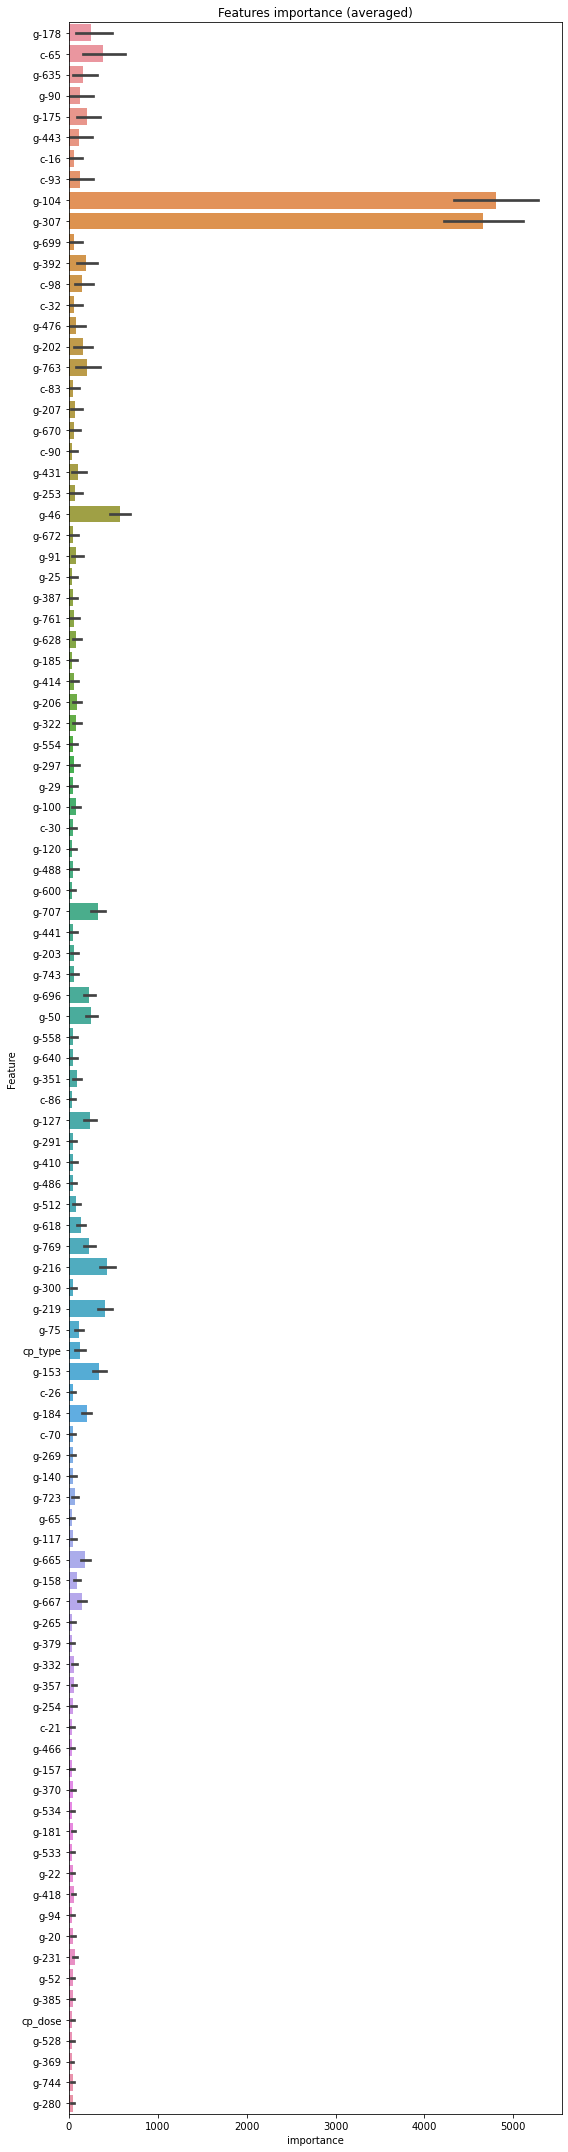

In [30]:
show_feature_importance(feature_importance_df)

In [31]:
feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)